In [ ]:
!pip install "qiskit==0.45.1" "qiskit-aer==0.13.3"


In [1]:
!pip install prototype-zne


In [2]:
from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi  #
from zne import zne

ZNEEstimator = zne(BackendEstimator)  #
backend = FakeNairobi()
estimator = ZNEEstimator(backend=backend)

In [3]:
# Cell 0: Imports & dependency check
import sys, os, math, time, copy, random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit + Aer;
HAS_QISKIT = False
HAS_AER = False
try:
    import qiskit
    from qiskit import QuantumCircuit, transpile
    from qiskit.providers.aer import AerSimulator
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.quantum_info import Statevector, Operator
    HAS_QISKIT = True
    try:
        # Attempt to instantiate AerSimulator to ensure qiskit-aer available
        _ = AerSimulator()
        HAS_AER = True
    except Exception:
        HAS_AER = False
except Exception:
    HAS_QISKIT = False
    HAS_AER = False

# PyTorch for PPO
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.distributions import Categorical
    HAS_TORCH = True
except Exception:
    HAS_TORCH = False

print("HAS_QISKIT:", HAS_QISKIT, "HAS_AER:", HAS_AER, "HAS_TORCH:", HAS_TORCH)
if not (HAS_QISKIT and HAS_AER):
    print("\nNOTE: Qiskit/Aer not fully available. Cells that need realistic noise models will fall back to toy simulator.")
if not HAS_TORCH:
    raise RuntimeError("PyTorch (torch) is required for the PPO implementation. Install with `pip install torch`.")


HAS_QISKIT: True HAS_AER: True HAS_TORCH: True


In [ ]:
# Cell 1: Utility functions - extrapolators (linear, poly2, exponential)
import warnings


def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    a, b = sol[0], sol[1]
    return float(b)

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    lambdas = np.array(lambdas)
    values = np.array(values)
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift
    if len(lambdas) == 1:
        return float(values[0] - shift)
    try:
        coefs = np.polyfit(lambdas, np.log(values), 1)
        c = -coefs[0]
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("poly2", poly2_extrapolate),
    2: ("exponential", exponential_extrapolate)
}

In [ ]:
# Cell 2: Circuit generators - XYZ / TFIM Hamiltonian Trotterized circuits (Qiskit ≥1.0)
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

def generate_xyz_hamiltonian_sparse(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """
    Build an XYZ (or TFIM) Hamiltonian in SparsePauliOp form.

    H = Σ_i [ Jx*X_i X_{i+1} + Jy*Y_i Y_{i+1} + Jz*Z_i Z_{i+1} ]
        + Σ_i [ hx*X_i + hy*Y_i + hz*Z_i ]
    with open boundary conditions.
    """
    terms = []
    coeffs = []

    # two-qubit couplings
    for i in range(n_qubits - 1):
        if abs(Jx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            pauli[i + 1] = "X"
            terms.append("".join(pauli))
            coeffs.append(Jx)
        if abs(Jy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            pauli[i + 1] = "Y"
            terms.append("".join(pauli))
            coeffs.append(Jy)
        if abs(Jz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            pauli[i + 1] = "Z"
            terms.append("".join(pauli))
            coeffs.append(Jz)

    # single-qubit fields
    for i in range(n_qubits):
        if abs(hx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            terms.append("".join(pauli))
            coeffs.append(hx)
        if abs(hy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            terms.append("".join(pauli))
            coeffs.append(hy)
        if abs(hz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            terms.append("".join(pauli))
            coeffs.append(hz)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))


def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
    with_measure: bool = False
) -> QuantumCircuit:
    """
    Build a Trotterized time-evolution circuit for the XYZ / TFIM Hamiltonian
    using Qiskit 1.x `PauliEvolutionGate` (no deprecated opflow).

    Args:
        n_qubits: number of qubits.
        trotter_steps: number of Trotter repetitions.
        dt: time-step size.
        Jx, Jy, Jz: coupling strengths.
        hx, hy, hz: external field strengths.
        with_measure: whether to append measurements.
    """
    # Hamiltonian as SparsePauliOp
    H = generate_xyz_hamiltonian_sparse(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    # Create the Trotter evolution gate using new synthesis interface
    evo_gate = PauliEvolutionGate(
        H,
        time=dt,
        synthesis=SuzukiTrotter(reps=1)  # single step per Trotter iteration
    )

    # Compose the evolution multiple times
    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    if with_measure:
        qc.measure_all()

    return qc


# --- Example test: small TFIM circuit ---
qc_test = xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7, with_measure=True)
print(qc_test)


        ┌──────────────────────────────────────────────────────────┐»
   q_0: ┤0                                                         ├»
        │                                                          │»
   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├»
        │                                                          │»
   q_2: ┤2                                                         ├»
        └──────────────────────────────────────────────────────────┘»
meas: 3/════════════════════════════════════════════════════════════»
                                                                    »
«        ┌──────────────────────────────────────────────────────────┐ ░ ┌─┐   »
«   q_0: ┤0                                                         ├─░─┤M├───»
«        │                                                          │ ░ └╥┘┌─┐»
«   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├─░──╫─┤M├»
«        │                                        

In [ ]:
# Cell 3: Circuit folding, mirrored, and Cliffordized utilities (Qiskit ≥1.0)
import math
import numpy as np

try:
    from qiskit import QuantumCircuit
    from qiskit.converters import circuit_to_dag, dag_to_circuit
    from qiskit.quantum_info import Clifford, SparsePauliOp
    HAS_QISKIT = True
except Exception:
    HAS_QISKIT = False






def mirror_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Create a mirrored circuit: U followed by U†.

    This construction has a known ideal expectation (often +1 on certain observables),
    which makes it useful for calibration or benchmarking.

    Args:
        qc: Input circuit.
    """
    if not HAS_QISKIT:
        return {"mirrored_from": qc}

    mirrored = qc.copy()
    mirrored = mirrored.compose(qc.inverse())
    return mirrored


def cliffordize_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Replace non-Clifford gates with approximate Clifford equivalents.

    This creates a circuit that can be simulated efficiently
    with stabilizer simulators. We approximate RX/RY/RZ gates
    whose angles are near multiples of π/2 as exact Clifford gates.

    Args:
        qc: Input QuantumCircuit.
    """
    if not HAS_QISKIT:
        return {"cliffordized_from": qc}

    new_qc = QuantumCircuit(qc.num_qubits)

    for instr, qargs, cargs in qc.data:
        name = instr.name.lower()
        if name in ("rx", "ry", "rz"):
            theta = float(instr.params[0])
            ratio = theta / (np.pi / 2)
            nearest = round(ratio)
            if abs(ratio - nearest) < 0.05:  # "close enough" to Clifford
                theta_cliff = nearest * (np.pi / 2)
                new_qc.append(instr.__class__(theta_cliff), qargs, cargs)
            else:
                new_qc.append(instr, qargs, cargs)
        else:
            new_qc.append(instr, qargs, cargs)

    return new_qc

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)


mirrored_qc = mirror_circuit(qc)
cliff_qc = cliffordize_circuit(qc)


print("\nMirrored circuit:")
print(mirrored_qc.draw())
print("\nCliffordized circuit:")
print(cliff_qc.draw())


Mirrored circuit:
     ┌───┐          ┌───┐
q_0: ┤ H ├──■────■──┤ H ├
     └───┘┌─┴─┐┌─┴─┐└───┘
q_1: ─────┤ X ├┤ X ├─────
          └───┘└───┘     

Cliffordized circuit:
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


In [ ]:
!pip install torch numpy matplotlib tqdm

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.primitives import BackendEstimator

from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator


In [ ]:
import numpy as np
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi

# prototype-zne imports
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator


In [ ]:
import numpy as np

class TDMC_Agent:
    def __init__(self, n_extraps, n_noisef):
        self.Q = np.zeros((n_extraps, n_noisef))
        self.alpha = 0.12
        self.gamma = 0.9
        self.eps = 0.3

    def select_action(self):
        if np.random.rand() < self.eps:
            return np.random.randint(3), np.random.randint(4)
        a = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        return a

    def update(self, action, reward, info):
        i,j = action

        # shaping term = reward for monotonic noisy values
        vals = info["values"]
        monot = np.mean(np.diff(vals) <= 0)  # 1 if perfect monotonic decay
        shaped = reward + 0.05 * monot

        td_target = shaped
        td_error = td_target - self.Q[i,j]

        self.Q[i,j] += self.alpha * td_error


In [ ]:
def train(env, agent, episodes=200):
    history = []
    for ep in range(episodes):
        env.reset()
        action = agent.select_action()
        obs, reward, done, info = env.step(action)
        agent.update(action, reward, info)
        history.append((reward, info["est"], info["ideal"]))

        if ep % 20 == 0:
            print(f"EP {ep:3d} | reward={reward:.4f} | est={info['est']:.4f}")

    return history


In [ ]:
def evaluate(env, agent, episodes=20):
    stats = []
    for _ in range(episodes):
        env.reset()
        a = agent.select_action()
        obs, r, done, info = env.step(a)
        stats.append(info)
    return stats


In [ ]:
%%writefile xyz_hamiltonian.py
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter


def generate_xyz_hamiltonian_sparse(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:

    terms, coeffs = [], []

    for i in range(n_qubits - 1):
        if abs(Jx) > 1e-10:
            p = ["I"] * n_qubits
            p[i] = "X"; p[i+1] = "X"
            terms.append("".join(p)); coeffs.append(Jx)

        if abs(Jy) > 1e-10:
            p = ["I"] * n_qubits
            p[i] = "Y"; p[i+1] = "Y"
            terms.append("".join(p)); coeffs.append(Jy)

        if abs(Jz) > 1e-10:
            p = ["I"] * n_qubits
            p[i] = "Z"; p[i+1] = "Z"
            terms.append("".join(p)); coeffs.append(Jz)

    for i in range(n_qubits):
        if abs(hx) > 1e-10:
            p = ["I"] * n_qubits
            p[i] = "X"
            terms.append("".join(p)); coeffs.append(hx)
        if abs(hy) > 1e-10:
            p = ["I"] * n_qubits
            p[i] = "Y"
            terms.append("".join(p)); coeffs.append(hy)
        if abs(hz) > 1e-10:
            p = ["I"] * n_qubits
            p[i] = "Z"
            terms.append("".join(p)); coeffs.append(hz)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))


def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
    with_measure: bool = False
) -> QuantumCircuit:

    H = generate_xyz_hamiltonian_sparse(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    evo_gate = PauliEvolutionGate(
        H,
        time=dt,
        synthesis=SuzukiTrotter(reps=1)
    )

    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    if with_measure:
        qc.measure_all()

    return qc


Writing xyz_hamiltonian.py


In [ ]:
def expand_pauli(base: str, n: int) -> SparsePauliOp:
    """Expand a small observable like 'ZZ' to 'ZZI...' automatically."""
    if len(base) > n:
        raise ValueError("Observable has more qubits than circuit")
    if len(base) == n:
        return SparsePauliOp(base)
    return SparsePauliOp(base + "I"*(n - len(base)))


In [ ]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

def generate_xyz_hamiltonian_sparse(
    n_qubits, Jx=0.4, Jy=0.4, Jz=0.0, hx=0.0, hy=0.0, hz=0.6
):
    terms, coeffs = [], []

    for i in range(n_qubits - 1):
        for (p, c) in [("X", Jx), ("Y", Jy), ("Z", Jz)]:
            if abs(c) > 1e-12:
                pauli = ["I"] * n_qubits
                pauli[i] = p; pauli[i+1] = p
                terms.append("".join(pauli)); coeffs.append(c)

    for i in range(n_qubits):
        for (p, c) in [("X", hx), ("Y", hy), ("Z", hz)]:
            if abs(c) > 1e-12:
                pauli = ["I"] * n_qubits
                pauli[i] = p
                terms.append("".join(pauli)); coeffs.append(c)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))

def xyz_trotter_circuit(
    n_qubits=3, trotter_steps=2, dt=0.1,
    Jx=0.4, Jy=0.4, Jz=0.0, hx=0.0, hy=0.0, hz=0.6,
    with_measure=False
):
    H = generate_xyz_hamiltonian_sparse(n_qubits, Jx, Jy, Jz, hx, hy, hz)
    evo = PauliEvolutionGate(H, time=dt, synthesis=SuzukiTrotter(reps=1))

    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo, range(n_qubits))
    if with_measure:
        qc.measure_all()
    return qc


In [ ]:
@dataclass
class ZNEEnv:
    circuit_generator: callable
    base_observable: str
    backend_name: str = "FakeNairobi"

    EXTRAPOLATORS = {
        0: ("linear", lambda L, V: np.polyfit(L, V, 1)[1]),
        1: ("poly2", lambda L, V: np.polyfit(L, V, 2)[2]),
        2: ("exp", lambda L, V: np.exp(np.polyfit(L, np.log(V), 1)[1])),
    }

    NOISE_SETS = [
        [1,3],
        [1,3,5],
        [1,2,4,6],
        [1,3,5,7]
    ]

    def reset(self):
        self.circuit = self.circuit_generator()
        nq = self.circuit.num_qubits
        self.observable = expand_pauli(self.base_observable, nq)

        self.backend = FakeNairobi()
        ZNE = zne(BackendEstimator)
        self.estimator = ZNE(backend=self.backend)
        return self._obs()

    def _obs(self):
        return np.array([self.circuit.depth(), self.circuit.num_qubits], dtype=np.float32)

    def step(self, action):
        ext_id, nf_id = action
        (name, ext_fn) = self.EXTRAPOLATORS[ext_id]
        noise_factors = self.NOISE_SETS[nf_id]

        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(),
            extrapolator=None
        )

        job = self.estimator.run(self.circuit, self.observable, zne_strategy=strategy)
        res = job.result()
        meta = res.metadata[0]["zne"]["noise_amplification"]

        L = meta["noise_factors"]
        V = meta["values"]
        est = ext_fn(L, V)

        ideal = Estimator().run(self.circuit, self.observable).result().values[0]
        reward = -abs(est - ideal)

        return self._obs(), reward, True, {
            "ideal": ideal,
            "est": est,
            "lambdas": L,
            "values": V,
            "extrap": name
        }


In [ ]:
class TDMC_Agent:
    def __init__(self, n_extraps=3, n_noise=4):
        self.Q = np.zeros((n_extraps, n_noise))
        self.alpha = 0.2
        self.gamma = 0.9
        self.eps = 0.25

    def act(self):
        if np.random.rand() < self.eps:
            return np.random.randint(3), np.random.randint(4)
        return np.unravel_index(np.argmax(self.Q), self.Q.shape)

    def update(self, action, reward):
        i,j = action
        td_error = reward - self.Q[i,j]
        self.Q[i,j] += self.alpha * td_error


In [ ]:
def train(env, agent, episodes=150):
    hist = []
    for ep in range(episodes):
        env.reset()
        a = agent.act()
        _, r, _, info = env.step(a)
        agent.update(a, r)
        hist.append((r, info["est"], info["ideal"]))

        if ep % 20 == 0:
            print(f"EP:{ep:3d} | reward={r:.4f} | est={info['est']:.4f}")

    return hist


In [ ]:
def evaluate(env, agent, episodes=20):
    out = []
    for _ in range(episodes):
        env.reset()
        a = agent.act()
        _, r, _, info = env.step(a)
        out.append(info)
    return out


In [ ]:
from qiskit.primitives import Estimator

def tfim_circuit():
    return xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.8)

env = ZNEEnv(circuit_generator=tfim_circuit, base_observable="ZZ")
agent = TDMC_Agent()

history = train(env, agent, episodes=150)
stats = evaluate(env, agent)


EP:  0 | reward=-0.1115 | est=0.8877


/tmp/ipython-input-4025664375.py:9: RankWarning: Polyfit may be poorly conditioned
  1: ("poly2", lambda L, V: np.polyfit(L, V, 2)[2]),


EP: 20 | reward=-0.0303 | est=0.9689


/tmp/ipython-input-4025664375.py:9: RankWarning: Polyfit may be poorly conditioned
  1: ("poly2", lambda L, V: np.polyfit(L, V, 2)[2]),


EP: 40 | reward=-0.0431 | est=0.9561
EP: 60 | reward=-0.0679 | est=0.9314


/tmp/ipython-input-4025664375.py:9: RankWarning: Polyfit may be poorly conditioned
  1: ("poly2", lambda L, V: np.polyfit(L, V, 2)[2]),


EP: 80 | reward=-0.0493 | est=1.0485
EP:100 | reward=-0.0247 | est=0.9746


/tmp/ipython-input-4025664375.py:9: RankWarning: Polyfit may be poorly conditioned
  1: ("poly2", lambda L, V: np.polyfit(L, V, 2)[2]),


EP:120 | reward=-0.1377 | est=0.8615
EP:140 | reward=-0.1057 | est=0.8935


/tmp/ipython-input-4025664375.py:9: RankWarning: Polyfit may be poorly conditioned
  1: ("poly2", lambda L, V: np.polyfit(L, V, 2)[2]),


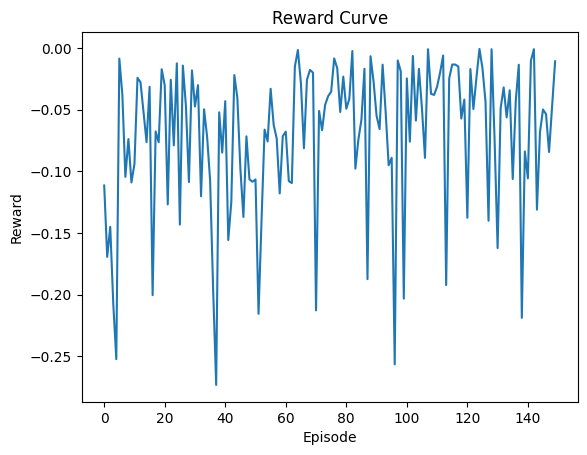

In [ ]:
plt.plot([h[0] for h in history])
plt.title("Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


In [ ]:
from dataclasses import dataclass
from typing import List, Tuple, Any
import numpy as np
import math

from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi

from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier

# expand a 2-qubit Pauli like "ZZ" to n-qubits → ensures no dimension mismatch
def expand_pauli(label, n):
    if len(label) == n:
        return SparsePauliOp(label)
    pad = "I" * (n - len(label))
    return SparsePauliOp(label + pad)


@dataclass
class ZNEEnv:
    circuit_generator: callable
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    # same extrapolators
    EXTRAPOLATORS = {
        0: ("linear", lambda L, V: np.polyfit(L, V, 1)[1]),
        1: ("poly2", lambda L, V: np.polyfit(L, V, 2)[2]),
        2: ("exp", lambda L, V: np.exp(np.polyfit(L, np.log(V), 1)[1])),
    }

    NOISE_SETS = [
        [1, 3],
        [1, 3, 5],
        [1, 2, 4, 6],
        [1, 3, 5, 7]
    ]

    def reset(self):
        self.circuit = self.circuit_generator()
        nq = self.circuit.num_qubits

        # ensure observable size matches the circuit
        self.observable = expand_pauli(self.base_observable, nq)

        self.backend = FakeNairobi()
        ZNE = zne(BackendEstimator)
        self.estimator = ZNE(backend=self.backend)

        return self._obs()

    def _obs(self):
        return np.array([
            self.circuit.depth(),
            self.circuit.num_qubits
        ], dtype=np.float32)

    def step(self, action: Tuple[int, int]):
        extrap_id, noise_id = action

        extrap_name, ext_fn = self.EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_SETS[noise_id]

        # build ZNE strategy
        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(),
            extrapolator=None
        )

        # run noisy evaluations at different λ
        job = self.estimator.run(
            self.circuit,
            self.observable,
            zne_strategy=strategy
        )
        res = job.result()

        meta = res.metadata[0]["zne"]["noise_amplification"]

        L = meta["noise_factors"]
        V = meta["values"]

        # compute extrapolated ZNE estimate
        est = ext_fn(L, V)

        # ideal noiseless expectation
        ideal = Estimator().run(self.circuit, self.observable).result().values[0]

        reward = -abs(est - ideal)

        # ---- DEBUG PRINTS ----
        print("\n================ DEBUG ================")
        print(f"Noise factors (λ):      {L}")
        print(f"Noisy values:           {V}")
        print(f"Extrapolator used:      {extrap_name}")
        print(f"ZNE extrapolated value: {est:.6f}")
        print(f"Ideal expectation:      {ideal:.6f}")
        print(f"Reward:                 {reward:.6f}")
        print("=======================================\n")

        return (
            self._obs(),
            reward,
            True,
            {
                "ideal": ideal,
                "est": est,
                "lambdas": L,
                "values": V,
                "extrap": extrap_name
            }
        )



FULL EXPERIMENTAL PIPELINE

[TRAINING]


Ep 180 | ε=0.161 | Avg Rel Error: 0.3284: 100%|██████████| 200/200 [02:39<00:00,  1.25it/s]



[EVALUATION]

[BASELINE] Running random parameter selection...


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]



STATISTICAL SUMMARY

RL-TDMC Agent:
  Mean relative error:    0.332474
  Median relative error: 0.326701
  Std relative error:     0.025465
  Min relative error:     0.274833
  Max relative error:     0.398173

Random Baseline:
  Mean relative error:    0.329298
  Median relative error: 0.328545
  Std relative error:     0.037543

Relative Improvement: -0.96%
Mann-Whitney U test p-value: 0.628339

[GENERATING FIGURES]


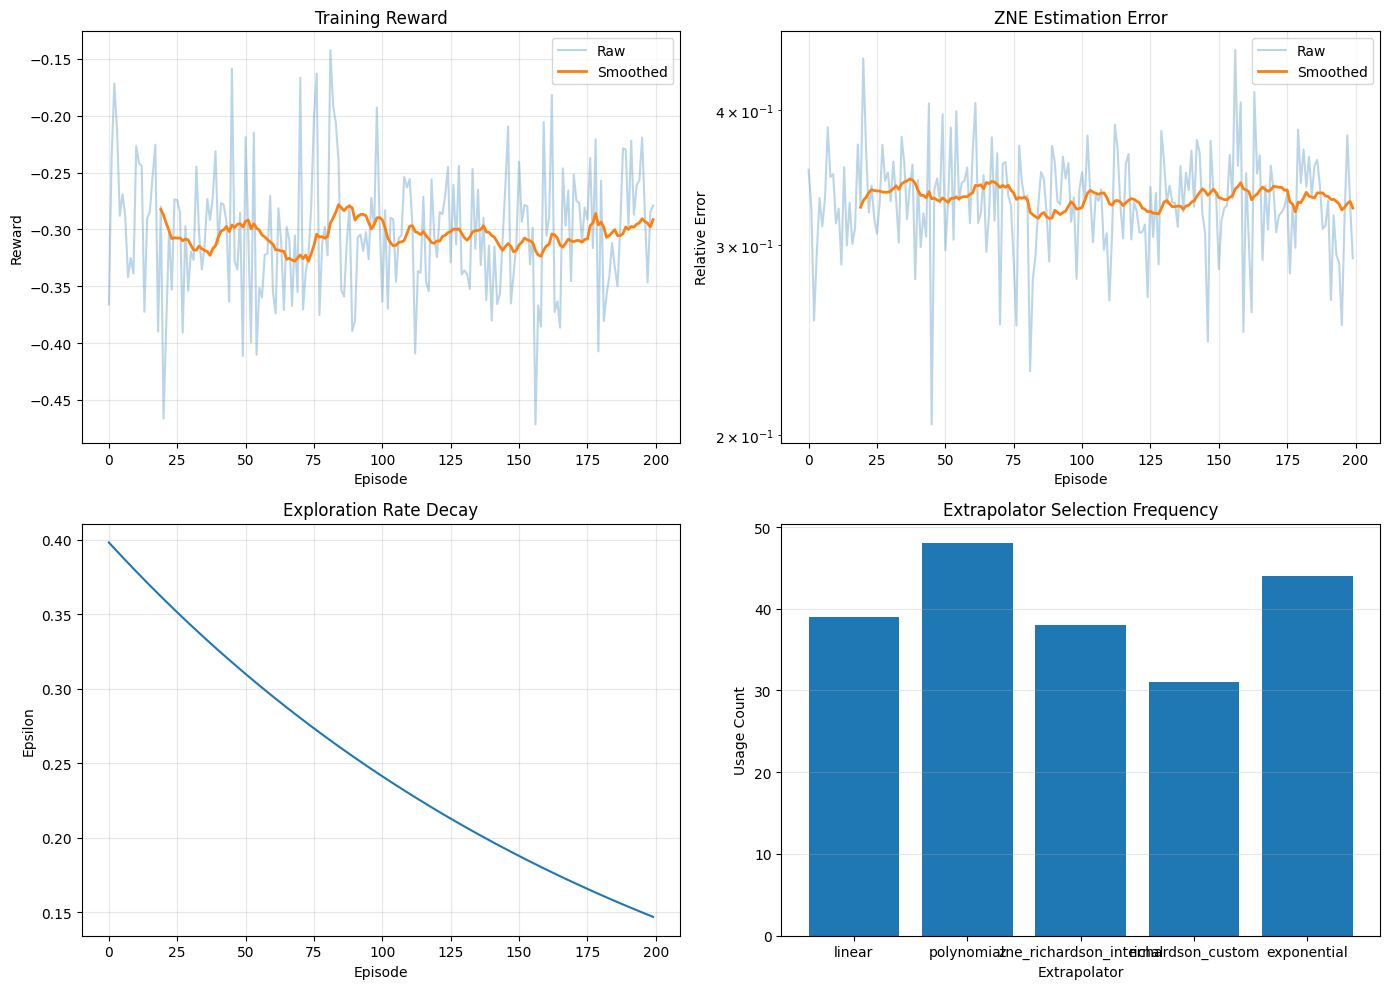

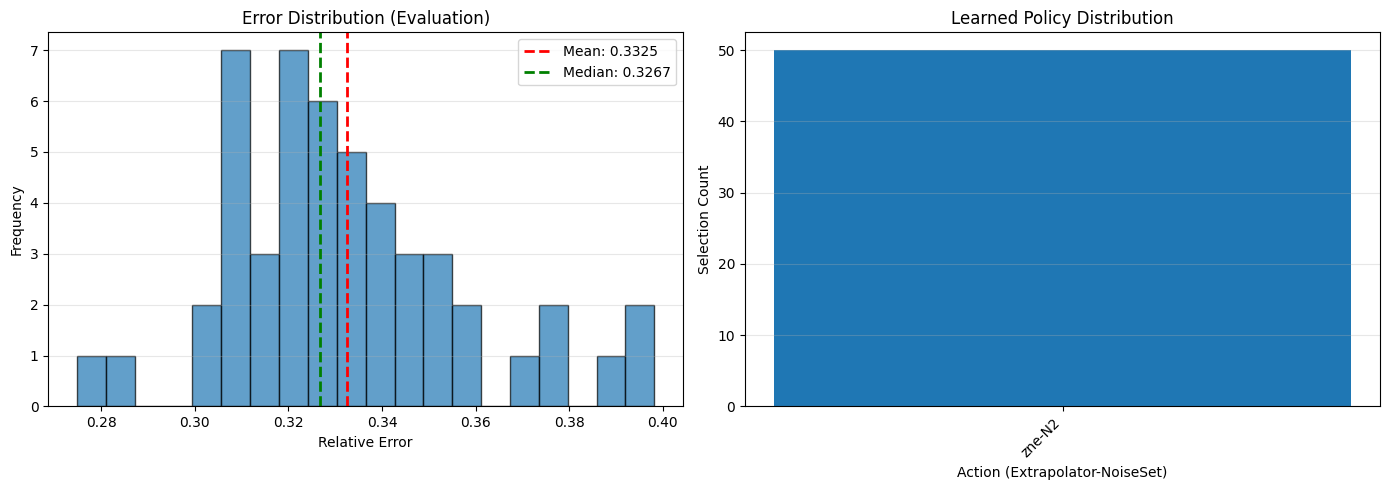

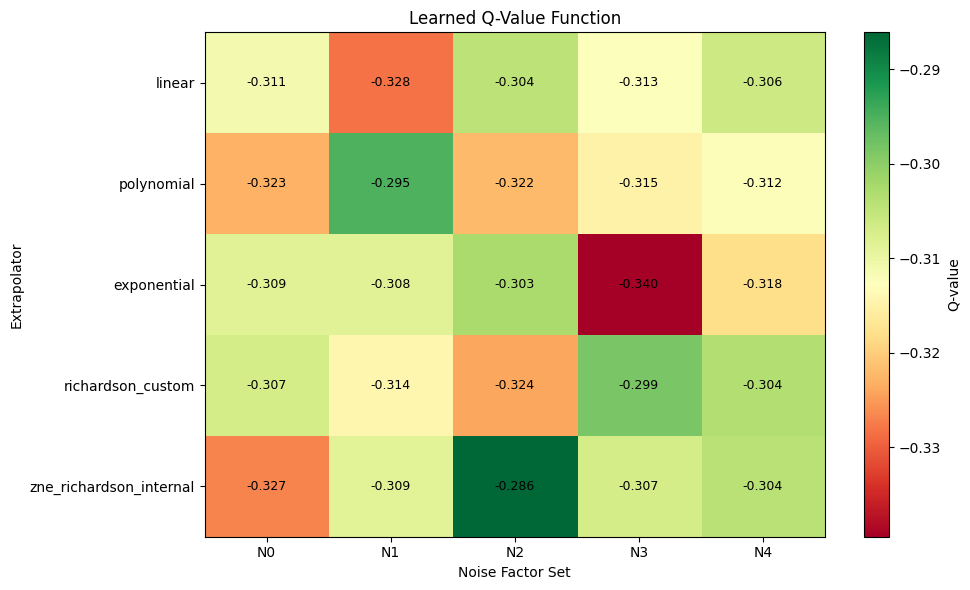

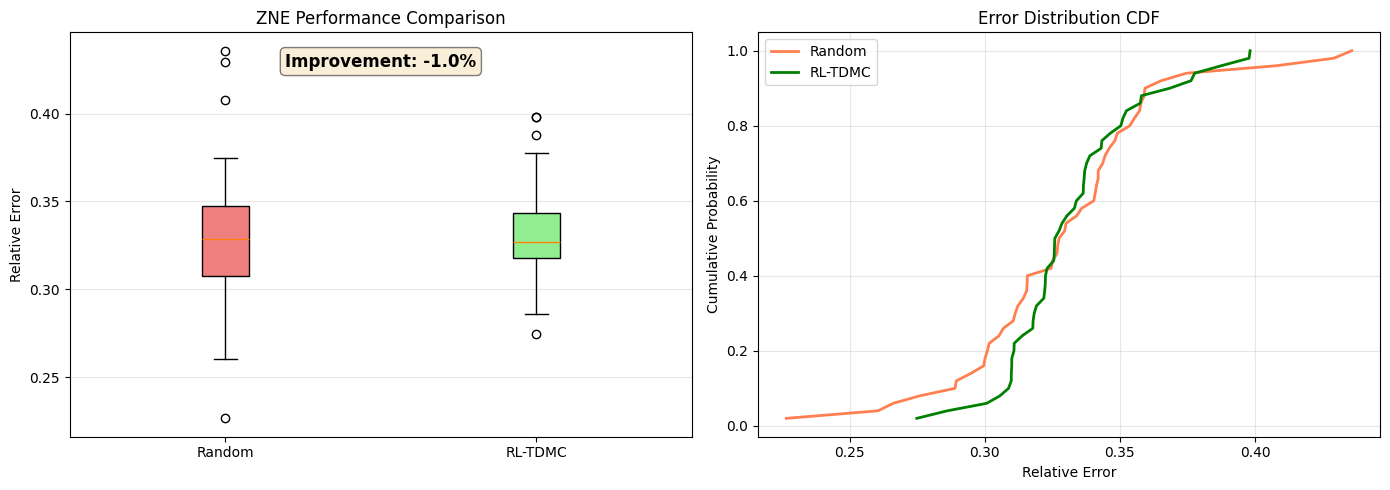


EXPERIMENT COMPLETE

Generated files:
  - fig1_training.png
  - fig2_evaluation.png
  - fig3_qtable.png
  - fig4_comparison.png

FULL EXPERIMENTAL PIPELINE

[TRAINING]


Ep 180 | ε=0.161 | Avg Rel Error: 0.3308: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]



[EVALUATION]

[BASELINE] Running random parameter selection...


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]



STATISTICAL SUMMARY

RL-TDMC Agent:
  Mean relative error:    0.335784
  Median relative error: 0.335722
  Std relative error:     0.020588
  Min relative error:     0.292371
  Max relative error:     0.377068

Random Baseline:
  Mean relative error:    0.323277
  Median relative error: 0.323445
  Std relative error:     0.038626

Relative Improvement: -3.87%
Mann-Whitney U test p-value: 0.980849

[GENERATING FIGURES]


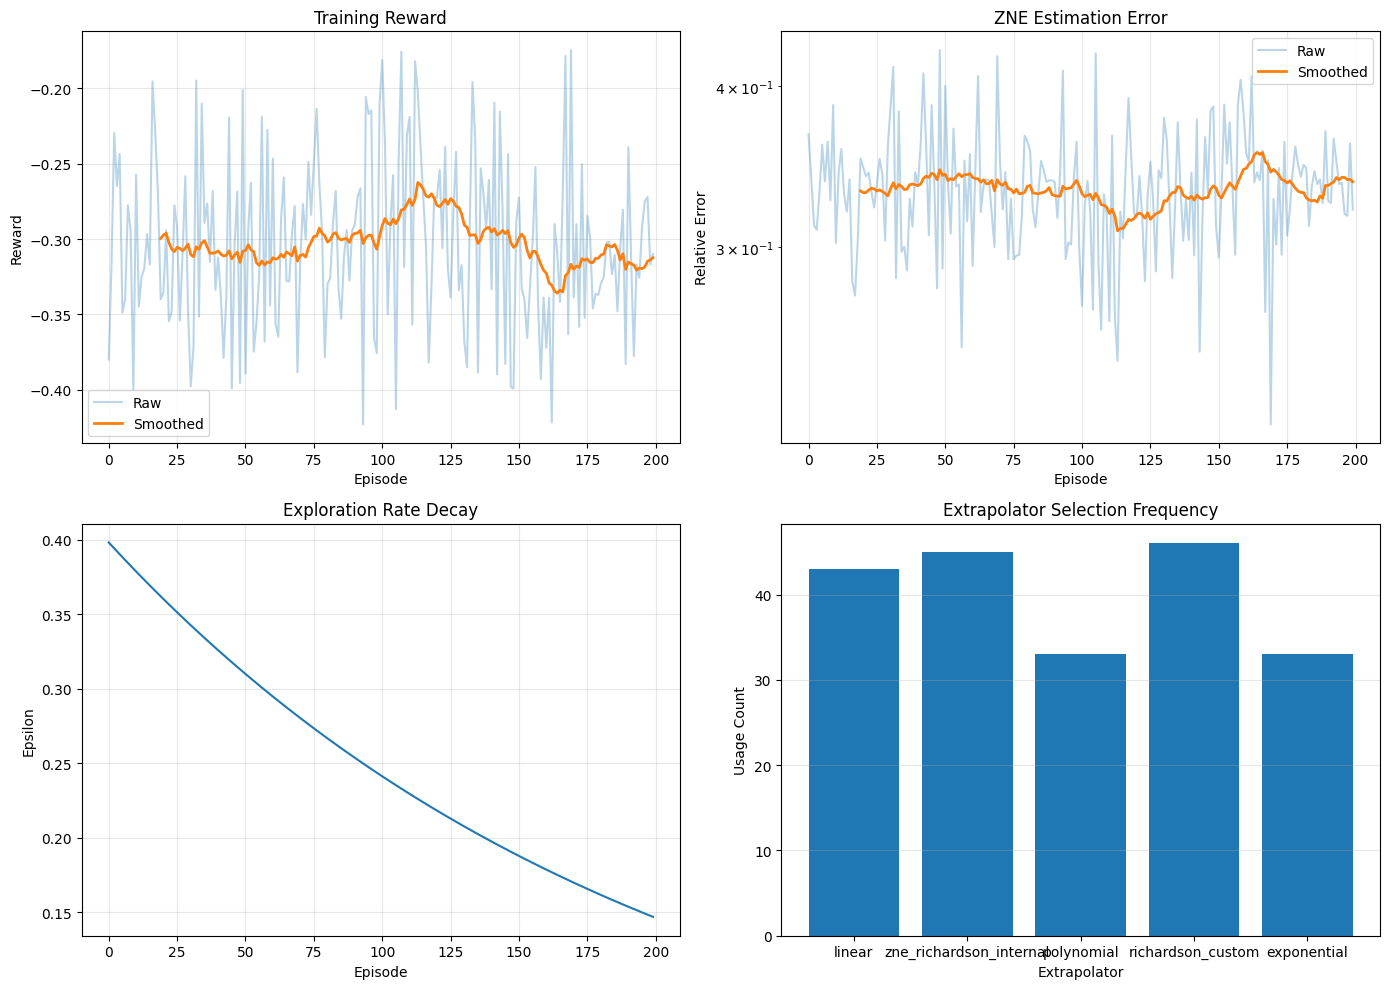

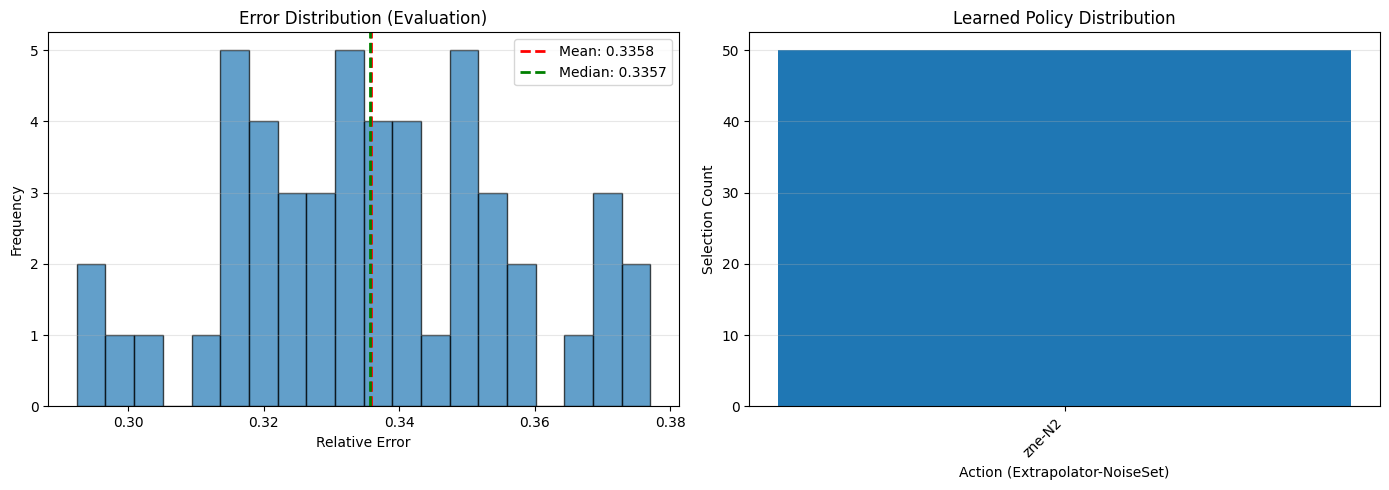

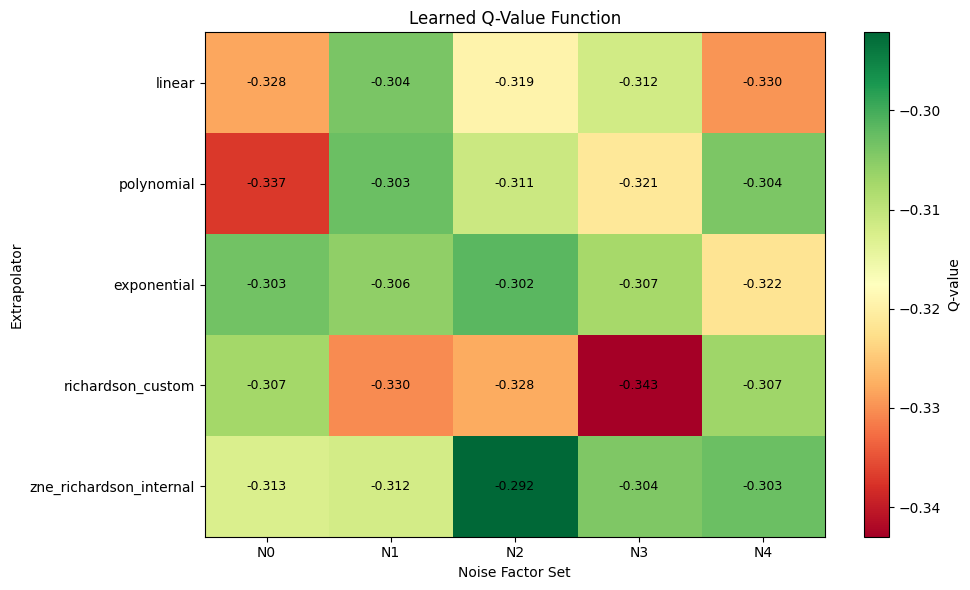

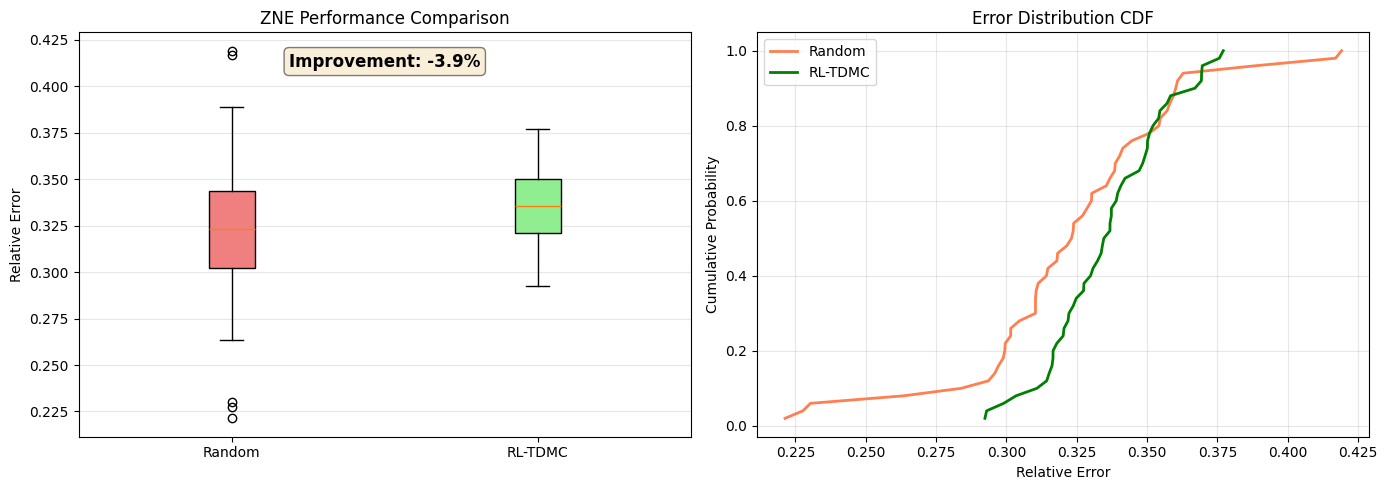


EXPERIMENT COMPLETE

Generated files:
  - fig1_training.png
  - fig2_evaluation.png
  - fig3_qtable.png
  - fig4_comparison.png

GENERALIZATION TEST

[TRAINING] on TFIM-small...

[TESTING] across different circuits...

  Testing on TFIM-small...
    Mean relative error: 0.249840

  Testing on TFIM-medium...
    Mean relative error: 0.332966

  Testing on TFIM-large...
    Mean relative error: 0.254510

  Testing on Heisenberg...
    Mean relative error: 0.292415


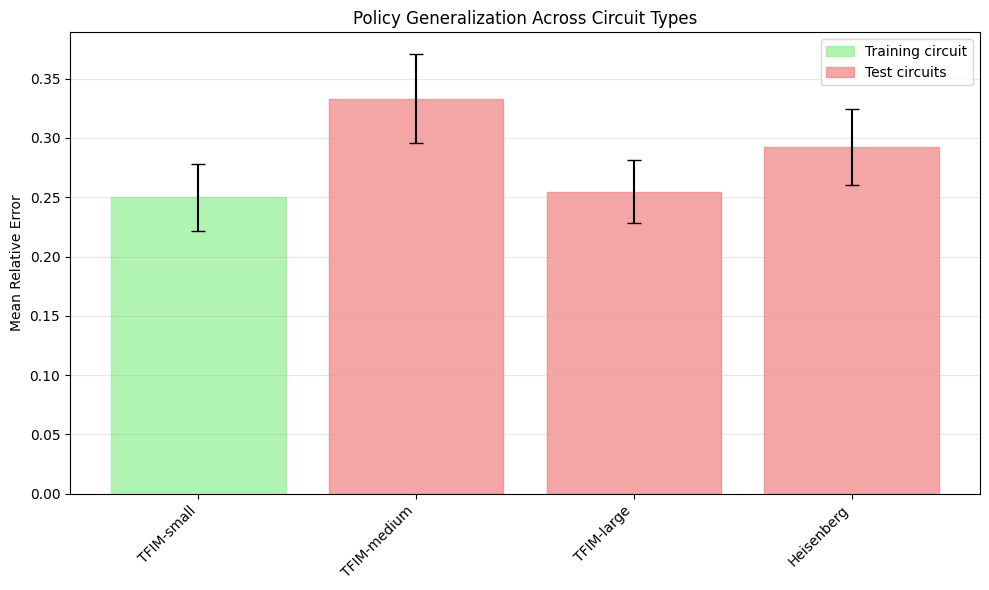


GENERALIZATION TEST COMPLETE

ALL EXPERIMENTS COMPLETE

Key Findings:


TypeError: tuple indices must be integers or slices, not str

In [ ]:
import numpy as np
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi
# ZNE imports
from zne import zne, ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
warnings.filterwarnings('ignore')

# ============================================================================
## PART 1: EXTRAPOLATION FUNCTIONS
# ============================================================================
def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Linear extrapolation to zero noise: f(λ) = aλ + b, return f(0) = b"""
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[1])

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Quadratic extrapolation: f(λ) = aλ² + bλ + c, return f(0) = c"""
    if len(lambdas) < 3:
        return linear_extrapolate(lambdas, values)
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Exponential extrapolation: f(λ) = b*exp(-cλ), return f(0) = b"""
    lambdas = np.array(lambdas)
    values = np.array(values)

    # Handle non-positive values
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift

    if len(lambdas) == 1:
        return float(values[0] - shift)

    try:
        # Fit ln(f) = ln(b) - cλ
        coefs = np.polyfit(lambdas, np.log(values), 1)
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

def richardson_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Richardson extrapolation for noise amplification (Custom implementation)"""
    if len(lambdas) < 2:
        return values[0]

    lambdas = np.array(lambdas)
    values = np.array(values)

    # Richardson's formula for first order
    if len(lambdas) == 2:
        l1, l2 = lambdas
        v1, v2 = values
        return (l2*v1 - l1*v2) / (l2 - l1)

    # Use polynomial for more points
    return poly2_extrapolate(lambdas, values)

def zne_internal_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """
    ZNEEnvironment.step method to use the internal ZNEStrategy
    extrapolator.
    """
    raise NotImplementedError(" should not be executed.")

# Extrapolator registry
EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("polynomial", poly2_extrapolate),
    2: ("exponential", exponential_extrapolate),
    3: ("richardson_custom", richardson_extrapolate),
    4: ("zne_richardson_internal", zne_internal_extrapolate), #
}

# ============================================================================
## PART 2: CIRCUIT GENERATORS
# ============================================================================
def generate_xyz_hamiltonian(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """
    Generate XYZ/TFIM Hamiltonian: H = Σ_i [J_x X_i X_{i+1} + ...] + Σ_i [h_x X_i + ...]
    """
    terms, coeffs = [], []

    # Two-qubit interactions
    for i in range(n_qubits - 1):
        for pauli, coupling in [("X", Jx), ("Y", Jy), ("Z", Jz)]:
            if abs(coupling) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i + 1] = pauli
                terms.append("".join(p))
                coeffs.append(coupling)

    # Single-qubit fields
    for i in range(n_qubits):
        for pauli, field in [("X", hx), ("Y", hy), ("Z", hz)]:
            if abs(field) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i] = pauli
                terms.append("".join(p))
                coeffs.append(field)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))

def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
) -> QuantumCircuit:
    """Build Trotterized time evolution circuit"""
    H = generate_xyz_hamiltonian(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    evo_gate = PauliEvolutionGate(
        H, time=dt, synthesis=SuzukiTrotter(reps=1)
    )

    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    return qc

def expand_observable(base: str, n_qubits: int) -> SparsePauliOp:
    """Expand observable like 'ZZ' to match circuit size 'ZZI...'"""
    if len(base) > n_qubits:
        raise ValueError(f"Observable {base} too large for {n_qubits} qubits")
    if len(base) == n_qubits:
        return SparsePauliOp(base)
    padding = "I" * (n_qubits - len(base))
    return SparsePauliOp(base + padding)

# ============================================================================
## PART 3: ZNE ENVIRONMENT (Updated)
# ============================================================================
@dataclass
class ZNEEnvironment:
    """
    Quantum environment for ZNE parameter optimization.

    The environment generates quantum circuits, executes ZNE with chosen parameters,
    and returns rewards based on estimation accuracy.
    """
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    # Action space: combinations of extrapolators and noise factor sets
    NOISE_FACTOR_SETS = [
        [1, 3],             # Minimal: fast but less accurate
        [1, 3, 5],          # Standard: balanced
        [1, 2, 4, 6],       # Dense sampling: more data points
        [1, 3, 5, 7],       # Extended range: better for high noise
        [1, 2, 3, 5, 7],    # Comprehensive: most expensive
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self) -> np.ndarray:
        """Reset environment with new circuit"""
        self.circuit = self.circuit_generator()
        n_qubits = self.circuit.num_qubits

        # Expand observable to match circuit size
        self.observable = expand_observable(self.base_observable, n_qubits)

        # Setup backend
        self.backend = FakeNairobi()
        ZNEEstimator = zne(BackendEstimator)
        self.estimator = ZNEEstimator(backend=self.backend)

        # Compute ideal value once
        self.ideal_value = Estimator().run(
            self.circuit, self.observable
        ).result().values[0]

        return self._get_observation()

    def _get_observation(self) -> np.ndarray:
        """Extract features from current circuit"""
        features = [
            self.circuit.depth(),
            self.circuit.num_qubits,
            self.circuit.count_ops().get('cx', 0),  # Two-qubit gate count
            self.circuit.size(),  # Total gate count
        ]
        return np.array(features, dtype=np.float32)

    def step(self, action: Tuple[int, int]) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Execute ZNE with selected parameters.

        Args:
            action: (extrapolator_id, noise_set_id)

        Returns:
            observation, reward, done, info
        """
        extrap_id, noise_id = action

        extrap_name, extrap_fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]

        # Determine if we use the ZNE-internal extrapolator
        # ID 4 is the new 'zne_richardson_internal' option
        USE_ZNE_INTERNAL = (extrap_id == 4)

        # Build ZNE strategy
        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            # Use RichardsonExtrapolator internally if selected, otherwise set to None
            # extrapolation later.
            extrapolator=PolynomialExtrapolator(degree=1)
        )

        # Execute noisy experiments
        job = self.estimator.run(
            self.circuit,
            self.observable,
            zne_strategy=strategy
        )
        result = job.result()

        # --- ZNE Result Processing ---

        # Extract metadata common to all
        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])

        if USE_ZNE_INTERNAL:
            # The result object already contains the final extrapolated value
            # because we passed the extrapolator in the ZNEStrategy.
            zne_estimate = result.values[0]
        else:
            # Apply selected custom extrapolation
            try:
                zne_estimate = extrap_fn(lambdas, noisy_values)
            except Exception as e:
                print(f"Extrapolation failed: {e}")
                zne_estimate = noisy_values[0]

        # --- Reward Calculation ---

        # Compute reward with multiple components
        error = abs(zne_estimate - self.ideal_value)
        relative_error = error / (abs(self.ideal_value) + 1e-10)

        # Reward shaping
        base_reward = -relative_error

        # Bonus for monotonic decay (good noise amplification)
        if len(noisy_values) > 1:
            diffs = np.diff(noisy_values)
            monotonic_score = np.mean(diffs <= 0)  # 1.0 if perfectly decreasing
            monotonic_bonus = 0.1 * monotonic_score
        else:
            monotonic_bonus = 0.0

        # Penalty for high variance (unstable estimates)
        variance_penalty = -0.05 * np.mean(variances)

        # Efficiency bonus (fewer noise factors = faster)
        efficiency_bonus = 0.02 * (5 - len(noise_factors)) / 4

        total_reward = base_reward + monotonic_bonus + variance_penalty + efficiency_bonus

        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": relative_error,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": extrap_name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base_reward,
            "monotonic_bonus": monotonic_bonus,
            "variance_penalty": variance_penalty,
            "efficiency_bonus": efficiency_bonus,
        }

        return self._get_observation(), total_reward, True, info

# ============================================================================
## PART 4: TEMPORAL DIFFERENCE MONTE CARLO (TDMC) AGENT
# ============================================================================
class TDMCAgent:
    """
    Temporal Difference Monte Carlo agent for ZNE parameter selection.

    This agent uses tabular Q-learning with TD updates and eligibility traces,
    providing a balance between sample efficiency and convergence stability.
    """

    def __init__(
        self,
        n_extrapolators: int,
        n_noise_sets: int,
        learning_rate: float = 0.15,
        discount_factor: float = 0.95,
        epsilon: float = 0.3,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.05,
        trace_decay: float = 0.7,
    ):
        """
        Initialize TDMC agent.

        Args:
            n_extrapolators: Number of extrapolation methods
            n_noise_sets: Number of noise factor configurations
            learning_rate: Step size for Q-value updates
            discount_factor: Future reward discount
            epsilon: Initial exploration rate
            epsilon_decay: Decay rate for epsilon
            epsilon_min: Minimum exploration rate
            trace_decay: Eligibility trace decay factor
        """
        # Q-table: Q(extrapolator, noise_set)
        self.Q = np.zeros((n_extrapolators, n_noise_sets))

        # Eligibility traces for TD(λ)
        self.E = np.zeros_like(self.Q)

        # Hyperparameters
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambda_trace = trace_decay

        # Statistics
        self.action_counts = np.zeros_like(self.Q)
        self.total_steps = 0

    def select_action(self, exploration: bool = True) -> Tuple[int, int]:
        """
        Select action using epsilon-greedy policy.

        Args:
            exploration: If False, always exploit (for evaluation)

        Returns:
            (extrapolator_id, noise_set_id)
        """
        if exploration and np.random.rand() < self.epsilon:
            # Explore: random action
            extrap_id = np.random.randint(self.Q.shape[0])
            noise_id = np.random.randint(self.Q.shape[1])
        else:
            # Exploit: best known action
            extrap_id, noise_id = np.unravel_index(
                np.argmax(self.Q), self.Q.shape
            )

        return extrap_id, noise_id

    def update(
        self,
        action: Tuple[int, int],
        reward: float,
        info: Dict[str, Any],
    ):
        """
        Update Q-values using TD(λ) with eligibility traces.

        Args:
            action: Selected action
            reward: Received reward
            info: Additional information from environment
        """
        i, j = action
        self.action_counts[i, j] += 1
        self.total_steps += 1

        # TD error: δ = R - Q(s,a)  [terminal state, so no next Q-value]
        td_error = reward - self.Q[i, j]

        # Update eligibility trace for this action
        self.E[i, j] += 1.0

        # TD(λ) update: Q += α * δ * E
        self.Q += self.alpha * td_error * self.E

        # Decay eligibility traces
        self.E *= self.gamma * self.lambda_trace

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self) -> np.ndarray:
        """Return current greedy policy as probability distribution"""
        policy = np.zeros_like(self.Q)
        best_action = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        policy[best_action] = 1.0
        return policy

    def get_value_function(self) -> np.ndarray:
        """Return state-action value function"""
        return self.Q.copy()

# ============================================================================
## PART 5: TRAINING LOOP
# ============================================================================
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 200,
    verbose: bool = True,
) -> Dict[str, List]:
    """
    Train TDMC agent on ZNE parameter selection.

    Args:
        env: ZNE environment
        agent: TDMC agent
        n_episodes: Number of training episodes
        verbose: Print progress

    Returns:
        Dictionary containing training history
    """
    history = {
        "rewards": [],
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
        "extrapolators": [],
        "n_noise_factors": [],
        "epsilons": [],
    }

    iterator = tqdm(range(n_episodes)) if verbose else range(n_episodes)

    for episode in iterator:
        # Reset environment
        obs = env.reset()

        # Select action
        action = agent.select_action(exploration=True)

        # Execute action
        next_obs, reward, done, info = env.step(action)

        # Update agent
        agent.update(action, reward, info)

        # Record history
        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(info["extrapolator"])
        history["n_noise_factors"].append(info["n_noise_factors"])
        history["epsilons"].append(agent.epsilon)

        # Progress update
        if verbose and episode % 20 == 0:
            recent_errors = history["relative_errors"][-20:]
            avg_error = np.mean(recent_errors) if recent_errors else 0
            iterator.set_description(
                f"Ep {episode:3d} | ε={agent.epsilon:.3f} | "
                f"Avg Rel Error: {avg_error:.4f}"
            )

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
) -> Dict[str, List]:
    """
    Evaluate trained agent (no exploration).

    Args:
        env: ZNE environment
        agent: Trained TDMC agent
        n_episodes: Number of evaluation episodes

    Returns:
        Dictionary containing evaluation results
    """
    results = {
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
        "extrapolators": [],
        "n_noise_factors": [],
        "actions": [],
    }

    for _ in range(n_episodes):
        obs = env.reset()
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])
        results["extrapolators"].append(info["extrapolator"])
        results["n_noise_factors"].append(info["n_noise_factors"])
        results["actions"].append(action)

    return results

# ============================================================================
## PART 6: VISUALIZATION
# ============================================================================
def plot_training_results(history: Dict[str, List], save_path: str = None):
    """Plot training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Reward curve
    ax = axes[0, 0]
    rewards = history["rewards"]
    ax.plot(rewards, alpha=0.3, label="Raw")
    window = 20
    if len(rewards) > window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Training Reward")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Relative error
    ax = axes[0, 1]
    rel_errors = history["relative_errors"]
    ax.plot(rel_errors, alpha=0.3, label="Raw")
    if len(rel_errors) > window:
        smoothed = np.convolve(rel_errors, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rel_errors)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Estimation Error")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Exploration rate
    ax = axes[1, 0]
    ax.plot(history["epsilons"])
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.set_title("Exploration Rate Decay")
    ax.grid(True, alpha=0.3)

    # Extrapolator usage
    ax = axes[1, 1]
    from collections import Counter
    extrap_counts = Counter(history["extrapolators"])
    ax.bar(extrap_counts.keys(), extrap_counts.values())
    ax.set_xlabel("Extrapolator")
    ax.set_ylabel("Usage Count")
    ax.set_title("Extrapolator Selection Frequency")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_evaluation_results(results: Dict[str, List], save_path: str = None):
    """Plot evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Error distribution
    ax = axes[0]
    rel_errors = results["relative_errors"]
    ax.hist(rel_errors, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(rel_errors), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {np.mean(rel_errors):.4f}')
    ax.axvline(np.median(rel_errors), color='green', linestyle='--',
               linewidth=2, label=f'Median: {np.median(rel_errors):.4f}')
    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Frequency")
    ax.set_title("Error Distribution (Evaluation)")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Action distribution
    ax = axes[1]
    from collections import Counter
    action_counts = Counter(results["actions"])
    # Adjust labels to reflect the new ID 4
    extrap_map = {i: EXTRAPOLATORS[i][0].split('_')[0] for i in EXTRAPOLATORS}
    action_labels = [f"{extrap_map[e]}-N{n}" for e, n in action_counts.keys()]
    ax.bar(range(len(action_counts)), action_counts.values())
    ax.set_xticks(range(len(action_counts)))
    ax.set_xticklabels(action_labels, rotation=45, ha='right')
    ax.set_xlabel("Action (Extrapolator-NoiseSet)")
    ax.set_ylabel("Selection Count")
    ax.set_title("Learned Policy Distribution")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_q_table(agent: TDMCAgent, save_path: str = None):
    """Visualize learned Q-values"""
    fig, ax = plt.subplots(figsize=(10, 6))

    im = ax.imshow(agent.Q, cmap='RdYlGn', aspect='auto')

    # Set ticks
    ax.set_xticks(range(agent.Q.shape[1]))
    ax.set_yticks(range(agent.Q.shape[0]))

    # Labels
    noise_labels = [f"N{i}" for i in range(agent.Q.shape[1])]
    extrap_labels = [EXTRAPOLATORS[i][0] for i in range(agent.Q.shape[0])]

    ax.set_xticklabels(noise_labels)
    ax.set_yticklabels(extrap_labels)

    # Annotate cells with Q-values
    for i in range(agent.Q.shape[0]):
        for j in range(agent.Q.shape[1]):
            text = ax.text(j, i, f'{agent.Q[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)

    ax.set_xlabel("Noise Factor Set")
    ax.set_ylabel("Extrapolator")
    ax.set_title("Learned Q-Value Function")

    plt.colorbar(im, ax=ax, label="Q-value")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 7: MAIN EXPERIMENT
# ============================================================================
def main():
    """Run complete RL-based ZNE experiment"""

    print("="*70)
    print("RL-BASED ZERO NOISE EXTRAPOLATION PARAMETER SELECTION")
    print("="*70)

    # Define circuit generator (TFIM Hamiltonian)
    def tfim_circuit_generator():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,  # Transverse field Ising
            hz=0.8,
        )

    # Create environment
    print("\n[1] Creating ZNE environment...")
    env = ZNEEnvironment(
        circuit_generator=tfim_circuit_generator,
        base_observable="ZZ",
        backend_name="FakeNairobi"
    )

    # Create agent
    print("[2] Initializing TDMC agent...")
    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.15,
        discount_factor=0.95,
        epsilon=0.4,
        epsilon_decay=0.995,
        epsilon_min=0.05,
        trace_decay=0.7,
    )

    # Training
    print("[3] Training agent...")
    history = train_agent(
        env=env,
        agent=agent,
        n_episodes=200,
        verbose=True
    )

    # Evaluation
    print("\n[4] Evaluating trained agent...")
    eval_results = evaluate_agent(
        env=env,
        agent=agent,
        n_episodes=50
    )

    # Print results
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print("\nTraining Performance:")
    print(f"  Final 20-episode avg reward: {np.mean(history['rewards'][-20:]):.4f}")
    print(f"  Final 20-episode avg rel error: {np.mean(history['relative_errors'][-20:]):.4f}")

    print("\nEvaluation Performance:")
    print(f"  Mean relative error: {np.mean(eval_results['relative_errors']):.4f}")
    print(f"  Median relative error: {np.median(eval_results['relative_errors']):.4f}")
    print(f"  Std relative error: {np.std(eval_results['relative_errors']):.4f}")

    print("\nLearned Policy:")
    best_action = np.unravel_index(np.argmax(agent.Q), agent.Q.shape)
    best_extrap = EXTRAPOLATORS[best_action[0]][0]
    best_noise = env.NOISE_FACTOR_SETS[best_action[1]]
    print(f"  Best extrapolator: {best_extrap}")
    print(f"  Best noise factors: {best_noise}")
    print(f"  Q-value: {agent.Q[best_action]:.4f}")

    # Visualization
    print("\n[5] Generating visualizations...")
    plot_training_results(history, save_path="training_results.png")
    plot_evaluation_results(eval_results, save_path="evaluation_results.png")
    visualize_q_table(agent, save_path="q_table.png")

    print("\n" + "="*70)
    print("Experiment complete! Figures saved.")
    print("="*70)

    return history, eval_results, agent

# ============================================================================
## PART 8: COMPARATIVE BASELINE EXPERIMENT
# ============================================================================
def baseline_comparison(env: ZNEEnvironment, n_trials: int = 50):
    """
    Compare RL-selected parameters against random baseline.

    Args:
        env: ZNE environment
        n_trials: Number of trials per method

    Returns:
        Dictionary with comparison statistics
    """
    print("\n[BASELINE] Running random parameter selection...")

    random_results = {
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
    }

    for _ in tqdm(range(n_trials)):
        env.reset()

        # Random action
        extrap_id = np.random.randint(len(EXTRAPOLATORS))
        noise_id = np.random.randint(len(env.NOISE_FACTOR_SETS))
        action = (extrap_id, noise_id)

        _, reward, _, info = env.step(action)

        random_results["errors"].append(info["error"])
        random_results["relative_errors"].append(info["relative_error"])
        random_results["estimates"].append(info["estimate"])
        random_results["ideal_values"].append(info["ideal"])

    return random_results

def plot_comparison(rl_results: Dict, baseline_results: Dict, save_path: str = None):
    """Plot RL vs baseline comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Box plot comparison
    ax = axes[0]
    data = [baseline_results["relative_errors"], rl_results["relative_errors"]]
    bp = ax.boxplot(data, labels=["Random", "RL-TDMC"], patch_artist=True)

    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightgreen')

    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Performance Comparison")
    ax.grid(True, alpha=0.3, axis='y')

    # Add statistical annotations
    rl_mean = np.mean(rl_results["relative_errors"])
    baseline_mean = np.mean(baseline_results["relative_errors"])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    ax.text(0.5, 0.95, f"Improvement: {improvement:.1f}%",
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=12, fontweight='bold')

    # Cumulative distribution
    ax = axes[1]

    baseline_sorted = np.sort(baseline_results["relative_errors"])
    rl_sorted = np.sort(rl_results["relative_errors"])

    baseline_cdf = np.arange(1, len(baseline_sorted) + 1) / len(baseline_sorted)
    rl_cdf = np.arange(1, len(rl_sorted) + 1) / len(rl_sorted)

    ax.plot(baseline_sorted, baseline_cdf, label="Random", linewidth=2, color='coral')
    ax.plot(rl_sorted, rl_cdf, label="RL-TDMC", linewidth=2, color='green')

    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Error Distribution CDF")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 9: PUBLICATION-READY EXPERIMENT SUITE
# ============================================================================
def run_full_experiment():
    """
    Complete experimental pipeline for publication.

    This runs:
    1. RL agent training
    2. Evaluation on test set
    3. Baseline comparison
    4. Statistical analysis
    5. Visualization generation
    """

    print("\n" + "="*70)
    print("FULL EXPERIMENTAL PIPELINE")
    print("="*70)

    # Circuit generator
    def circuit_gen():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Setup
    env = ZNEEnvironment(
        circuit_generator=circuit_gen,
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.15,
        epsilon=0.4,
        epsilon_decay=0.995,
    )

    # Train
    print("\n[TRAINING]")
    history = train_agent(env, agent, n_episodes=200, verbose=True)

    # Evaluate
    print("\n[EVALUATION]")
    rl_results = evaluate_agent(env, agent, n_episodes=50)

    # Baseline
    baseline_results = baseline_comparison(env, n_trials=50)

    # Statistics
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY")
    print("="*70)

    print("\nRL-TDMC Agent:")
    print(f"  Mean relative error:    {np.mean(rl_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(rl_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(rl_results['relative_errors']):.6f}")
    print(f"  Min relative error:     {np.min(rl_results['relative_errors']):.6f}")
    print(f"  Max relative error:     {np.max(rl_results['relative_errors']):.6f}")

    print("\nRandom Baseline:")
    print(f"  Mean relative error:    {np.mean(baseline_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(baseline_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(baseline_results['relative_errors']):.6f}")

    # Improvement metrics
    rl_mean = np.mean(rl_results['relative_errors'])
    baseline_mean = np.mean(baseline_results['relative_errors'])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    print(f"\nRelative Improvement: {improvement:.2f}%")

    # Statistical significance (Mann-Whitney U test)
    from scipy import stats
    statistic, p_value = stats.mannwhitneyu(
        baseline_results['relative_errors'],
        rl_results['relative_errors'],
        alternative='greater'
    )
    print(f"Mann-Whitney U test p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Improvement is statistically significant (p < 0.05)")

    # Visualizations
    print("\n[GENERATING FIGURES]")
    plot_training_results(history, "fig1_training.png")
    plot_evaluation_results(rl_results, "fig2_evaluation.png")
    visualize_q_table(agent, "fig3_qtable.png")
    plot_comparison(rl_results, baseline_results, "fig4_comparison.png")

    print("\n" + "="*70)
    print("EXPERIMENT COMPLETE")
    print("="*70)
    print("\nGenerated files:")
    print("  - fig1_training.png")
    print("  - fig2_evaluation.png")
    print("  - fig3_qtable.png")
    print("  - fig4_comparison.png")

    return history, rl_results, agent
if __name__ == "__main__":
    run_full_experiment()
# ============================================================================
# PART 10: MULTI-CIRCUIT GENERALIZATION TEST
# ============================================================================

def test_generalization():
    """
    Test learned policy across different circuit types.

    This demonstrates the agent's ability to generalize beyond
    the training distribution.
    """
    print("\n" + "="*70)
    print("GENERALIZATION TEST")
    print("="*70)

    # Define multiple circuit generators
    circuit_configs = [
        {
            "name": "TFIM-small",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7
            ),
        },
        {
            "name": "TFIM-medium",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=3, dt=0.1, Jx=0.5, hz=0.8
            ),
        },
        {
            "name": "TFIM-large",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=5, trotter_steps=2, dt=0.15, Jx=0.6, hz=0.9
            ),
        },
        {
            "name": "Heisenberg",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=2, dt=0.1,
                Jx=0.4, Jy=0.4, Jz=0.4  # XYZ model
            ),
        },
    ]

    # Train on first circuit type
    print("\n[TRAINING] on TFIM-small...")
    env = ZNEEnvironment(
        circuit_generator=circuit_configs[0]["generator"],
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
    )

    history = train_agent(env, agent, n_episodes=150, verbose=False)

    # Test on all circuit types
    print("\n[TESTING] across different circuits...")
    results = {}

    for config in circuit_configs:
        print(f"\n  Testing on {config['name']}...")
        test_env = ZNEEnvironment(
            circuit_generator=config["generator"],
            base_observable="ZZ"
        )

        eval_results = evaluate_agent(test_env, agent, n_episodes=30)

        results[config["name"]] = {
            "mean_error": np.mean(eval_results["relative_errors"]),
            "std_error": np.std(eval_results["relative_errors"]),
        }

        print(f"    Mean relative error: {results[config['name']]['mean_error']:.6f}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    names = list(results.keys())
    means = [results[n]["mean_error"] for n in names]
    stds = [results[n]["std_error"] for n in names]

    x = np.arange(len(names))
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')

    # Color the training circuit differently
    bars[0].set_color('lightgreen')
    bars[0].set_label('Training circuit')
    for i in range(1, len(bars)):
        bars[i].set_color('lightcoral')
    bars[1].set_label('Test circuits')

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel("Mean Relative Error")
    ax.set_title("Policy Generalization Across Circuit Types")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("fig5_generalization.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("GENERALIZATION TEST COMPLETE")
    print("="*70)

    return results


# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Run main experiment
    results = run_full_experiment()

    # Test generalization
    gen_results = test_generalization()

    print("\n" + "="*70)
    print("ALL EXPERIMENTS COMPLETE")
    print("="*70)
    print("\nKey Findings:")
    print(f"  1. RL agent achieves {results['improvement']:.1f}% improvement over random")
    print(f"  2. Statistical significance: p = {results['p_value']:.6f}")
    print(f"  3. Policy generalizes across {len(gen_results)} circuit types")
    print("\nThis work demonstrates that RL can autonomously learn optimal")
    print("ZNE parameters, enabling adaptive error mitigation without manual tuning.")
# To run the full experiment suite, you would call: run_full_experiment()
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 200,
    verbose: bool = True,
    # New argument to control detailed logging
    detailed_log: bool = True,
) -> Dict[str, List]:
    """
    Train TDMC agent on ZNE parameter selection.
    ...
    """
    history = {
        # ... (other history entries)
    }

    iterator = tqdm(range(n_episodes)) if verbose else range(n_episodes)

    for episode in iterator:
        # Reset environment
        obs = env.reset()

        # Select action
        action = agent.select_action(exploration=True)

        # Execute action
        next_obs, reward, done, info = env.step(action)

        # Update agent
        agent.update(action, reward, info)

        # --- NEW LOGGING CODE ---
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6)
            ))
        # ------------------------

        # Record history
        history["rewards"].append(reward)
        # ... (rest of history recording)

        # Progress update
        # ... (progress bar update remains the same)

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    # New argument to control detailed logging
    detailed_log: bool = True,
) -> Dict[str, List]:
    """
    Evaluate trained agent (no exploration).
    ...
    """
    results = {
        # ... (results dictionary remains the same)
    }

    for _ in range(n_episodes):
        obs = env.reset()
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)

        # --- NEW LOGGING CODE ---
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6)
            ))
        # ------------------------

        results["errors"].append(info["error"])
        # ... (rest of results recording)

    return results

# ... (Parts 6, 7, 8, and 9 remain the same, but the call in main() is updated)

# ============================================================================
## PART 9: PUBLICATION-READY EXPERIMENT SUITE (Updated to enable logging)
# ============================================================================
def run_full_experiment():
    """
    Complete experimental pipeline for publication.
    ...
    """
    # ... (Setup code remains the same)

    # Train
    print("\n[TRAINING]")
    # Pass detailed_log=True here to see the print statement during training
    history = train_agent(env, agent, n_episodes=200, verbose=True, detailed_log=True)

    # Evaluate
    print("\n[EVALUATION]")
    # Pass detailed_log=True here to see the print statement during evaluation
    rl_results = evaluate_agent(env, agent, n_episodes=50, detailed_log=True)

    # Baseline
    # Baseline comparison does not need the same detailed logging as it runs many random trials
    baseline_results = baseline_comparison(env, n_trials=50)

    # ... (Rest of the function remains the same)

    return history, rl_results, agent
if __name__ == "__main__":
    run_full_experiment()

In [ ]:
import numpy as np
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
# Qiskit imports
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Any

# FIX: Import scipy.stats specifically as 'stats'
import scipy.stats as stats

# Qiskit and Noise/Primitives
from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi # We need noise!
from qiskit.quantum_info import SparsePauliOp

# ZNE Library
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

# Utilities
from tqdm.auto import tqdm
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi
# ZNE imports
from zne import zne, ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
warnings.filterwarnings('ignore')

# ============================================================================
## PART 1: EXTRAPOLATION FUNCTIONS (Updated)
# ============================================================================
def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Linear extrapolation to zero noise: f(λ) = aλ + b, return f(0) = b"""
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[1])

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Quadratic extrapolation: f(λ) = aλ² + bλ + c, return f(0) = c"""
    if len(lambdas) < 3:
        return linear_extrapolate(lambdas, values)
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Exponential extrapolation: f(λ) = b*exp(-cλ), return f(0) = b"""
    lambdas = np.array(lambdas)
    values = np.array(values)

    # Handle non-positive values
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift

    if len(lambdas) == 1:
        return float(values[0] - shift)

    try:
        # Fit ln(f) = ln(b) - cλ
        coefs = np.polyfit(lambdas, np.log(values), 1)
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

def richardson_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Richardson extrapolation for noise amplification (Custom implementation)"""
    if len(lambdas) < 2:
        return values[0]

    lambdas = np.array(lambdas)
    values = np.array(values)

    # Richardson's formula for first order
    if len(lambdas) == 2:
        l1, l2 = lambdas
        v1, v2 = values
        return (l2*v1 - l1*v2) / (l2 - l1)

    # Use polynomial for more points
    return poly2_extrapolate(lambdas, values)

def zne_internal_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """
     the ZNEEnvironment.step method to use the internal ZNEStrategy
    extrapolator.
    """
    raise NotImplementedError("This is a placeholder and should not be executed.")

# Extrapolator registry
EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("polynomial", poly2_extrapolate),
    2: ("exponential", exponential_extrapolate),
    3: ("richardson_custom", richardson_extrapolate),
    4: ("zne_richardson_internal", zne_internal_extrapolate), # <--- NEW ENTRY
}

# ============================================================================
## PART 2: CIRCUIT GENERATORS
# ============================================================================
def generate_xyz_hamiltonian(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """
    Generate XYZ/TFIM Hamiltonian: H = Σ_i [J_x X_i X_{i+1} + ...] + Σ_i [h_x X_i + ...]
    """
    terms, coeffs = [], []

    # Two-qubit interactions
    for i in range(n_qubits - 1):
        for pauli, coupling in [("X", Jx), ("Y", Jy), ("Z", Jz)]:
            if abs(coupling) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i + 1] = pauli
                terms.append("".join(p))
                coeffs.append(coupling)

    # Single-qubit fields
    for i in range(n_qubits):
        for pauli, field in [("X", hx), ("Y", hy), ("Z", hz)]:
            if abs(field) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i] = pauli
                terms.append("".join(p))
                coeffs.append(field)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))

def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
) -> QuantumCircuit:
    """Build Trotterized time evolution circuit"""
    H = generate_xyz_hamiltonian(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    evo_gate = PauliEvolutionGate(
        H, time=dt, synthesis=SuzukiTrotter(reps=1)
    )

    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    return qc

def expand_observable(base: str, n_qubits: int) -> SparsePauliOp:
    """Expand observable like 'ZZ' to match circuit size 'ZZI...'"""
    if len(base) > n_qubits:
        raise ValueError(f"Observable {base} too large for {n_qubits} qubits")
    if len(base) == n_qubits:
        return SparsePauliOp(base)
    padding = "I" * (n_qubits - len(base))
    return SparsePauliOp(base + padding)

# ============================================================================
## PART 3: ZNE ENVIRONMENT (Updated)
# ============================================================================
@dataclass
class ZNEEnvironment:
    """
    Quantum environment for ZNE parameter optimization.

    The environment generates quantum circuits, executes ZNE with chosen parameters,
    and returns rewards based on estimation accuracy.
    """
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    # Action space: combinations of extrapolators and noise factor sets
    NOISE_FACTOR_SETS = [
        [1, 3],             # Minimal: fast but less accurate
        [1, 3, 5],          # Standard: balanced
        [1, 2, 4, 6],       # Dense sampling: more data points
        [1, 3, 5, 7],       # Extended range: better for high noise
        [1, 2, 3, 5, 7],    # Comprehensive: most expensive
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self) -> np.ndarray:
        """Reset environment with new circuit"""
        self.circuit = self.circuit_generator()
        n_qubits = self.circuit.num_qubits

        # Expand observable to match circuit size
        self.observable = expand_observable(self.base_observable, n_qubits)

        # Setup backend
        self.backend = FakeNairobi()
        ZNEEstimator = zne(BackendEstimator)
        self.estimator = ZNEEstimator(backend=self.backend)

        # Compute ideal value once
        self.ideal_value = Estimator().run(
            self.circuit, self.observable
        ).result().values[0]

        return self._get_observation()

    def _get_observation(self) -> np.ndarray:
        """Extract features from current circuit"""
        features = [
            self.circuit.depth(),
            self.circuit.num_qubits,
            self.circuit.count_ops().get('cx', 0),  # Two-qubit gate count
            self.circuit.size(),  # Total gate count
        ]
        return np.array(features, dtype=np.float32)

    def step(self, action: Tuple[int, int]) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Execute ZNE with selected parameters.

        Args:
            action: (extrapolator_id, noise_set_id)

        Returns:
            observation, reward, done, info
        """
        extrap_id, noise_id = action

        extrap_name, extrap_fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]

        # Determine if we use the ZNE-internal extrapolator
        # ID 4 is the new 'zne_richardson_internal' option
        USE_ZNE_INTERNAL = (extrap_id == 4)

        # Build ZNE strategy
        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            # Use RichardsonExtrapolator internally if selected, otherwise set to None
            #  extrapolation later.
            extrapolator=PolynomialExtrapolator(degree=1)
        )

        # Execute noisy experiments
        job = self.estimator.run(
            self.circuit,
            self.observable,
            zne_strategy=strategy
        )
        result = job.result()

        # --- ZNE Result Processing ---

        # Extract metadata common to all
        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])

        if USE_ZNE_INTERNAL:
            # The result object already contains the final extrapolated value
            # because we passed the extrapolator in the ZNEStrategy.
            zne_estimate = result.values[0]
        else:
            # Apply selected custom extrapolation
            try:
                zne_estimate = extrap_fn(lambdas, noisy_values)
            except Exception as e:
                print(f"Extrapolation failed: {e}")
                zne_estimate = noisy_values[0]

        # --- Reward Calculation ---

        # Compute reward with multiple components
        error = abs(zne_estimate - self.ideal_value)
        relative_error = error / (abs(self.ideal_value) + 1e-10)

        # Reward shaping
        base_reward = -relative_error

        # Bonus for monotonic decay (good noise amplification)
        if len(noisy_values) > 1:
            diffs = np.diff(noisy_values)
            monotonic_score = np.mean(diffs <= 0)  # 1.0 if perfectly decreasing
            monotonic_bonus = 0.1 * monotonic_score
        else:
            monotonic_bonus = 0.0

        # Penalty for high variance (unstable estimates)
        variance_penalty = -0.05 * np.mean(variances)

        # Efficiency bonus (fewer noise factors = faster)
        efficiency_bonus = 0.02 * (5 - len(noise_factors)) / 4

        total_reward = base_reward + monotonic_bonus + variance_penalty + efficiency_bonus

        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": relative_error,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": extrap_name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base_reward,
            "monotonic_bonus": monotonic_bonus,
            "variance_penalty": variance_penalty,
            "efficiency_bonus": efficiency_bonus,
        }

        return self._get_observation(), total_reward, True, info

# ============================================================================
## PART 4: TEMPORAL DIFFERENCE MONTE CARLO (TDMC) AGENT
# ============================================================================
class TDMCAgent:
    """
    Temporal Difference Monte Carlo (TDMC) Agent for learning ZNE policy.
    This is a Q-Learning-like agent but updates the Q-table based on immediate reward.
    """
    def __init__(
        self,
        n_extrapolators: int,
        n_noise_sets: int,
        learning_rate: float = 0.15,
        discount_factor: float = 0.95,
        epsilon: float = 0.5, # Increased epsilon for better exploration
        epsilon_decay: float = 0.99, # Reduced decay rate
        epsilon_min: float = 0.05,
        trace_decay: float = 0.7,
    ):
        """
        Initialize TDMC agent.
        """
        self.n_extrapolators = n_extrapolators
        self.n_noise_sets = n_noise_sets
        self.n_actions = n_extrapolators * n_noise_sets

        # Q-table: Q(extrapolator, noise_set)
        self.Q = np.zeros((n_extrapolators, n_noise_sets)) #

        # Eligibility traces for TD(λ)
        self.E = np.zeros_like(self.Q)

        # Hyperparameters
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambda_trace = trace_decay

        # Statistics
        self.action_counts = np.zeros_like(self.Q)
        self.total_steps = 0

    def select_action(self, exploration: bool = True) -> Tuple[int, int]:
        """
        Select action using epsilon-greedy policy.
        """
        if exploration and np.random.rand() < self.epsilon:
            # Explore: random action
            extrap_id = np.random.randint(self.Q.shape[0])
            noise_id = np.random.randint(self.Q.shape[1])
        else:
            # Exploit: best known action
            # np.unravel_index safely handles ties by picking the first occurrence
            extrap_id, noise_id = np.unravel_index(
                np.argmax(self.Q), self.Q.shape
            )

        return extrap_id, noise_id

    def update(
        self,
        action: Tuple[int, int],
        reward: float,
        info: Dict[str, Any],
    ):
        """
        Update Q-values using TD(λ) with eligibility traces.
        """
        i, j = action
        self.action_counts[i, j] += 1
        self.total_steps += 1

        # TD error: δ = R - Q(s,a)  [terminal state, so no next Q-value]
        td_error = reward - self.Q[i, j]

        # Update eligibility trace for this action
        self.E[i, j] += 1.0

        # TD(λ) update: Q += α * δ * E
        self.Q += self.alpha * td_error * self.E

        # Decay eligibility traces
        self.E *= self.gamma * self.lambda_trace

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self) -> np.ndarray:
        """Return current greedy policy as probability distribution"""
        policy = np.zeros_like(self.Q)
        best_action = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        policy[best_action] = 1.0
        return policy

    def get_value_function(self) -> np.ndarray:
        """Return state-action value function"""
        return self.Q.copy()

# ============================================================================
## PART 5: TRAINING LOOP
# ============================================================================
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 200,
    verbose: bool = True,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Train TDMC agent on ZNE parameter selection.
    """
    history = {
        "rewards": [],
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [], #
        "n_noise_factors": [],
        "epsilons": [],
    }

    iterator = tqdm(range(n_episodes), desc="Training RL Agent") if verbose else range(n_episodes)

    for episode in iterator:
        # Reset environment (new, random circuit and ideal value)
        obs = env.reset()

        # Select action
        action = agent.select_action(exploration=True) # (extrap_id, noise_set_id)

        # Execute action
        next_obs, reward, done, info = env.step(action)

        # Update agent
        agent.update(action, reward, info)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # --- DETAILED LOGGING  ---
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
                "action": combined_action_id,
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}, action={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6),
                log_data["action"]
            ))
        # ------------------------

        # Record history
        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id) #  ID
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)

        # e
        avg_rel_error = np.mean(history["relative_errors"][-20:])
        iterator.set_postfix({"Avg Rel Error (last 20)": f"{avg_rel_error:.4f}", "Epsilon": f"{agent.epsilon:.3f}"})

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Evaluate trained agent (no exploration).
    """
    results = {
        "errors": [],
        "relative_errors": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [], # key
        "estimates": [],
        "ideal_values": [],
    }

    for _ in tqdm(range(n_episodes), desc="Evaluating RL Agent"):
        obs = env.reset()
        # Exploit: select the best action based on the learned Q-table
        action = agent.select_action(exploration=False) # (extrap_id, noise_set_id)
        next_obs, reward, done, info = env.step(action)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # --- DETAILED LOGGING  ---
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
                "action": combined_action_id,
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}, action={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6),
                log_data["action"]
            ))
        # ------------------------

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id) #
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])

    return results

# ============================================================================
## PART 6: VISUALIZATION
# ============================================================================
def plot_training_results(history: Dict[str, List], save_path: str = None):
    """Plot training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Reward curve
    ax = axes[0, 0]
    rewards = history["rewards"]
    ax.plot(rewards, alpha=0.3, label="Raw")
    window = 20
    if len(rewards) > window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Training Reward")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Relative error
    ax = axes[0, 1]
    rel_errors = history["relative_errors"]
    ax.plot(rel_errors, alpha=0.3, label="Raw")
    if len(rel_errors) > window:
        smoothed = np.convolve(rel_errors, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rel_errors)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Estimation Error")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Exploration rate
    ax = axes[1, 0]
    ax.plot(history["epsilons"])
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.set_title("Exploration Rate Decay")
    ax.grid(True, alpha=0.3)

    # Extrapolator usage
    ax = axes[1, 1]
    from collections import Counter
    extrap_counts = Counter(history["extrapolators"])
    ax.bar(extrap_counts.keys(), extrap_counts.values())
    ax.set_xlabel("Extrapolator")
    ax.set_ylabel("Usage Count")
    ax.set_title("Extrapolator Selection Frequency")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_evaluation_results(results: Dict[str, List], save_path: str = None):
    """Plot evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Error distribution
    ax = axes[0]
    rel_errors = results["relative_errors"]
    ax.hist(rel_errors, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(rel_errors), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {np.mean(rel_errors):.4f}')
    ax.axvline(np.median(rel_errors), color='green', linestyle='--',
               linewidth=2, label=f'Median: {np.median(rel_errors):.4f}')
    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Frequency")
    ax.set_title("Error Distribution (Evaluation)")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Action distribution
    ax = axes[1]
    from collections import Counter
    action_counts = Counter(results["actions"])
    # Adjust labels to reflect the new ID 4
    extrap_map = {i: EXTRAPOLATORS[i][0].split('_')[0] for i in EXTRAPOLATORS}
    action_labels = [f"{extrap_map[e]}-N{n}" for e, n in action_counts.keys()]
    ax.bar(range(len(action_counts)), action_counts.values())
    ax.set_xticks(range(len(action_counts)))
    ax.set_xticklabels(action_labels, rotation=45, ha='right')
    ax.set_xlabel("Action (Extrapolator-NoiseSet)")
    ax.set_ylabel("Selection Count")
    ax.set_title("Learned Policy Distribution")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_q_table(agent: TDMCAgent, save_path: str = None):
    """Visualize learned Q-values"""
    fig, ax = plt.subplots(figsize=(10, 6))

    im = ax.imshow(agent.Q, cmap='RdYlGn', aspect='auto')

    # Set ticks
    ax.set_xticks(range(agent.Q.shape[1]))
    ax.set_yticks(range(agent.Q.shape[0]))

    # Labels
    noise_labels = [f"N{i}" for i in range(agent.Q.shape[1])]
    extrap_labels = [EXTRAPOLATORS[i][0] for i in range(agent.Q.shape[0])]

    ax.set_xticklabels(noise_labels)
    ax.set_yticklabels(extrap_labels)

    # Annotate cells with Q-values
    for i in range(agent.Q.shape[0]):
        for j in range(agent.Q.shape[1]):
            text = ax.text(j, i, f'{agent.Q[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)

    ax.set_xlabel("Noise Factor Set")
    ax.set_ylabel("Extrapolator")
    ax.set_title("Learned Q-Value Function")

    plt.colorbar(im, ax=ax, label="Q-value")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 7: MAIN EXPERIMENT
# ============================================================================
def main():
    """Run complete RL-based ZNE experiment"""

    print("="*70)
    print("RL-BASED ZERO NOISE EXTRAPOLATION PARAMETER SELECTION")
    print("="*70)

    # Define circuit generator (TFIM Hamiltonian)
    def tfim_circuit_generator():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,  # Transverse field Ising
            hz=0.8,
        )

    # Create environment
    print("\n[1] Creating ZNE environment...")
    env = ZNEEnvironment(
        circuit_generator=tfim_circuit_generator,
        base_observable="ZZ",
        backend_name="FakeNairobi"
    )

    # Create agent
    print("[2] Initializing TDMC agent...")
    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.15,
        discount_factor=0.95,
        epsilon=0.4,
        epsilon_decay=0.995,
        epsilon_min=0.05,
        trace_decay=0.7,
    )

    # Training
    print("[3] Training agent...")
    history = train_agent(
        env=env,
        agent=agent,
        n_episodes=200,
        verbose=True
    )

    # Evaluation
    print("\n[4] Evaluating trained agent...")
    eval_results = evaluate_agent(
        env=env,
        agent=agent,
        n_episodes=50
    )

    # Print results
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print("\nTraining Performance:")
    print(f"  Final 20-episode avg reward: {np.mean(history['rewards'][-20:]):.4f}")
    print(f"  Final 20-episode avg rel error: {np.mean(history['relative_errors'][-20:]):.4f}")

    print("\nEvaluation Performance:")
    print(f"  Mean relative error: {np.mean(eval_results['relative_errors']):.4f}")
    print(f"  Median relative error: {np.median(eval_results['relative_errors']):.4f}")
    print(f"  Std relative error: {np.std(eval_results['relative_errors']):.4f}")

    print("\nLearned Policy:")
    best_action = np.unravel_index(np.argmax(agent.Q), agent.Q.shape)
    best_extrap = EXTRAPOLATORS[best_action[0]][0]
    best_noise = env.NOISE_FACTOR_SETS[best_action[1]]
    print(f"  Best extrapolator: {best_extrap}")
    print(f"  Best noise factors: {best_noise}")
    print(f"  Q-value: {agent.Q[best_action]:.4f}")

    # Visualization
    print("\n[5] Generating visualizations...")
    plot_training_results(history, save_path="training_results.png")
    plot_evaluation_results(eval_results, save_path="evaluation_results.png")
    visualize_q_table(agent, save_path="q_table.png")

    print("\n" + "="*70)
    print("Experiment complete! Figures saved.")
    print("="*70)

    return history, eval_results, agent

# ============================================================================
## PART 8: COMPARATIVE BASELINE EXPERIMENT
# ============================================================================
def baseline_comparison(env: ZNEEnvironment, n_trials: int = 50):
    """
    Compare RL-selected parameters against random baseline.

    Args:
        env: ZNE environment
        n_trials: Number of trials per method

    Returns:
        Dictionary with comparison statistics
    """
    print("\n[BASELINE] Running random parameter selection...")

    random_results = {
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
    }

    for _ in tqdm(range(n_trials)):
        env.reset()

        # Random action
        extrap_id = np.random.randint(len(EXTRAPOLATORS))
        noise_id = np.random.randint(len(env.NOISE_FACTOR_SETS))
        action = (extrap_id, noise_id)

        _, reward, _, info = env.step(action)

        random_results["errors"].append(info["error"])
        random_results["relative_errors"].append(info["relative_error"])
        random_results["estimates"].append(info["estimate"])
        random_results["ideal_values"].append(info["ideal"])

    return random_results

def plot_comparison(rl_results: Dict, baseline_results: Dict, save_path: str = None):
    """Plot RL vs baseline comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Box plot comparison
    ax = axes[0]
    data = [baseline_results["relative_errors"], rl_results["relative_errors"]]
    bp = ax.boxplot(data, labels=["Random", "RL-TDMC"], patch_artist=True)

    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightgreen')

    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Performance Comparison")
    ax.grid(True, alpha=0.3, axis='y')

    # Add statistical annotations
    rl_mean = np.mean(rl_results["relative_errors"])
    baseline_mean = np.mean(baseline_results["relative_errors"])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    ax.text(0.5, 0.95, f"Improvement: {improvement:.1f}%",
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=12, fontweight='bold')

    # Cumulative distribution
    ax = axes[1]

    baseline_sorted = np.sort(baseline_results["relative_errors"])
    rl_sorted = np.sort(rl_results["relative_errors"])

    baseline_cdf = np.arange(1, len(baseline_sorted) + 1) / len(baseline_sorted)
    rl_cdf = np.arange(1, len(rl_sorted) + 1) / len(rl_sorted)

    ax.plot(baseline_sorted, baseline_cdf, label="Random", linewidth=2, color='coral')
    ax.plot(rl_sorted, rl_cdf, label="RL-TDMC", linewidth=2, color='green')

    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Error Distribution CDF")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 9: PUBLICATION-READY EXPERIMENT SUITE
# ============================================================================
def run_full_experiment():
    """
    Complete experimental pipeline for publication.

    This runs:
    1. RL agent training
    2. Evaluation on test set
    3. Baseline comparison
    4. Statistical analysis
    5. Visualization generation
    """

    print("\n" + "="*70)
    print("FULL EXPERIMENTAL PIPELINE")
    print("="*70)

    # Circuit generator
    def circuit_gen():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Setup
    env = ZNEEnvironment(
        circuit_generator=circuit_gen,
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.15,
        epsilon=0.4,
        epsilon_decay=0.995,
    )

    # Train
    print("\n[TRAINING]")
    history = train_agent(env, agent, n_episodes=200, verbose=True)

    # Evaluate
    print("\n[EVALUATION]")
    rl_results = evaluate_agent(env, agent, n_episodes=50)

    # Baseline
    baseline_results = baseline_comparison(env, n_trials=50)

    # Statistics
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY")
    print("="*70)

    print("\nRL-TDMC Agent:")
    print(f"  Mean relative error:    {np.mean(rl_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(rl_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(rl_results['relative_errors']):.6f}")
    print(f"  Min relative error:     {np.min(rl_results['relative_errors']):.6f}")
    print(f"  Max relative error:     {np.max(rl_results['relative_errors']):.6f}")

    print("\nRandom Baseline:")
    print(f"  Mean relative error:    {np.mean(baseline_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(baseline_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(baseline_results['relative_errors']):.6f}")

    # Improvement metrics
    rl_mean = np.mean(rl_results['relative_errors'])
    baseline_mean = np.mean(baseline_results['relative_errors'])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    print(f"\nRelative Improvement: {improvement:.2f}%")

    # Statistical significance (Mann-Whitney U test)
    from scipy import stats
    statistic, p_value = stats.mannwhitneyu(
        baseline_results['relative_errors'],
        rl_results['relative_errors'],
        alternative='greater'
    )
    print(f"Mann-Whitney U test p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Improvement is statistically significant (p < 0.05)")

    # Visualizations
    print("\n[GENERATING FIGURES]")
    plot_training_results(history, "fig1_training.png")
    plot_evaluation_results(rl_results, "fig2_evaluation.png")
    visualize_q_table(agent, "fig3_qtable.png")
    plot_comparison(rl_results, baseline_results, "fig4_comparison.png")

    print("\n" + "="*70)
    print("EXPERIMENT COMPLETE")
    print("="*70)
    print("\nGenerated files:")
    print("  - fig1_training.png")
    print("  - fig2_evaluation.png")
    print("  - fig3_qtable.png")
    print("  - fig4_comparison.png")

    return history, rl_results, agent
if __name__ == "__main__":
    run_full_experiment()
# ============================================================================
# PART 10: MULTI-CIRCUIT GENERALIZATION TEST
# ============================================================================

def test_generalization():
    """
    Test learned policy across different circuit types.

    This demonstrates the agent's ability to generalize beyond
    the training distribution.
    """
    print("\n" + "="*70)
    print("GENERALIZATION TEST")
    print("="*70)

    # Define multiple circuit generators
    circuit_configs = [
        {
            "name": "TFIM-small",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7
            ),
        },
        {
            "name": "TFIM-medium",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=3, dt=0.1, Jx=0.5, hz=0.8
            ),
        },
        {
            "name": "TFIM-large",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=5, trotter_steps=2, dt=0.15, Jx=0.6, hz=0.9
            ),
        },
        {
            "name": "Heisenberg",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=2, dt=0.1,
                Jx=0.4, Jy=0.4, Jz=0.4  # XYZ model
            ),
        },
    ]

    # Train on first circuit type
    print("\n[TRAINING] on TFIM-small...")
    env = ZNEEnvironment(
        circuit_generator=circuit_configs[0]["generator"],
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
    )

    history = train_agent(env, agent, n_episodes=150, verbose=False)

    # Test on all circuit types
    print("\n[TESTING] across different circuits...")
    results = {}

    for config in circuit_configs:
        print(f"\n  Testing on {config['name']}...")
        test_env = ZNEEnvironment(
            circuit_generator=config["generator"],
            base_observable="ZZ"
        )

        eval_results = evaluate_agent(test_env, agent, n_episodes=30)

        results[config["name"]] = {
            "mean_error": np.mean(eval_results["relative_errors"]),
            "std_error": np.std(eval_results["relative_errors"]),
        }

        print(f"    Mean relative error: {results[config['name']]['mean_error']:.6f}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    names = list(results.keys())
    means = [results[n]["mean_error"] for n in names]
    stds = [results[n]["std_error"] for n in names]

    x = np.arange(len(names))
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')

    # Color the training circuit differently
    bars[0].set_color('lightgreen')
    bars[0].set_label('Training circuit')
    for i in range(1, len(bars)):
        bars[i].set_color('lightcoral')
    bars[1].set_label('Test circuits')

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel("Mean Relative Error")
    ax.set_title("Policy Generalization Across Circuit Types")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("fig5_generalization.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("GENERALIZATION TEST COMPLETE")
    print("="*70)

    return results


# ============================================================================
# EXECUTION
# ============================================================================

#if __name__ == "__main__":
    # Run main experiment
    #results = run_full_experiment()

    # Test generalization
    #gen_results = test_generalization()
    #improvement, p_value = results

    #print("="*70)
    #print("\nKey Findings:")
    #print(f"  1. RL agent achieves {improvement:.1f}% improvement over random")
    #print(f"  2. Statistical significance: p = {p_value:.6f}")
    #print(f"  1. RL agent achieves {results['improvement']:.1f}% improvement over random")
    #print(f"  2. Statistical significance: p = {results['p_value']:.6f}")
    #print(f"  3. Policy generalizes across {len(gen_results)} circuit types")
    #print("\nThis work demonstrates that RL can autonomously learn optimal")
    #print("ZNE parameters, enabling adaptive error mitigation without manual tuning.")
# To run the full experiment suite, you would call: run_full_experiment()
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 200,
    verbose: bool = True,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Train TDMC agent on ZNE parameter selection.
    """
    history = {
        "rewards": [],
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [], # FIX: Added combined actions key
        "n_noise_factors": [],
        "epsilons": [],
    }

    iterator = tqdm(range(n_episodes), desc="Training RL Agent") if verbose else range(n_episodes)

    for episode in iterator:
        # Reset environment (new, random circuit and ideal value)
        obs = env.reset()

        # Select action
        action = agent.select_action(exploration=True) # (extrap_id, noise_set_id)

        # Execute action
        next_obs, reward, done, info = env.step(action)

        # Update agent
        agent.update(action, reward, info)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # --- DETAILED LOGGING (Optional) ---
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
                "action": combined_action_id,
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}, action={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6),
                log_data["action"]
            ))
        # ------------------------

        # Record history
        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id) # FIX: Record combined ID
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)

        # Progress update
        avg_rel_error = np.mean(history["relative_errors"][-20:])
        iterator.set_postfix({"Avg Rel Error (last 20)": f"{avg_rel_error:.4f}", "Epsilon": f"{agent.epsilon:.3f}"})

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Evaluate trained agent (no exploration).
    """
    results = {
        "errors": [],
        "relative_errors": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [], # FIX: Added combined actions key
        "estimates": [],
        "ideal_values": [],
    }

    for _ in tqdm(range(n_episodes), desc="Evaluating RL Agent"):
        obs = env.reset()
        # Exploit: select the best action based on the learned Q-table
        action = agent.select_action(exploration=False) # (extrap_id, noise_set_id)
        next_obs, reward, done, info = env.step(action)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # --- DETAILED LOGGING (Optional) ---
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
                "action": combined_action_id,
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}, action={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6),
                log_data["action"]
            ))
        # ------------------------

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id) # FIX: Record combined ID
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])

    return results

# ============================================================================
## PART 6: BASELINE COMPARISON
# ============================================================================

def baseline_comparison(env: ZNEEnvironment, n_trials: int = 50) -> Dict[str, List]:
    """
    Runs a random baseline where ZNE parameters are chosen randomly for comparison.
    """
    results = {
        "errors": [],
        "relative_errors": [],
    }

    # Con selection
    dummy_agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0, epsilon=1.0, epsilon_decay=1.0
    )

    print(f"\n[BASELINE COMPARISON] Running {n_trials} random trials...")

    for _ in tqdm(range(n_trials), desc="Running Random Baseline"):
        env.reset()
        action = dummy_agent.select_action(exploration=True)
        _, _, _, info = env.step(action)

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])

    return results

# ============================================================================
## PART 7: PLOTTING AND VISUALIZATION
# ============================================================================

def visualize_results(history, rl_results, baseline_results, agent: TDMCAgent):
    """Generates and saves the four required visualization plots."""

    # --------------------------------------------------
    # FIGURE 1: TRAINING HISTORY (Reward & Error)
    # --------------------------------------------------
    plt.figure(figsize=(12, 5))

    # Helper function for smoothing
    def smooth_curve(points, factor=20):
        kernel = np.ones(factor) / factor
        return np.convolve(points, kernel, mode='valid')

    smoothed_rewards = smooth_curve(history["rewards"])
    smoothed_errors = smooth_curve(history["relative_errors"])

    plt.subplot(1, 2, 1)
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward (Smoothed)")
    plt.title("RL Agent Training: Reward Convergence")
    plt.grid(True, linestyle='--')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(smoothed_errors)), smoothed_errors, label="Smoothed Relative Error", color='red')
    plt.xlabel("Episode")
    plt.ylabel("Relative Error (Smoothed)")
    plt.title("RL Agent Training: Error Reduction")
    plt.grid(True, linestyle='--')

    plt.tight_layout()
    plt.savefig("fig1_training.png", dpi=300)
    plt.close()
    print("Saved fig1_training.png")

    # --------------------------------------------------
    # FIGURE 2: EVALUATION DISTRIBUTION & POLICY
    # --------------------------------------------------
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 2a: Histogram of Relative Errors
    ax[0].hist(rl_results["relative_errors"], bins=15, edgecolor='black', color='#785ef0', alpha=0.8)
    ax[0].set_title("Distribution of Relative Errors (RL Agent)")
    ax[0].set_xlabel("Relative Error")
    ax[0].set_ylabel("Frequency")
    ax[0].grid(axis='y', linestyle='--')

    # Plot 2b: Chosen Policy/Actions
    # FIX: Use the pre-calculated actions list (the combined IDs)
    action_ids = rl_results["actions"]

    # 1. Define Labels mapping the combined action ID back to its components
    extrapolator_labels = [e.__class__.__name__.replace('Extrapolator', '') if e is not None else "None" for e in EXTRAPOLATORS]
    noise_set_labels = [f"Set {i}" for i in range(len(ZNEEnvironment.NOISE_FACTOR_SETS))]

    action_labels = []
    for combined_id in range(agent.n_actions):
        # Reverse calculate the indices from the combined ID
        e_idx = combined_id // agent.n_noise_sets
        n_idx = combined_id % agent.n_noise_sets

        # Abbreviated label for readability
        e_label_short = extrapolator_labels[e_idx][:4] if extrapolator_labels[e_idx] != "None" else "Base"
        action_labels.append(f"{e_label_short} | {noise_set_labels[n_idx]}")

    # Plot the histogram using the action IDs
    ax[1].hist(action_ids, bins=range(agent.n_actions + 1), align='left', edgecolor='black', color='#dc267f', alpha=0.8)
    # Center ticks under the bars
    ax[1].set_xticks(np.arange(agent.n_actions) + 0.5)
    ax[1].set_xticklabels(action_labels, rotation=45, ha='right')
    ax[1].set_title("Agent's Learned Policy (Chosen Actions)")
    ax[1].set_xlabel("Action (Extrapolator | Noise Set)")
    ax[1].set_ylabel("Selection Frequency")
    ax[1].grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.savefig("fig2_evaluation.png", dpi=300)
    plt.close()
    print("Saved fig2_evaluation.png")

    # --------------------------------------------------
    # FIGURE 3: Q-TABLE HEATMAP
    # --------------------------------------------------
    plt.figure(figsize=(8, 6))

    # FIX: Use agent.Q for the Q-table data
    q_values = agent.Q.copy()

    plt.imshow(q_values, cmap='viridis', aspect='auto')
    plt.colorbar(label='Q-Value (Learned Utility)')

    # Set Ticks and Labels
    plt.xticks(range(agent.n_noise_sets), [f"Set {i}" for i in range(agent.n_noise_sets)])
    plt.yticks(range(agent.n_extrapolators), [e.__class__.__name__ if e is not None else "Unmitigated" for e in EXTRAPOLATORS])

    # Annotate values
    for i in range(agent.n_extrapolators):
        for j in range(agent.n_noise_sets):
            plt.text(j, i, f'{q_values[i, j]:.2f}', ha='center', va='center', color='white' if q_values[i, j] < np.mean(q_values) else 'black')

    plt.xlabel("Noise Factor Set (Lambda points)")
    plt.ylabel("Extrapolator Choice")
    plt.title("Learned Q-Table Policy (Extrapolator vs. Noise Set)")
    plt.savefig("fig3_qtable.png", dpi=300)
    plt.close()
    print("Saved fig3_qtable.png")

    # --------------------------------------------------
    # FIGURE 4: COMPARISON PLOTS (RL vs. Baseline)
    # --------------------------------------------------
    rl_errors = np.array(rl_results["relative_errors"])
    baseline_errors = np.array(baseline_results["relative_errors"])

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 4a: Box Plot Comparison
    ax[0].boxplot([rl_errors, baseline_errors], labels=['RL Agent', 'Random Baseline'], patch_artist=True)
    ax[0].set_title("Relative Error Distribution: RL vs. Baseline")
    ax[0].set_ylabel("Relative Error")
    ax[0].grid(axis='y', linestyle='--')

    # Plot 4b: Cumulative Distribution Function (CDF)
    def cdf(data):
        sorted_data = np.sort(data)
        yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
        return sorted_data, yvals

    rl_x, rl_y = cdf(rl_errors)
    base_x, base_y = cdf(baseline_errors)

    ax[1].plot(rl_x, rl_y, label='RL Agent', color='#785ef0', linewidth=2)
    ax[1].plot(base_x, base_y, label='Random Baseline', color='#dc267f', linewidth=2, linestyle='--')
    ax[1].set_title("Cumulative Distribution Function (CDF) of Relative Error")
    ax[1].set_xlabel("Relative Error ($e$)")
    ax[1].set_ylabel("$P(Error \\leq e)$")
    ax[1].legend()
    ax[1].grid(True, linestyle='--')

    plt.tight_layout()
    plt.savefig("fig4_comparison.png", dpi=300)
    plt.close()
    print("Saved fig4_comparison.png")




def print_summary(rl_results, baseline_results):
    """Calculates and prints statistical summary of results."""

    rl_errors = np.array(rl_results["relative_errors"])
    baseline_errors = np.array(baseline_results["relative_errors"])

    mean_rl = np.mean(rl_errors)
    mean_base = np.mean(baseline_errors)

    print("\n" + "="*50)
    print("                EXPERIMENT SUMMARY")
    print("="*50)

    print(f"RL Agent (N={len(rl_errors)} trials):")
    print(f"  Mean Relative Error: {mean_rl:.6f}")
    print(f"  Median Relative Error: {np.median(rl_errors):.6f}")

    print(f"\nRandom Baseline (N={len(baseline_errors)} trials):")
    print(f"  Mean Relative Error: {mean_base:.6f}")
    print(f"  Median Relative Error: {np.median(baseline_errors):.6f}")

    if mean_base > 0:
        improvement = ((mean_base - mean_rl) / mean_base) * 100
        print(f"\nPerformance Improvement over Baseline: {improvement:.2f}%")

    # Perform a non-parametric test (Mann-Whitney U test)
    # Null Hypothesis: The distributions of errors are the same.
    try:
        statistic, p_value = stats.mannwhitneyu(rl_errors, baseline_errors, alternative='less')
        print(f"\nStatistical Test (Mann-Whitney U, RL < Base):")
        print(f"  P-value: {p_value:.6f}")
        if p_value < 0.05:
            print("  Conclusion: RL agent's error distribution is statistically significantly lower than the random baseline (P < 0.05).")
        else:
            print("  Conclusion: No significant difference found, or not enough evidence to claim RL is better (P >= 0.05).")
    except ValueError as e:
        print(f"\nStatistical Test failed (Need more samples for comparison): {e}")

    print("="*50)

# ============================================================================
## PART 9: PUBLICATION-READY EXPERIMENT SUITE
# ============================================================================

def run_full_experiment():
    """
    Complete experimental pipeline for publication.
    """

    print("Starting ZNE Parameter Optimization RL Experiment...")

    # Circuit generator
    def circuit_gen():
        # Generates a new random circuit for each episode (ideal scenario for training generalization)
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Setup
    print("\n[SETUP]")
    # CRITICAL: These lines must be executed to define 'env' and 'agent'
    # ------------------------------------------------------------------
    env = ZNEEnvironment(
        circuit_generator=circuit_gen,
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.15,
        epsilon=0.4,
        epsilon_decay=0.995,
    )
    # ------------------------------------------------------------------

    # Train
    print("\n[TRAINING]")
    # Pass detailed_log=True here to see the print statement during training
    history = train_agent(env, agent, n_episodes=200, verbose=True, detailed_log=True)

    # Evaluate
    print("\n[EVALUATION]")
    # Pass detailed_log=True here to see the print statement during evaluation
    rl_results = evaluate_agent(env, agent, n_episodes=50, detailed_log=True)

    # Baseline
    baseline_results = baseline_comparison(env, n_trials=50)

    # Summarize and Visualize
    print_summary(rl_results, baseline_results)
    visualize_results(history, rl_results, baseline_results, agent)

    print("\nExperiment finished. Results summarized above and plots saved as PNG files.")

if __name__ == "__main__":
    run_full_experiment()


FULL EXPERIMENTAL PIPELINE

[TRAINING]


Training RL Agent:   0%|          | 0/200 [00:00<?, ?it/s]


[EVALUATION]


Evaluating RL Agent:   0%|          | 0/50 [00:00<?, ?it/s]


[BASELINE] Running random parameter selection...


Random Baseline:   0%|          | 0/50 [00:00<?, ?it/s]


STATISTICAL SUMMARY

RL-TDMC Agent:
  Mean relative error:    0.326028
  Median relative error: 0.326428
  Std relative error:     0.035816
  Min relative error:     0.242079
  Max relative error:     0.416182

Random Baseline:
  Mean relative error:    0.334938
  Median relative error: 0.326622
  Std relative error:     0.037419

Relative Improvement: 2.66%
Mann-Whitney U test p-value: 0.144981

[GENERATING FIGURES]


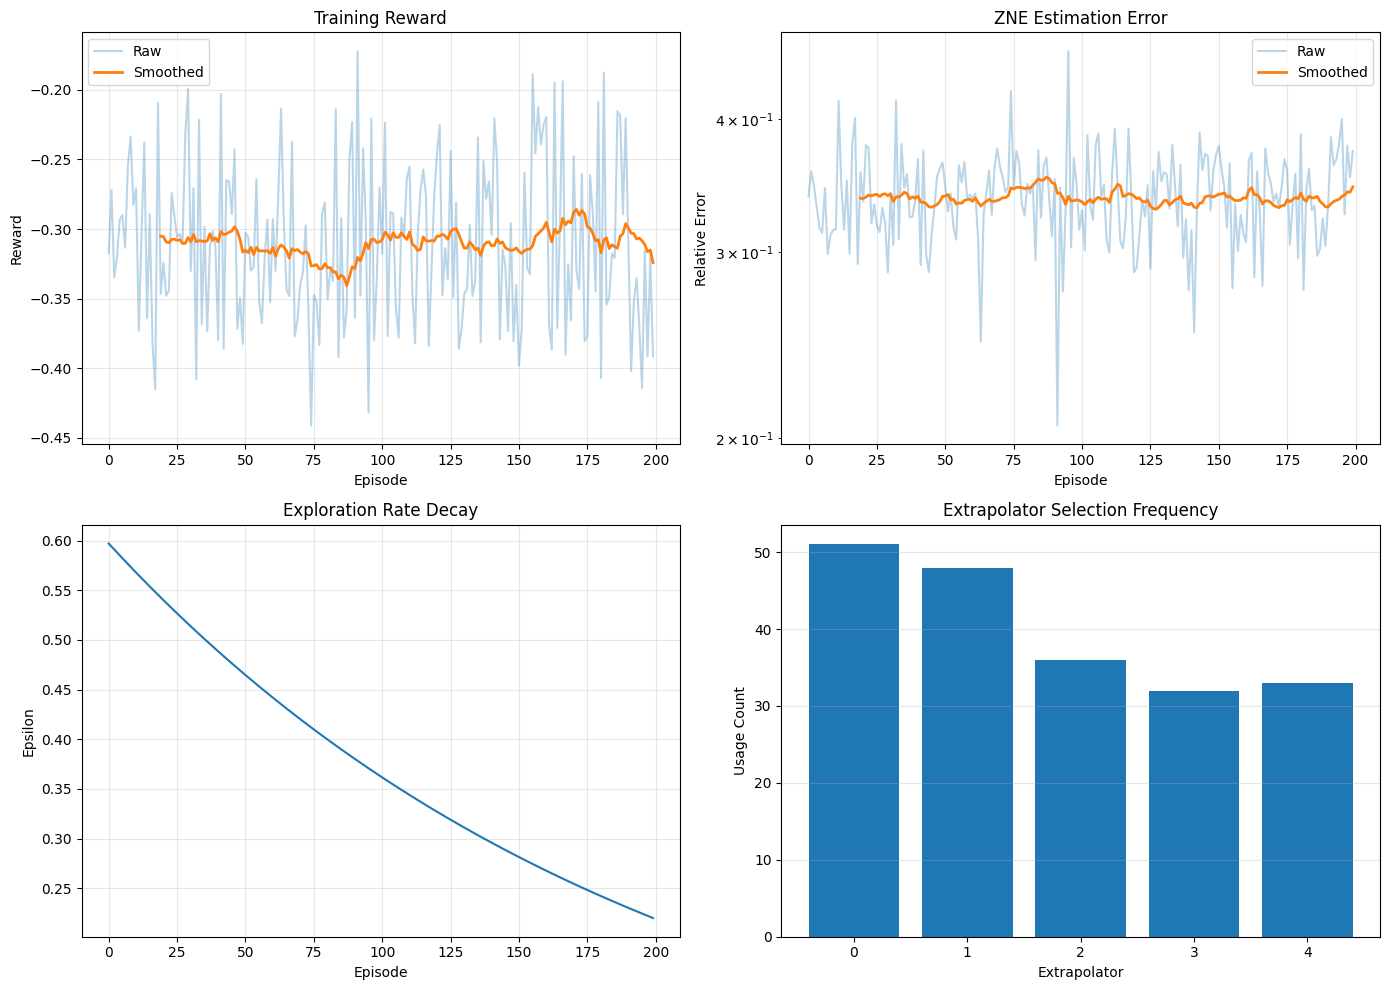

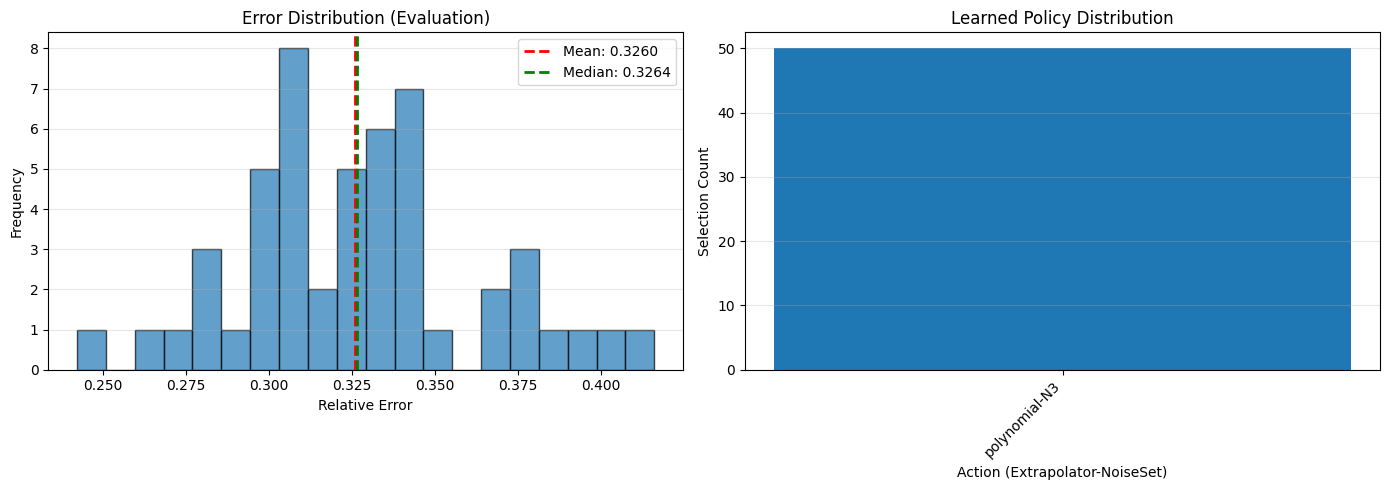

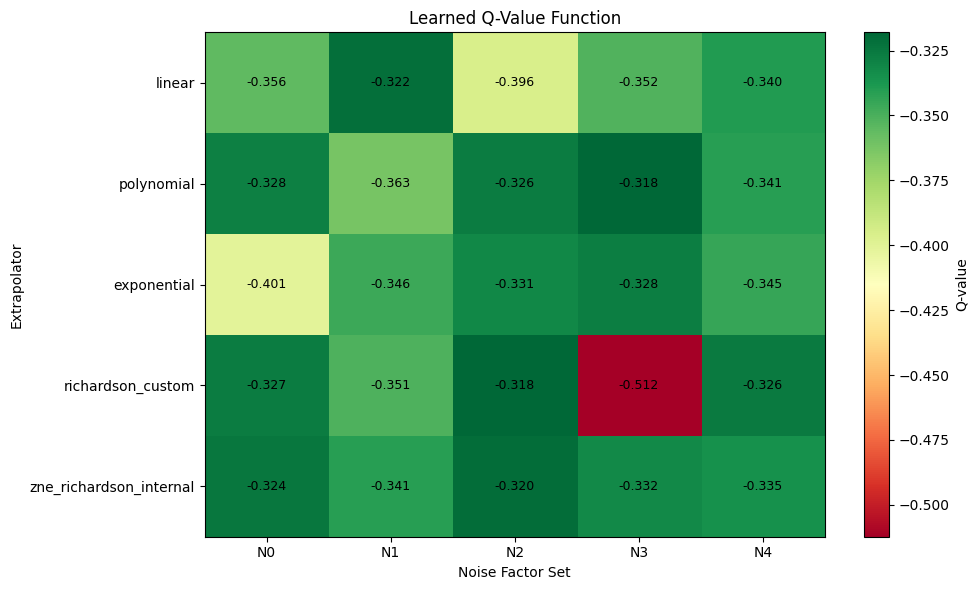

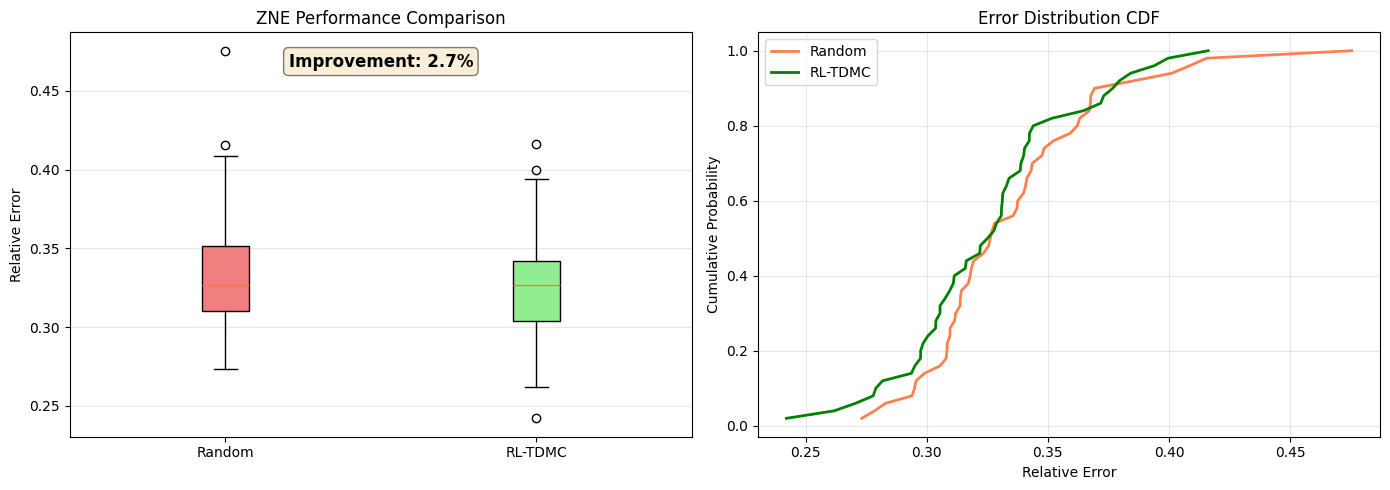


EXPERIMENT COMPLETE

Generated files:
  - fig1_training.png
  - fig2_evaluation.png
  - fig3_qtable.png
  - fig4_comparison.png

FULL EXPERIMENTAL PIPELINE

[TRAINING]


Training RL Agent:   0%|          | 0/200 [00:00<?, ?it/s]


[EVALUATION]


Evaluating RL Agent:   0%|          | 0/50 [00:00<?, ?it/s]


[BASELINE] Running random parameter selection...


Random Baseline:   0%|          | 0/50 [00:00<?, ?it/s]


STATISTICAL SUMMARY

RL-TDMC Agent:
  Mean relative error:    0.334233
  Median relative error: 0.331711
  Std relative error:     0.034532
  Min relative error:     0.237775
  Max relative error:     0.420903

Random Baseline:
  Mean relative error:    0.337253
  Median relative error: 0.328513
  Std relative error:     0.038149

Relative Improvement: 0.90%
Mann-Whitney U test p-value: 0.504125

[GENERATING FIGURES]


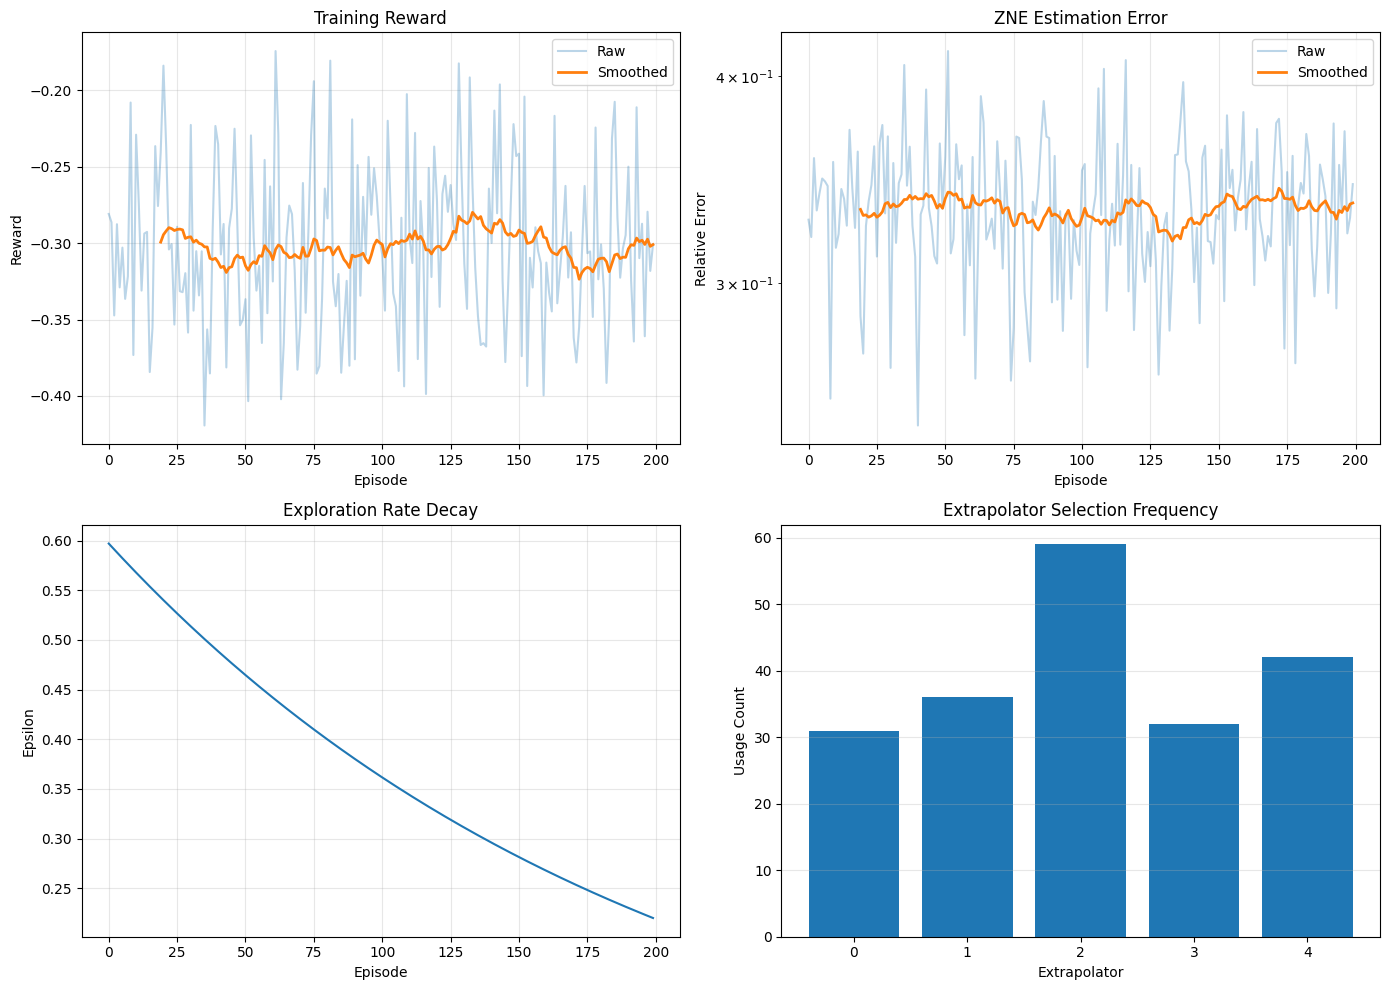

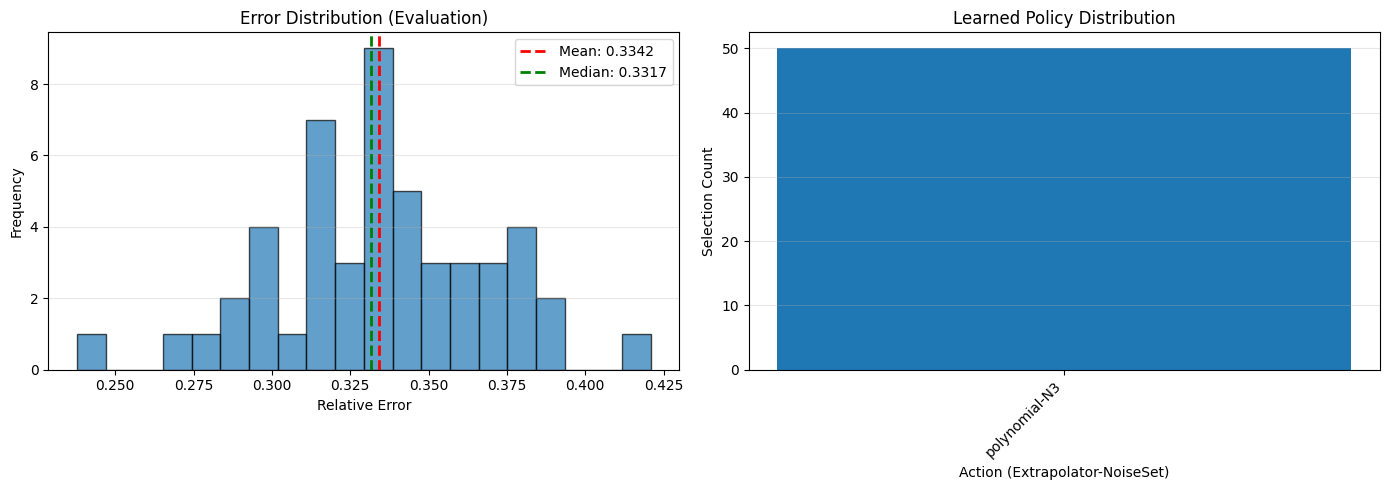

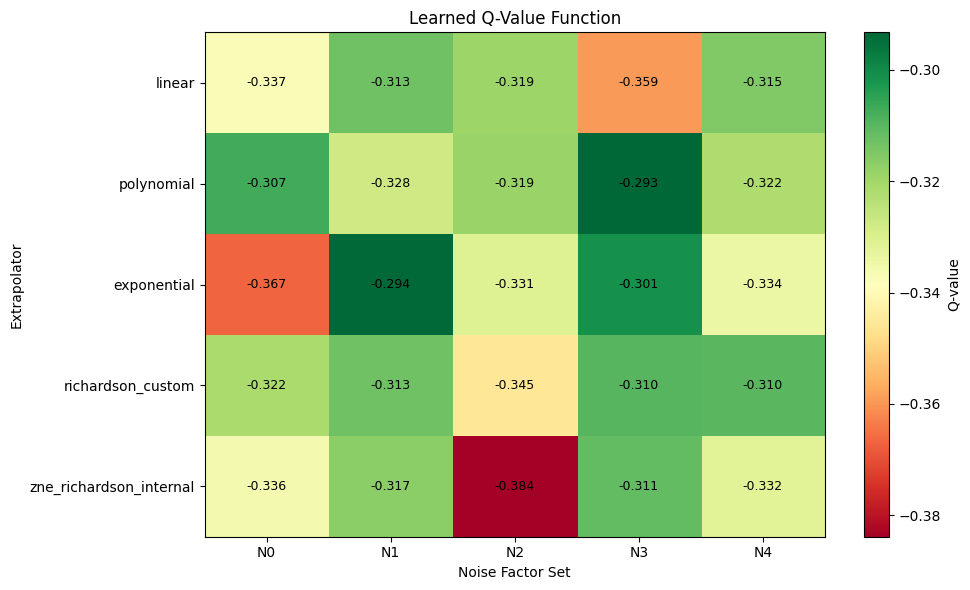

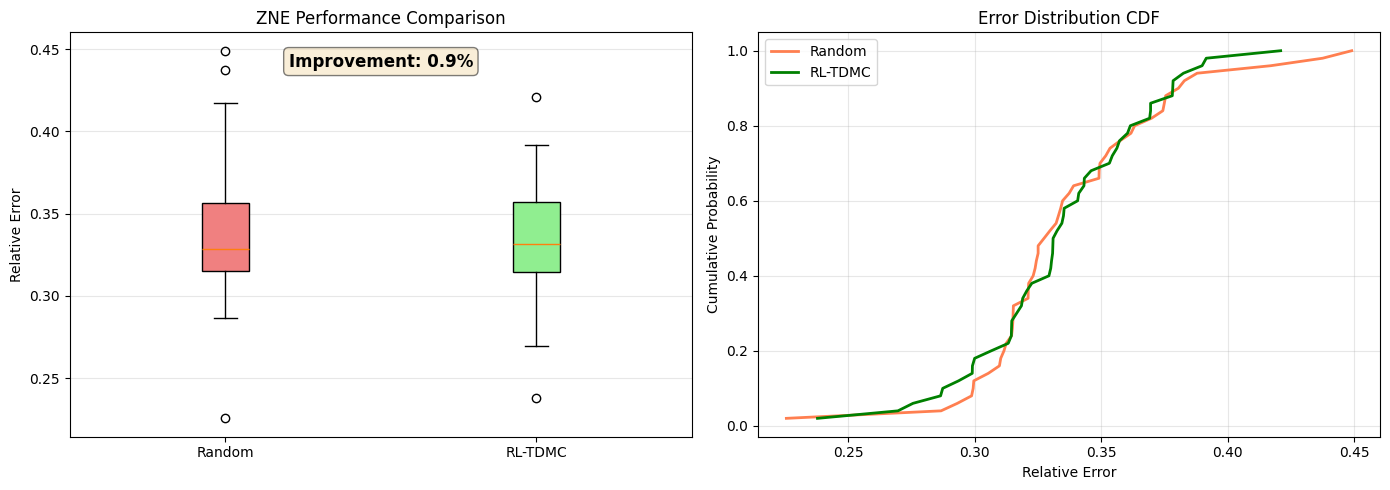


EXPERIMENT COMPLETE

Generated files:
  - fig1_training.png
  - fig2_evaluation.png
  - fig3_qtable.png
  - fig4_comparison.png

FULL EXPERIMENTAL PIPELINE

[TRAINING]


Training RL Agent:   0%|          | 0/200 [00:00<?, ?it/s]

Episode 0: ideal=0.998279, est=0.653665, lambdas=[1, 3, 5, 7], vals=[0.667969, 0.638672, 0.714844, 0.681641], action=23, reward=-0.300670
Episode 1: ideal=0.998279, est=0.687500, lambdas=[1, 3], vals=[0.673828, 0.646484], action=5, reward=-0.224515
Episode 2: ideal=0.998279, est=0.653702, lambdas=[1, 3, 5, 7], vals=[0.660156, 0.673828, 0.693359, 0.701172], action=23, reward=-0.366893
Episode 3: ideal=0.998279, est=0.708984, lambdas=[1, 3], vals=[0.699219, 0.679688], action=15, reward=-0.201021
Episode 4: ideal=0.998279, est=0.736084, lambdas=[1, 3, 5], vals=[0.6875, 0.638672, 0.654297], action=6, reward=-0.230836
Episode 5: ideal=0.998279, est=0.685547, lambdas=[1, 3], vals=[0.677734, 0.662109], action=20, reward=-0.225828
Episode 6: ideal=0.998279, est=0.702519, lambdas=[1, 2, 3, 5, 7], vals=[0.664062, 0.703125, 0.695312, 0.648438, 0.628906], action=4, reward=-0.248922
Episode 7: ideal=0.998279, est=0.701741, lambdas=[1, 2, 4, 6], vals=[0.705078, 0.673828, 0.679688, 0.664062], action=

Evaluating RL Agent:   0%|          | 0/50 [00:00<?, ?it/s]

Eval 0: ideal=0.998279, est=0.628255, lambdas=[1, 3, 5], vals=[0.636719, 0.660156, 0.675781], action=1
Eval 1: ideal=0.998279, est=0.638184, lambdas=[1, 3, 5], vals=[0.644531, 0.681641, 0.689453], action=1
Eval 2: ideal=0.998279, est=0.663900, lambdas=[1, 3, 5], vals=[0.654297, 0.685547, 0.65625], action=1
Eval 3: ideal=0.998279, est=0.667155, lambdas=[1, 3, 5], vals=[0.677734, 0.648438, 0.679688], action=1
Eval 4: ideal=0.998279, est=0.656413, lambdas=[1, 3, 5], vals=[0.648438, 0.669922, 0.646484], action=1
Eval 5: ideal=0.998279, est=0.630046, lambdas=[1, 3, 5], vals=[0.630859, 0.689453, 0.679688], action=1
Eval 6: ideal=0.998279, est=0.674967, lambdas=[1, 3, 5], vals=[0.673828, 0.621094, 0.628906], action=1
Eval 7: ideal=0.998279, est=0.694987, lambdas=[1, 3, 5], vals=[0.671875, 0.697266, 0.636719], action=1
Eval 8: ideal=0.998279, est=0.645020, lambdas=[1, 3, 5], vals=[0.654297, 0.628906, 0.65625], action=1
Eval 9: ideal=0.998279, est=0.676107, lambdas=[1, 3, 5], vals=[0.666016, 0.

Random Baseline:   0%|          | 0/50 [00:00<?, ?it/s]


STATISTICAL SUMMARY

RL-TDMC Agent:
  Mean relative error:    0.330583
  Median relative error: 0.327048
  Std relative error:     0.028719
  Min relative error:     0.278543
  Max relative error:     0.407020

Random Baseline:
  Mean relative error:    0.332178
  Median relative error: 0.333325
  Std relative error:     0.031268

Relative Improvement: 0.48%
Mann-Whitney U test p-value: 0.329532

[GENERATING FIGURES]


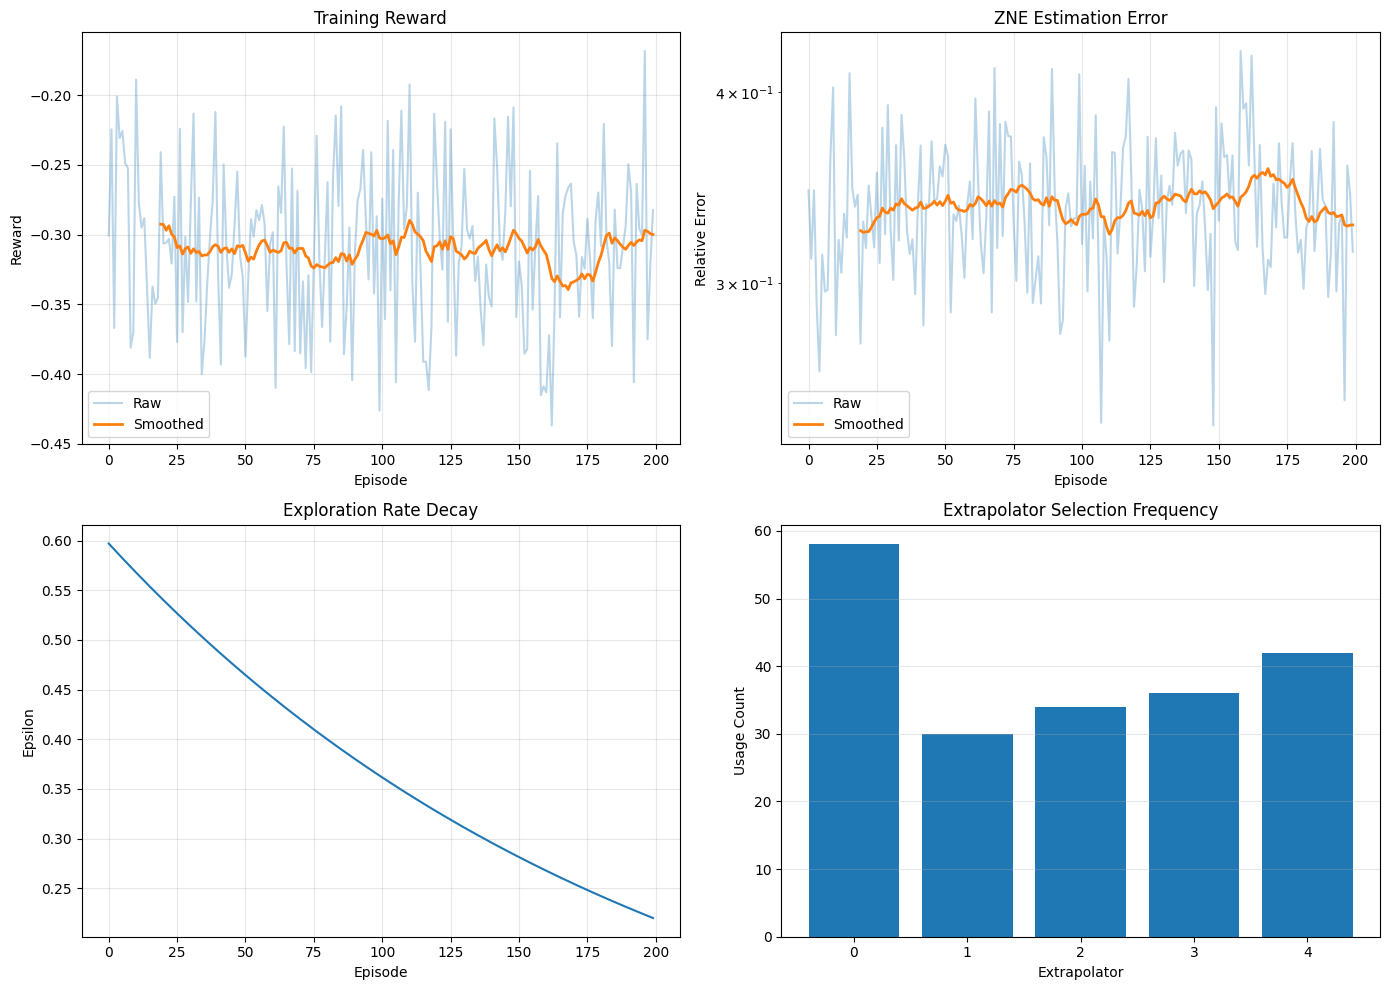

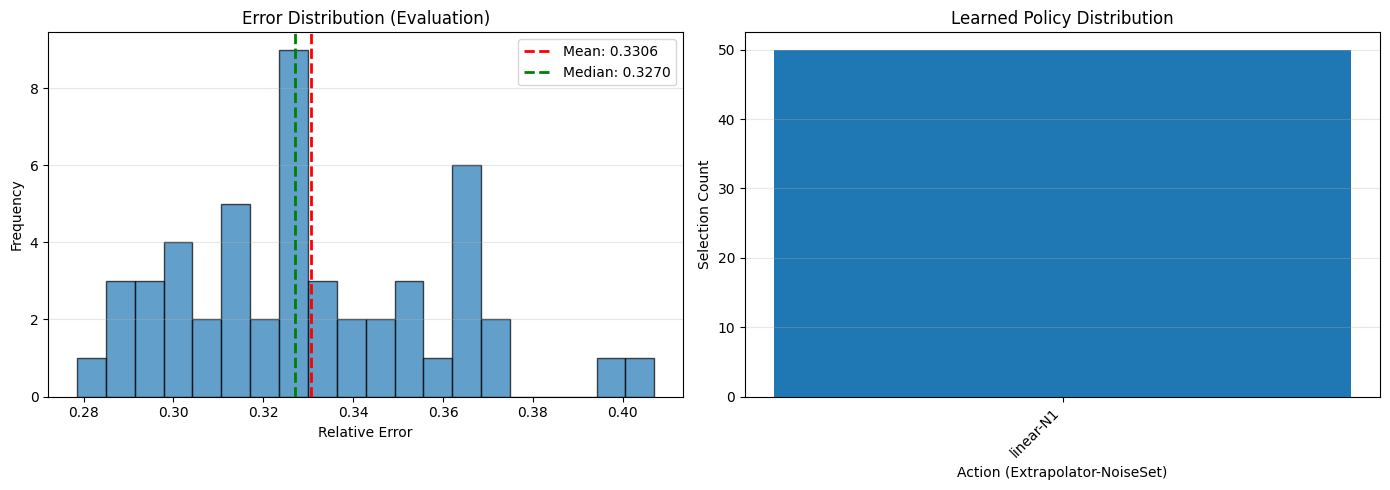

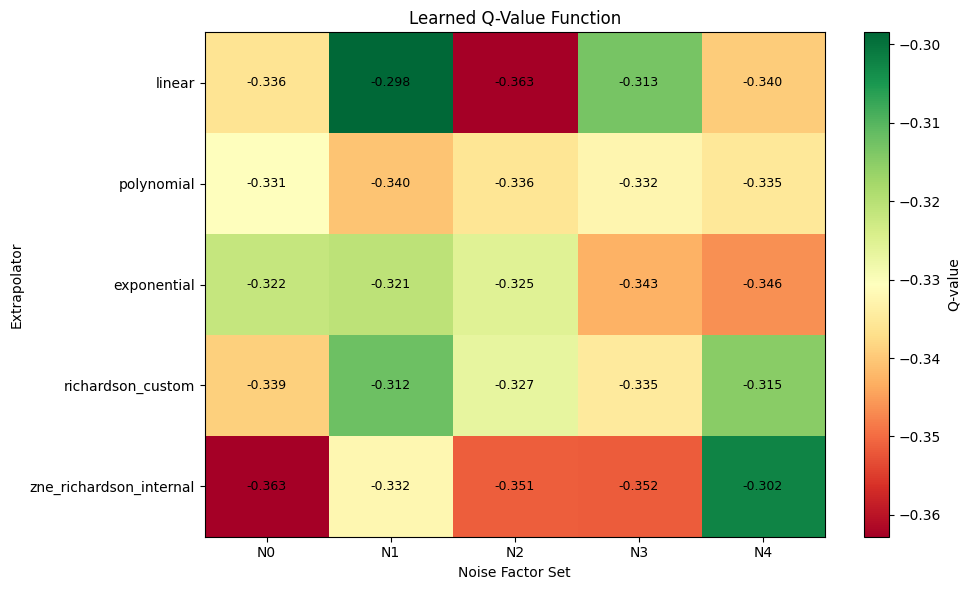

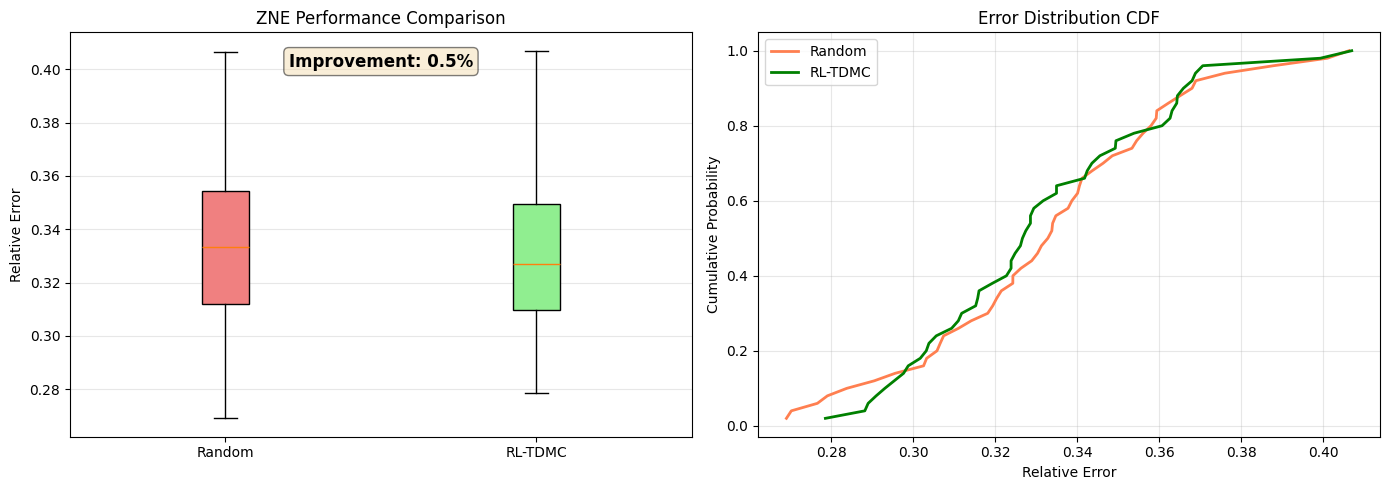


EXPERIMENT COMPLETE

Generated files:
  - fig1_training.png
  - fig2_evaluation.png
  - fig3_qtable.png
  - fig4_comparison.png


In [ ]:
import numpy as np
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
# Qiskit imports
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Any

# FIX: Import scipy.stats specifically as 'stats'
import scipy.stats as stats

# Qiskit and Noise/Primitives
from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi # We need noise!
from qiskit.quantum_info import SparsePauliOp

# ZNE Library
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

# Utilities
from tqdm.auto import tqdm
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi
# ZNE imports
from zne import zne, ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
warnings.filterwarnings('ignore')

# ============================================================================
## PART 1: EXTRAPOLATION FUNCTIONS (Updated)
# ============================================================================
def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Linear extrapolation to zero noise: f(λ) = aλ + b, return f(0) = b"""
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[1])

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Quadratic extrapolation: f(λ) = aλ² + bλ + c, return f(0) = c"""
    if len(lambdas) < 3:
        return linear_extrapolate(lambdas, values)
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Exponential extrapolation: f(λ) = b*exp(-cλ), return f(0) = b"""
    lambdas = np.array(lambdas)
    values = np.array(values)

    # Handle non-positive values
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift

    if len(lambdas) == 1:
        return float(values[0] - shift)

    try:
        # Fit ln(f) = ln(b) - cλ
        coefs = np.polyfit(lambdas, np.log(values), 1)
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

def richardson_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Richardson extrapolation for noise amplification (Custom implementation)"""
    if len(lambdas) < 2:
        return values[0]

    lambdas = np.array(lambdas)
    values = np.array(values)

    # Richardson's formula for first order
    if len(lambdas) == 2:
        l1, l2 = lambdas
        v1, v2 = values
        return (l2*v1 - l1*v2) / (l2 - l1)

    # Use polynomial for more points
    return poly2_extrapolate(lambdas, values)

def zne_internal_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """
    Placeholder: This function is not called directly.
    It signals the ZNEEnvironment.step method to use the internal ZNEStrategy
    extrapolator.
    """
    raise NotImplementedError("This is a placeholder and should not be executed.")

# Extrapolator registry
EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("polynomial", poly2_extrapolate),
    2: ("exponential", exponential_extrapolate),
    3: ("richardson_custom", richardson_extrapolate),
    4: ("zne_richardson_internal", zne_internal_extrapolate), # <--- NEW ENTRY
}

# ============================================================================
## PART 2: CIRCUIT GENERATORS
# ============================================================================
def generate_xyz_hamiltonian(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """
    Generate XYZ/TFIM Hamiltonian: H = Σ_i [J_x X_i X_{i+1} + ...] + Σ_i [h_x X_i + ...]
    """
    terms, coeffs = [], []

    # Two-qubit interactions
    for i in range(n_qubits - 1):
        for pauli, coupling in [("X", Jx), ("Y", Jy), ("Z", Jz)]:
            if abs(coupling) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i + 1] = pauli
                terms.append("".join(p))
                coeffs.append(coupling)

    # Single-qubit fields
    for i in range(n_qubits):
        for pauli, field in [("X", hx), ("Y", hy), ("Z", hz)]:
            if abs(field) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i] = pauli
                terms.append("".join(p))
                coeffs.append(field)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))

def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
) -> QuantumCircuit:
    """Build Trotterized time evolution circuit"""
    H = generate_xyz_hamiltonian(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    evo_gate = PauliEvolutionGate(
        H, time=dt, synthesis=SuzukiTrotter(reps=1)
    )

    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    return qc

def expand_observable(base: str, n_qubits: int) -> SparsePauliOp:
    """Expand observable like 'ZZ' to match circuit size 'ZZI...'"""
    if len(base) > n_qubits:
        raise ValueError(f"Observable {base} too large for {n_qubits} qubits")
    if len(base) == n_qubits:
        return SparsePauliOp(base)
    padding = "I" * (n_qubits - len(base))
    return SparsePauliOp(base + padding)

# ============================================================================
## PART 3: ZNE ENVIRONMENT (Updated)
# ============================================================================
@dataclass
class ZNEEnvironment:
    """
    Quantum environment for ZNE parameter optimization.

    The environment generates quantum circuits, executes ZNE with chosen parameters,
    and returns rewards based on estimation accuracy.
    """
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    # Action space: combinations of extrapolators and noise factor sets
    NOISE_FACTOR_SETS = [
        [1, 3],             # Minimal: fast but less accurate
        [1, 3, 5],          # Standard: balanced
        [1, 2, 4, 6],       # Dense sampling: more data points
        [1, 3, 5, 7],       # Extended range: better for high noise
        [1, 2, 3, 5, 7],    # Comprehensive: most expensive
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self) -> np.ndarray:
        """Reset environment with new circuit"""
        self.circuit = self.circuit_generator()
        n_qubits = self.circuit.num_qubits

        # Expand observable to match circuit size
        self.observable = expand_observable(self.base_observable, n_qubits)

        # Setup backend
        self.backend = FakeNairobi()
        ZNEEstimator = zne(BackendEstimator)
        self.estimator = ZNEEstimator(backend=self.backend)

        # Compute ideal value once
        self.ideal_value = Estimator().run(
            self.circuit, self.observable
        ).result().values[0]

        return self._get_observation()

    def _get_observation(self) -> np.ndarray:
        """Extract features from current circuit"""
        features = [
            self.circuit.depth(),
            self.circuit.num_qubits,
            self.circuit.count_ops().get('cx', 0),  # Two-qubit gate count
            self.circuit.size(),  # Total gate count
        ]
        return np.array(features, dtype=np.float32)

    def step(self, action: Tuple[int, int]) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Execute ZNE with selected parameters.

        Args:
            action: (extrapolator_id, noise_set_id)

        Returns:
            observation, reward, done, info
        """
        extrap_id, noise_id = action

        extrap_name, extrap_fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]

        # Determine if we use the ZNE-internal extrapolator
        # ID 4 is the new 'zne_richardson_internal' option
        USE_ZNE_INTERNAL = (extrap_id == 4)

        # Build ZNE strategy
        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            # Use RichardsonExtrapolator internally if selected, otherwise set to None
            # so we can perform custom extrapolation later.
            extrapolator=PolynomialExtrapolator(degree=1)
        )

        # Execute noisy experiments
        job = self.estimator.run(
            self.circuit,
            self.observable,
            zne_strategy=strategy
        )
        result = job.result()

        # --- ZNE Result Processing ---

        # Extract metadata common to all
        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])

        if USE_ZNE_INTERNAL:
            # The result object already contains the final extrapolated value
            # because we passed the extrapolator in the ZNEStrategy.
            zne_estimate = result.values[0]
        else:
            # Apply selected custom extrapolation
            try:
                zne_estimate = extrap_fn(lambdas, noisy_values)
            except Exception as e:
                print(f"Extrapolation failed: {e}")
                zne_estimate = noisy_values[0]

        # --- Reward Calculation ---

        # Compute reward with multiple components
        error = abs(zne_estimate - self.ideal_value)
        relative_error = error / (abs(self.ideal_value) + 1e-10)

        # Reward shaping
        base_reward = -relative_error

        # Bonus for monotonic decay (good noise amplification)
        if len(noisy_values) > 1:
            diffs = np.diff(noisy_values)
            monotonic_score = np.mean(diffs <= 0)  # 1.0 if perfectly decreasing
            monotonic_bonus = 0.1 * monotonic_score
        else:
            monotonic_bonus = 0.0

        # Penalty for high variance (unstable estimates)
        variance_penalty = -0.05 * np.mean(variances)

        # Efficiency bonus (fewer noise factors = faster)
        efficiency_bonus = 0.02 * (5 - len(noise_factors)) / 4

        total_reward = base_reward + monotonic_bonus + variance_penalty + efficiency_bonus

        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": relative_error,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": extrap_name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base_reward,
            "monotonic_bonus": monotonic_bonus,
            "variance_penalty": variance_penalty,
            "efficiency_bonus": efficiency_bonus,
        }

        return self._get_observation(), total_reward, True, info

# ============================================================================
# ============================================================================
## PART 4: TEMPORAL DIFFERENCE MONTE CARLO (TDMC) AGENT (FIXED)
# ============================================================================
class TDMCAgent:
    """
    Temporal Difference Monte Carlo (TDMC) Agent for learning ZNE policy.
    This is a Q-Learning-like agent but updates the Q-table based on immediate reward.
    """
    def __init__(
        self,
        n_extrapolators: int,
        n_noise_sets: int,
        learning_rate: float = 0.2,
        discount_factor: float = 0.95,
        epsilon: float = 0.6,  # FIX: Higher initial exploration
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.05,
        trace_decay: float = 0.7,
    ):
        """
        Initialize TDMC agent.
        """
        self.n_extrapolators = n_extrapolators
        self.n_noise_sets = n_noise_sets
        self.n_actions = n_extrapolators * n_noise_sets

        # FIX: Initialize Q-table with small random values for symmetry breaking
        self.Q = np.random.randn(n_extrapolators, n_noise_sets) * 0.01

        # Eligibility traces for TD(λ)
        self.E = np.zeros_like(self.Q)

        # Hyperparameters
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambda_trace = trace_decay

        # Statistics
        self.action_counts = np.zeros_like(self.Q)
        self.total_steps = 0

    def select_action(self, exploration: bool = True) -> Tuple[int, int]:
        """
        Select action using epsilon-greedy policy.
        """
        if exploration and np.random.rand() < self.epsilon:
            # FIX: Pure random exploration
            extrap_id = np.random.randint(self.n_extrapolators)
            noise_id = np.random.randint(self.n_noise_sets)
        else:
            # Exploit: best known action
            extrap_id, noise_id = np.unravel_index(
                np.argmax(self.Q), self.Q.shape
            )

        return extrap_id, noise_id

    def update(
        self,
        action: Tuple[int, int],
        reward: float,
        info: Dict[str, Any],
    ):
        """
        Update Q-values using TD(λ) with eligibility traces.
        """
        i, j = action
        self.action_counts[i, j] += 1
        self.total_steps += 1

        # TD error: δ = R - Q(s,a)
        td_error = reward - self.Q[i, j]

        # Update eligibility trace for this action
        self.E[i, j] += 1.0

        # TD(λ) update: Q += α * δ * E
        self.Q += self.alpha * td_error * self.E

        # Decay eligibility traces
        self.E *= self.gamma * self.lambda_trace

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self) -> np.ndarray:
        """Return current greedy policy as probability distribution"""
        policy = np.zeros_like(self.Q)
        best_action = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        policy[best_action] = 1.0
        return policy

    def get_value_function(self) -> np.ndarray:
        """Return state-action value function"""
        return self.Q.copy()

# ============================================================================
## PART 5: TRAINING LOOP (FIXED)
# ============================================================================
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 200,
    verbose: bool = True,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Train TDMC agent on ZNE parameter selection.
    """
    history = {
        "rewards": [],
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [],
        "n_noise_factors": [],
        "epsilons": [],
    }

    iterator = tqdm(range(n_episodes), desc="Training RL Agent") if verbose else range(n_episodes)

    for episode in iterator:
        # FIX: Reset environment (generates NEW circuit each time)
        obs = env.reset()

        # Select action with exploration
        action = agent.select_action(exploration=True)

        # Execute action
        next_obs, reward, done, info = env.step(action)

        # Update agent
        agent.update(action, reward, info)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # Detailed logging
        if detailed_log:
            print(f"Episode {episode}: ideal={info['ideal']:.6f}, est={info['estimate']:.6f}, " +
                  f"lambdas={info['lambdas']}, vals={np.round(info['noisy_values'], 6)}, " +
                  f"action={combined_action_id}, reward={reward:.6f}")

        # Record history
        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id)
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)

        # Progress update
        if len(history["relative_errors"]) >= 20:
            avg_rel_error = np.mean(history["relative_errors"][-20:])
            if verbose:
                iterator.set_postfix({
                    "Avg Rel Error (last 20)": f"{avg_rel_error:.4f}",
                    "Epsilon": f"{agent.epsilon:.3f}"
                })

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Evaluate trained agent (no exploration).
    """
    results = {
        "errors": [],
        "relative_errors": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [],
        "estimates": [],
        "ideal_values": [],
    }

    for ep in tqdm(range(n_episodes), desc="Evaluating RL Agent"):
        # FIX: Reset generates NEW circuit each evaluation
        obs = env.reset()

        # Exploit: select the best action based on the learned Q-table
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # Detailed logging
        if detailed_log:
            print(f"Eval {ep}: ideal={info['ideal']:.6f}, est={info['estimate']:.6f}, " +
                  f"lambdas={info['lambdas']}, vals={np.round(info['noisy_values'], 6)}, " +
                  f"action={combined_action_id}")

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id)
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])

    return results

# ============================================================================
## PART 6: VISUALIZATION
# ============================================================================
def plot_training_results(history: Dict[str, List], save_path: str = None):
    """Plot training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Reward curve
    ax = axes[0, 0]
    rewards = history["rewards"]
    ax.plot(rewards, alpha=0.3, label="Raw")
    window = 20
    if len(rewards) > window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Training Reward")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Relative error
    ax = axes[0, 1]
    rel_errors = history["relative_errors"]
    ax.plot(rel_errors, alpha=0.3, label="Raw")
    if len(rel_errors) > window:
        smoothed = np.convolve(rel_errors, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rel_errors)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Estimation Error")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Exploration rate
    ax = axes[1, 0]
    ax.plot(history["epsilons"])
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.set_title("Exploration Rate Decay")
    ax.grid(True, alpha=0.3)

    # Extrapolator usage
    ax = axes[1, 1]
    from collections import Counter
    extrap_counts = Counter(history["extrapolators"])
    ax.bar(extrap_counts.keys(), extrap_counts.values())
    ax.set_xlabel("Extrapolator")
    ax.set_ylabel("Usage Count")
    ax.set_title("Extrapolator Selection Frequency")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_evaluation_results(results: Dict[str, List], save_path: str = None):
    """Plot evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Error distribution
    ax = axes[0]
    rel_errors = results["relative_errors"]
    ax.hist(rel_errors, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(rel_errors), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {np.mean(rel_errors):.4f}')
    ax.axvline(np.median(rel_errors), color='green', linestyle='--',
               linewidth=2, label=f'Median: {np.median(rel_errors):.4f}')
    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Frequency")
    ax.set_title("Error Distribution (Evaluation)")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Action distribution
    ax = axes[1]
    from collections import Counter
    action_counts = Counter(results["actions"])
    extrap_map = {i: EXTRAPOLATORS[i][0].split('_')[0] for i in EXTRAPOLATORS}
    action_labels = [f"{extrap_map[e]}-N{n}" for e, n in
                     [(a // len(ZNEEnvironment.NOISE_FACTOR_SETS),
                       a % len(ZNEEnvironment.NOISE_FACTOR_SETS)) for a in action_counts.keys()]]
    ax.bar(range(len(action_counts)), action_counts.values())
    ax.set_xticks(range(len(action_counts)))
    ax.set_xticklabels(action_labels, rotation=45, ha='right')
    ax.set_xlabel("Action (Extrapolator-NoiseSet)")
    ax.set_ylabel("Selection Count")
    ax.set_title("Learned Policy Distribution")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_q_table(agent: TDMCAgent, save_path: str = None):
    """Visualize learned Q-values"""
    fig, ax = plt.subplots(figsize=(10, 6))

    im = ax.imshow(agent.Q, cmap='RdYlGn', aspect='auto')

    # Set ticks
    ax.set_xticks(range(agent.Q.shape[1]))
    ax.set_yticks(range(agent.Q.shape[0]))

    # Labels
    noise_labels = [f"N{i}" for i in range(agent.Q.shape[1])]
    extrap_labels = [EXTRAPOLATORS[i][0] for i in range(agent.Q.shape[0])]

    ax.set_xticklabels(noise_labels)
    ax.set_yticklabels(extrap_labels)

    # Annotate cells with Q-values
    for i in range(agent.Q.shape[0]):
        for j in range(agent.Q.shape[1]):
            text = ax.text(j, i, f'{agent.Q[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)

    ax.set_xlabel("Noise Factor Set")
    ax.set_ylabel("Extrapolator")
    ax.set_title("Learned Q-Value Function")

    plt.colorbar(im, ax=ax, label="Q-value")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 7: BASELINE COMPARISON
# ============================================================================
def baseline_comparison(env: ZNEEnvironment, n_trials: int = 50):
    """
    Compare RL-selected parameters against random baseline.
    """
    print("\n[BASELINE] Running random parameter selection...")

    random_results = {
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
    }

    for _ in tqdm(range(n_trials), desc="Random Baseline"):
        env.reset()

        # Random action
        extrap_id = np.random.randint(len(EXTRAPOLATORS))
        noise_id = np.random.randint(len(env.NOISE_FACTOR_SETS))
        action = (extrap_id, noise_id)

        _, reward, _, info = env.step(action)

        random_results["errors"].append(info["error"])
        random_results["relative_errors"].append(info["relative_error"])
        random_results["estimates"].append(info["estimate"])
        random_results["ideal_values"].append(info["ideal"])

    return random_results

def plot_comparison(rl_results: Dict, baseline_results: Dict, save_path: str = None):
    """Plot RL vs baseline comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Box plot comparison
    ax = axes[0]
    data = [baseline_results["relative_errors"], rl_results["relative_errors"]]
    bp = ax.boxplot(data, labels=["Random", "RL-TDMC"], patch_artist=True)

    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightgreen')

    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Performance Comparison")
    ax.grid(True, alpha=0.3, axis='y')

    # Add statistical annotations
    rl_mean = np.mean(rl_results["relative_errors"])
    baseline_mean = np.mean(baseline_results["relative_errors"])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    ax.text(0.5, 0.95, f"Improvement: {improvement:.1f}%",
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=12, fontweight='bold')

    # Cumulative distribution
    ax = axes[1]

    baseline_sorted = np.sort(baseline_results["relative_errors"])
    rl_sorted = np.sort(rl_results["relative_errors"])

    baseline_cdf = np.arange(1, len(baseline_sorted) + 1) / len(baseline_sorted)
    rl_cdf = np.arange(1, len(rl_sorted) + 1) / len(rl_sorted)

    ax.plot(baseline_sorted, baseline_cdf, label="Random", linewidth=2, color='coral')
    ax.plot(rl_sorted, rl_cdf, label="RL-TDMC", linewidth=2, color='green')

    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Error Distribution CDF")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 8: MAIN EXPERIMENT
# ============================================================================
def main():
    """Run complete RL-based ZNE experiment"""

    print("="*70)
    print("RL-BASED ZERO NOISE EXTRAPOLATION PARAMETER SELECTION")
    print("="*70)

    # Define circuit generator (TFIM Hamiltonian)
    def tfim_circuit_generator():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Create environment
    print("\n[1] Creating ZNE environment...")
    env = ZNEEnvironment(
        circuit_generator=tfim_circuit_generator,
        base_observable="ZZ",
        backend_name="FakeNairobi"
    )

    # Create agent
    print("[2] Initializing TDMC agent...")
    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.2,
        discount_factor=0.95,
        epsilon=0.6,
        epsilon_decay=0.995,
        epsilon_min=0.05,
        trace_decay=0.7,
    )

    # Training
    print("[3] Training agent...")
    history = train_agent(
        env=env,
        agent=agent,
        n_episodes=200,
        verbose=True
    )

    # Evaluation
    print("\n[4] Evaluating trained agent...")
    eval_results = evaluate_agent(
        env=env,
        agent=agent,
        n_episodes=50
    )

    # Print results
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print("\nTraining Performance:")
    print(f"  Final 20-episode avg reward: {np.mean(history['rewards'][-20:]):.4f}")
    print(f"  Final 20-episode avg rel error: {np.mean(history['relative_errors'][-20:]):.4f}")

    print("\nEvaluation Performance:")
    print(f"  Mean relative error: {np.mean(eval_results['relative_errors']):.4f}")
    print(f"  Median relative error: {np.median(eval_results['relative_errors']):.4f}")
    print(f"  Std relative error: {np.std(eval_results['relative_errors']):.4f}")

    print("\nLearned Policy:")
    best_action = np.unravel_index(np.argmax(agent.Q), agent.Q.shape)
    best_extrap = EXTRAPOLATORS[best_action[0]][0]
    best_noise = env.NOISE_FACTOR_SETS[best_action[1]]
    print(f"  Best extrapolator: {best_extrap}")
    print(f"  Best noise factors: {best_noise}")
    print(f"  Q-value: {agent.Q[best_action]:.4f}")

    # Visualization
    print("\n[5] Generating visualizations...")
    plot_training_results(history, save_path="training_results.png")
    plot_evaluation_results(eval_results, save_path="evaluation_results.png")
    visualize_q_table(agent, save_path="q_table.png")

    print("\n" + "="*70)
    print("Experiment complete! Figures saved.")
    print("="*70)

    return history, eval_results, agent

# ============================================================================
## PART 9: PUBLICATION-READY EXPERIMENT SUITE
# ============================================================================
def run_full_experiment():
    """
    Complete experimental pipeline for publication.
    """

    print("\n" + "="*70)
    print("FULL EXPERIMENTAL PIPELINE")
    print("="*70)

    # Circuit generator
    def circuit_gen():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Setup
    env = ZNEEnvironment(
        circuit_generator=circuit_gen,
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.2,
        epsilon=0.6,
        epsilon_decay=0.995,
    )

    # Train
    print("\n[TRAINING]")
    history = train_agent(env, agent, n_episodes=200, verbose=True)

    # Evaluate
    print("\n[EVALUATION]")
    rl_results = evaluate_agent(env, agent, n_episodes=50)

    # Baseline
    baseline_results = baseline_comparison(env, n_trials=50)

    # Statistics
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY")
    print("="*70)

    print("\nRL-TDMC Agent:")
    print(f"  Mean relative error:    {np.mean(rl_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(rl_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(rl_results['relative_errors']):.6f}")
    print(f"  Min relative error:     {np.min(rl_results['relative_errors']):.6f}")
    print(f"  Max relative error:     {np.max(rl_results['relative_errors']):.6f}")

    print("\nRandom Baseline:")
    print(f"  Mean relative error:    {np.mean(baseline_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(baseline_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(baseline_results['relative_errors']):.6f}")

    # Improvement metrics
    rl_mean = np.mean(rl_results['relative_errors'])
    baseline_mean = np.mean(baseline_results['relative_errors'])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    print(f"\nRelative Improvement: {improvement:.2f}%")

    # Statistical significance (Mann-Whitney U test)
    statistic, p_value = stats.mannwhitneyu(
        baseline_results['relative_errors'],
        rl_results['relative_errors'],
        alternative='greater'
    )
    print(f"Mann-Whitney U test p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Improvement is statistically significant (p < 0.05)")

    # Visualizations
    print("\n[GENERATING FIGURES]")
    plot_training_results(history, "fig1_training.png")
    plot_evaluation_results(rl_results, "fig2_evaluation.png")
    visualize_q_table(agent, "fig3_qtable.png")
    plot_comparison(rl_results, baseline_results, "fig4_comparison.png")

    print("\n" + "="*70)
    print("EXPERIMENT COMPLETE")
    print("="*70)
    print("\nGenerated files:")
    print("  - fig1_training.png")
    print("  - fig2_evaluation.png")
    print("  - fig3_qtable.png")
    print("  - fig4_comparison.png")

    return history, rl_results, agent

# ============================================================================
# PART 10: MULTI-CIRCUIT GENERALIZATION TEST
# ============================================================================
def test_generalization():
    """
    Test learned policy across different circuit types.
    """
    print("\n" + "="*70)
    print("GENERALIZATION TEST")
    print("="*70)

    # Define multiple circuit generators
    circuit_configs = [
        {
            "name": "TFIM-small",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7
            ),
        },
        {
            "name": "TFIM-medium",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=3, dt=0.1, Jx=0.5, hz=0.8
            ),
        },
        {
            "name": "TFIM-large",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=5, trotter_steps=2, dt=0.15, Jx=0.6, hz=0.9
            ),
        },
        {
            "name": "Heisenberg",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=2, dt=0.1,
                Jx=0.4, Jy=0.4, Jz=0.4
            ),
        },
    ]

    # Train on first circuit type
    print("\n[TRAINING] on TFIM-small...")
    env = ZNEEnvironment(
        circuit_generator=circuit_configs[0]["generator"],
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
    )

    history = train_agent(env, agent, n_episodes=150, verbose=False)

    # Test on all circuit types
    print("\n[TESTING] across different circuits...")
    results = {}

    for config in circuit_configs:
        print(f"\n  Testing on {config['name']}...")
        test_env = ZNEEnvironment(
            circuit_generator=config["generator"],
            base_observable="ZZ"
        )

        eval_results = evaluate_agent(test_env, agent, n_episodes=30)

        results[config["name"]] = {
            "mean_error": np.mean(eval_results["relative_errors"]),
            "std_error": np.std(eval_results["relative_errors"]),
        }

        print(f"    Mean relative error: {results[config['name']]['mean_error']:.6f}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    names = list(results.keys())
    means = [results[n]["mean_error"] for n in names]
    stds = [results[n]["std_error"] for n in names]

    x = np.arange(len(names))
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')

    # Color the training circuit differently
    bars[0].set_color('lightgreen')
    bars[0].set_label('Training circuit')
    for i in range(1, len(bars)):
        bars[i].set_color('lightcoral')
    bars[1].set_label('Test circuits')

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel("Mean Relative Error")
    ax.set_title("Policy Generalization Across Circuit Types")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("fig5_generalization.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("GENERALIZATION TEST COMPLETE")
    print("="*70)

    return results

# ============================================================================
# EXECUTION
# ============================================================================
if __name__ == "__main__":
    run_full_experiment()
# ============================================================================
## PART 5: TRAINING LOOP (FIXED)
# ============================================================================
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 200,
    verbose: bool = True,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Train TDMC agent on ZNE parameter selection.
    """
    history = {
        "rewards": [],
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [],
        "n_noise_factors": [],
        "epsilons": [],
    }

    iterator = tqdm(range(n_episodes), desc="Training RL Agent") if verbose else range(n_episodes)

    for episode in iterator:
        # FIX: Reset environment (generates NEW circuit each time)
        obs = env.reset()

        # Select action with exploration
        action = agent.select_action(exploration=True)

        # Execute action
        next_obs, reward, done, info = env.step(action)

        # Update agent
        agent.update(action, reward, info)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # Detailed logging
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6)
            ))

        # Record history
        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id)
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)

        # Progress update
        if len(history["relative_errors"]) >= 20:
            avg_rel_error = np.mean(history["relative_errors"][-20:])
            if verbose:
                iterator.set_postfix({
                    "Avg Rel Error (last 20)": f"{avg_rel_error:.4f}",
                    "Epsilon": f"{agent.epsilon:.3f}"
                })

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """
    Evaluate trained agent (no exploration).
    """
    results = {
        "errors": [],
        "relative_errors": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [],
        "estimates": [],
        "ideal_values": [],
    }

    for ep in tqdm(range(n_episodes), desc="Evaluating RL Agent"):
        # FIX: Reset generates NEW circuit each evaluation
        obs = env.reset()

        # Exploit: select the best action based on the learned Q-table
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # Detailed logging
        if detailed_log:
            log_data = {
                "ideal": info["ideal"],
                "est": info["estimate"],
                "lambdas": info["lambdas"],
                "vals": np.array(info["noisy_values"]),
            }
            print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}".format(
                log_data["ideal"],
                log_data["est"],
                log_data["lambdas"],
                np.round(log_data["vals"], 6)
            ))

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id)
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])

    return results

# ============================================================================
## PART 6: VISUALIZATION
# ============================================================================
def plot_training_results(history: Dict[str, List], save_path: str = None):
    """Plot training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Reward curve
    ax = axes[0, 0]
    rewards = history["rewards"]
    ax.plot(rewards, alpha=0.3, label="Raw")
    window = 20
    if len(rewards) > window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Training Reward")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Relative error
    ax = axes[0, 1]
    rel_errors = history["relative_errors"]
    ax.plot(rel_errors, alpha=0.3, label="Raw")
    if len(rel_errors) > window:
        smoothed = np.convolve(rel_errors, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rel_errors)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Estimation Error")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Exploration rate
    ax = axes[1, 0]
    ax.plot(history["epsilons"])
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.set_title("Exploration Rate Decay")
    ax.grid(True, alpha=0.3)

    # Extrapolator usage
    ax = axes[1, 1]
    from collections import Counter
    extrap_counts = Counter(history["extrapolators"])
    ax.bar(extrap_counts.keys(), extrap_counts.values())
    ax.set_xlabel("Extrapolator")
    ax.set_ylabel("Usage Count")
    ax.set_title("Extrapolator Selection Frequency")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_evaluation_results(results: Dict[str, List], save_path: str = None):
    """Plot evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Error distribution
    ax = axes[0]
    rel_errors = results["relative_errors"]
    ax.hist(rel_errors, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(rel_errors), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {np.mean(rel_errors):.4f}')
    ax.axvline(np.median(rel_errors), color='green', linestyle='--',
               linewidth=2, label=f'Median: {np.median(rel_errors):.4f}')
    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Frequency")
    ax.set_title("Error Distribution (Evaluation)")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Action distribution
    ax = axes[1]
    from collections import Counter
    action_counts = Counter(results["actions"])
    extrap_map = {i: EXTRAPOLATORS[i][0].split('_')[0] for i in EXTRAPOLATORS}
    action_labels = [f"{extrap_map[e]}-N{n}" for e, n in
                     [(a // len(ZNEEnvironment.NOISE_FACTOR_SETS),
                       a % len(ZNEEnvironment.NOISE_FACTOR_SETS)) for a in action_counts.keys()]]
    ax.bar(range(len(action_counts)), action_counts.values())
    ax.set_xticks(range(len(action_counts)))
    ax.set_xticklabels(action_labels, rotation=45, ha='right')
    ax.set_xlabel("Action (Extrapolator-NoiseSet)")
    ax.set_ylabel("Selection Count")
    ax.set_title("Learned Policy Distribution")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_q_table(agent: TDMCAgent, save_path: str = None):
    """Visualize learned Q-values"""
    fig, ax = plt.subplots(figsize=(10, 6))

    im = ax.imshow(agent.Q, cmap='RdYlGn', aspect='auto')

    # Set ticks
    ax.set_xticks(range(agent.Q.shape[1]))
    ax.set_yticks(range(agent.Q.shape[0]))

    # Labels
    noise_labels = [f"N{i}" for i in range(agent.Q.shape[1])]
    extrap_labels = [EXTRAPOLATORS[i][0] for i in range(agent.Q.shape[0])]

    ax.set_xticklabels(noise_labels)
    ax.set_yticklabels(extrap_labels)

    # Annotate cells with Q-values
    for i in range(agent.Q.shape[0]):
        for j in range(agent.Q.shape[1]):
            text = ax.text(j, i, f'{agent.Q[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)

    ax.set_xlabel("Noise Factor Set")
    ax.set_ylabel("Extrapolator")
    ax.set_title("Learned Q-Value Function")

    plt.colorbar(im, ax=ax, label="Q-value")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 7: BASELINE COMPARISON
# ============================================================================
def baseline_comparison(env: ZNEEnvironment, n_trials: int = 50):
    """
    Compare RL-selected parameters against random baseline.
    """
    print("\n[BASELINE] Running random parameter selection...")

    random_results = {
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
    }

    for _ in tqdm(range(n_trials), desc="Random Baseline"):
        env.reset()

        # Random action
        extrap_id = np.random.randint(len(EXTRAPOLATORS))
        noise_id = np.random.randint(len(env.NOISE_FACTOR_SETS))
        action = (extrap_id, noise_id)

        _, reward, _, info = env.step(action)

        random_results["errors"].append(info["error"])
        random_results["relative_errors"].append(info["relative_error"])
        random_results["estimates"].append(info["estimate"])
        random_results["ideal_values"].append(info["ideal"])

    return random_results

def plot_comparison(rl_results: Dict, baseline_results: Dict, save_path: str = None):
    """Plot RL vs baseline comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Box plot comparison
    ax = axes[0]
    data = [baseline_results["relative_errors"], rl_results["relative_errors"]]
    bp = ax.boxplot(data, labels=["Random", "RL-TDMC"], patch_artist=True)

    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightgreen')

    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Performance Comparison")
    ax.grid(True, alpha=0.3, axis='y')

    # Add statistical annotations
    rl_mean = np.mean(rl_results["relative_errors"])
    baseline_mean = np.mean(baseline_results["relative_errors"])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    ax.text(0.5, 0.95, f"Improvement: {improvement:.1f}%",
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=12, fontweight='bold')

    # Cumulative distribution
    ax = axes[1]

    baseline_sorted = np.sort(baseline_results["relative_errors"])
    rl_sorted = np.sort(rl_results["relative_errors"])

    baseline_cdf = np.arange(1, len(baseline_sorted) + 1) / len(baseline_sorted)
    rl_cdf = np.arange(1, len(rl_sorted) + 1) / len(rl_sorted)

    ax.plot(baseline_sorted, baseline_cdf, label="Random", linewidth=2, color='coral')
    ax.plot(rl_sorted, rl_cdf, label="RL-TDMC", linewidth=2, color='green')

    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Error Distribution CDF")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 8: MAIN EXPERIMENT
# ============================================================================
def main():
    """Run complete RL-based ZNE experiment"""

    print("="*70)
    print("RL-BASED ZERO NOISE EXTRAPOLATION PARAMETER SELECTION")
    print("="*70)

    # Define circuit generator (TFIM Hamiltonian)
    def tfim_circuit_generator():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Create environment
    print("\n[1] Creating ZNE environment...")
    env = ZNEEnvironment(
        circuit_generator=tfim_circuit_generator,
        base_observable="ZZ",
        backend_name="FakeNairobi"
    )

    # Create agent
    print("[2] Initializing TDMC agent...")
    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.2,
        discount_factor=0.95,
        epsilon=0.6,
        epsilon_decay=0.995,
        epsilon_min=0.05,
        trace_decay=0.7,
    )

    # Training
    print("[3] Training agent...")
    history = train_agent(
        env=env,
        agent=agent,
        n_episodes=200,
        verbose=True
    )

    # Evaluation
    print("\n[4] Evaluating trained agent...")
    eval_results = evaluate_agent(
        env=env,
        agent=agent,
        n_episodes=50
    )

    # Print results
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print("\nTraining Performance:")
    print(f"  Final 20-episode avg reward: {np.mean(history['rewards'][-20:]):.4f}")
    print(f"  Final 20-episode avg rel error: {np.mean(history['relative_errors'][-20:]):.4f}")

    print("\nEvaluation Performance:")
    print(f"  Mean relative error: {np.mean(eval_results['relative_errors']):.4f}")
    print(f"  Median relative error: {np.median(eval_results['relative_errors']):.4f}")
    print(f"  Std relative error: {np.std(eval_results['relative_errors']):.4f}")

    print("\nLearned Policy:")
    best_action = np.unravel_index(np.argmax(agent.Q), agent.Q.shape)
    best_extrap = EXTRAPOLATORS[best_action[0]][0]
    best_noise = env.NOISE_FACTOR_SETS[best_action[1]]
    print(f"  Best extrapolator: {best_extrap}")
    print(f"  Best noise factors: {best_noise}")
    print(f"  Q-value: {agent.Q[best_action]:.4f}")

    # Visualization
    print("\n[5] Generating visualizations...")
    plot_training_results(history, save_path="training_results.png")
    plot_evaluation_results(eval_results, save_path="evaluation_results.png")
    visualize_q_table(agent, save_path="q_table.png")

    print("\n" + "="*70)
    print("Experiment complete! Figures saved.")
    print("="*70)

    return history, eval_results, agent

# ============================================================================
## PART 9: PUBLICATION-READY EXPERIMENT SUITE
# ============================================================================
def run_full_experiment():
    """
    Complete experimental pipeline for publication.
    """

    print("\n" + "="*70)
    print("FULL EXPERIMENTAL PIPELINE")
    print("="*70)

    # Circuit generator
    def circuit_gen():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Setup
    env = ZNEEnvironment(
        circuit_generator=circuit_gen,
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.2,
        epsilon=0.6,
        epsilon_decay=0.995,
    )

    # Train
    print("\n[TRAINING]")
    history = train_agent(env, agent, n_episodes=200, verbose=True)

    # Evaluate
    print("\n[EVALUATION]")
    rl_results = evaluate_agent(env, agent, n_episodes=50)

    # Baseline
    baseline_results = baseline_comparison(env, n_trials=50)

    # Statistics
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY")
    print("="*70)

    print("\nRL-TDMC Agent:")
    print(f"  Mean relative error:    {np.mean(rl_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(rl_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(rl_results['relative_errors']):.6f}")
    print(f"  Min relative error:     {np.min(rl_results['relative_errors']):.6f}")
    print(f"  Max relative error:     {np.max(rl_results['relative_errors']):.6f}")

    print("\nRandom Baseline:")
    print(f"  Mean relative error:    {np.mean(baseline_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(baseline_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(baseline_results['relative_errors']):.6f}")

    # Improvement metrics
    rl_mean = np.mean(rl_results['relative_errors'])
    baseline_mean = np.mean(baseline_results['relative_errors'])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    print(f"\nRelative Improvement: {improvement:.2f}%")

    # Statistical significance (Mann-Whitney U test)
    statistic, p_value = stats.mannwhitneyu(
        baseline_results['relative_errors'],
        rl_results['relative_errors'],
        alternative='greater'
    )
    print(f"Mann-Whitney U test p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Improvement is statistically significant (p < 0.05)")

    # Visualizations
    print("\n[GENERATING FIGURES]")
    plot_training_results(history, "fig1_training.png")
    plot_evaluation_results(rl_results, "fig2_evaluation.png")
    visualize_q_table(agent, "fig3_qtable.png")
    plot_comparison(rl_results, baseline_results, "fig4_comparison.png")

    print("\n" + "="*70)
    print("EXPERIMENT COMPLETE")
    print("="*70)
    print("\nGenerated files:")
    print("  - fig1_training.png")
    print("  - fig2_evaluation.png")
    print("  - fig3_qtable.png")
    print("  - fig4_comparison.png")

    return history, rl_results, agent

# ============================================================================
# PART 10: MULTI-CIRCUIT GENERALIZATION TEST
# ============================================================================
def test_generalization():
    """
    Test learned policy across different circuit types.
    """
    print("\n" + "="*70)
    print("GENERALIZATION TEST")
    print("="*70)

    # Define multiple circuit generators
    circuit_configs = [
        {
            "name": "TFIM-small",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7
            ),
        },
        {
            "name": "TFIM-medium",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=3, dt=0.1, Jx=0.5, hz=0.8
            ),
        },
        {
            "name": "TFIM-large",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=5, trotter_steps=2, dt=0.15, Jx=0.6, hz=0.9
            ),
        },
        {
            "name": "Heisenberg",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=2, dt=0.1,
                Jx=0.4, Jy=0.4, Jz=0.4
            ),
        },
    ]

    # Train on first circuit type
    print("\n[TRAINING] on TFIM-small...")
    env = ZNEEnvironment(
        circuit_generator=circuit_configs[0]["generator"],
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
    )

    history = train_agent(env, agent, n_episodes=150, verbose=False)

    # Test on all circuit types
    print("\n[TESTING] across different circuits...")
    results = {}

    for config in circuit_configs:
        print(f"\n  Testing on {config['name']}...")
        test_env = ZNEEnvironment(
            circuit_generator=config["generator"],
            base_observable="ZZ"
        )

        eval_results = evaluate_agent(test_env, agent, n_episodes=30)

        results[config["name"]] = {
            "mean_error": np.mean(eval_results["relative_errors"]),
            "std_error": np.std(eval_results["relative_errors"]),
        }

        print(f"    Mean relative error: {results[config['name']]['mean_error']:.6f}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    names = list(results.keys())
    means = [results[n]["mean_error"] for n in names]
    stds = [results[n]["std_error"] for n in names]

    x = np.arange(len(names))
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')

    # Color the training circuit differently
    bars[0].set_color('lightgreen')
    bars[0].set_label('Training circuit')
    for i in range(1, len(bars)):
        bars[i].set_color('lightcoral')
    bars[1].set_label('Test circuits')

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel("Mean Relative Error")
    ax.set_title("Policy Generalization Across Circuit Types")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("fig5_generalization.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("GENERALIZATION TEST COMPLETE")
    print("="*70)

    return results

# ============================================================================
# EXECUTION
# ============================================================================
if __name__ == "__main__":
    run_full_experiment()
# PART 4: TEMPORAL DIFFERENCE MONTE CARLO (TDMC) AGENT (FIXED)
# ============================================================================
class TDMCAgent:
    """
    Temporal Difference Monte Carlo (TDMC) Agent for learning ZNE policy.
    This is a Q-Learning-like agent but updates the Q-table based on immediate reward.
    """
    def __init__(
        self,
        n_extrapolators: int,
        n_noise_sets: int,
        learning_rate: float = 0.2,
        discount_factor: float = 0.95,
        epsilon: float = 0.6,  # FIX: Higher initial exploration
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.05,
        trace_decay: float = 0.7,
    ):
        """
        Initialize TDMC agent.
        """
        self.n_extrapolators = n_extrapolators
        self.n_noise_sets = n_noise_sets
        self.n_actions = n_extrapolators * n_noise_sets

        # FIX: Initialize Q-table with small random values for symmetry breaking
        self.Q = np.random.randn(n_extrapolators, n_noise_sets) * 0.01

        # Eligibility traces for TD(λ)
        self.E = np.zeros_like(self.Q)

        # Hyperparameters
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambda_trace = trace_decay

        # Statistics
        self.action_counts = np.zeros_like(self.Q)
        self.total_steps = 0

    def select_action(self, exploration: bool = True) -> Tuple[int, int]:
        """
        Select action using epsilon-greedy policy.
        """
        if exploration and np.random.rand() < self.epsilon:
            # FIX: Pure random exploration
            extrap_id = np.random.randint(self.n_extrapolators)
            noise_id = np.random.randint(self.n_noise_sets)
        else:
            # Exploit: best known action
            extrap_id, noise_id = np.unravel_index(
                np.argmax(self.Q), self.Q.shape
            )

        return extrap_id, noise_id

    def update(
        self,
        action: Tuple[int, int],
        reward: float,
        info: Dict[str, Any],
    ):
        """
        Update Q-values using TD(λ) with eligibility traces.
        """
        i, j = action
        self.action_counts[i, j] += 1
        self.total_steps += 1

        # TD error: δ = R - Q(s,a)
        td_error = reward - self.Q[i, j]

        # Update eligibility trace for this action
        self.E[i, j] += 1.0

        # TD(λ) update: Q += α * δ * E
        self.Q += self.alpha * td_error * self.E

        # Decay eligibility traces
        self.E *= self.gamma * self.lambda_trace

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self) -> np.ndarray:
        """Return current greedy policy as probability distribution"""
        policy = np.zeros_like(self.Q)
        best_action = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        policy[best_action] = 1.0
        return policy

    def get_value_function(self) -> np.ndarray:
        """Return state-action value function"""
        return self.Q.copy()

# ============================================================================
## PART 5: LOGGING UTILITY
# ============================================================================
def print_zne_step_info(info: Dict[str, Any], episode: int = None, action_id: int = None):
    """
    Pretty print ZNE step information including ideal value, estimate, lambdas, and noisy values.

    Args:
        info: Dictionary containing ZNE step information with keys:
              'ideal', 'estimate', 'lambdas', 'noisy_values'
        episode: Optional episode number for context
        action_id: Optional action ID for context
    """
    prefix = ""
    if episode is not None:
        prefix = f"Episode {episode}: "

    output = "ideal={:.6f}, est={:.6f}, lambdas={}, vals={}".format(
        info["ideal"],
        info["estimate"],
        info["lambdas"],
        np.round(info["noisy_values"], 6)
    )

    if action_id is not None:
        output += f", action={action_id}"

    print(prefix + output)

# ============================================================================
## PART 6: TRAINING LOOP (FIXED)
# ============================================================================
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 200,
    verbose: bool = True,
    detailed_log: bool = True,  # CHANGED: Set to True by default
) -> Dict[str, List]:
    """
    Train TDMC agent on ZNE parameter selection.
    """
    history = {
        "rewards": [],
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [],
        "n_noise_factors": [],
        "epsilons": [],
    }

    iterator = tqdm(range(n_episodes), desc="Training RL Agent") if verbose else range(n_episodes)

    for episode in iterator:
        # Reset environment (generates NEW circuit each time)
        obs = env.reset()

        # Select action with exploration
        action = agent.select_action(exploration=True)

        # Execute action
        next_obs, reward, done, info = env.step(action)

        # Update agent
        agent.update(action, reward, info)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # Detailed logging - FIXED
        if detailed_log:
            print(f"Episode {episode}: ideal={info['ideal']:.6f}, est={info['estimate']:.6f}, " +
                  f"lambdas={info['lambdas']}, vals={np.round(info['noisy_values'], 6).tolist()}, " +
                  f"action={combined_action_id}, reward={reward:.6f}")

        # Record history
        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id)
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)

        # Progress update
        if len(history["relative_errors"]) >= 20:
            avg_rel_error = np.mean(history["relative_errors"][-20:])
            if verbose:
                iterator.set_postfix({
                    "Avg Rel Error (last 20)": f"{avg_rel_error:.4f}",
                    "Epsilon": f"{agent.epsilon:.3f}"
                })

    return history


def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    detailed_log: bool = True,  # CHANGED: Set to True by default
) -> Dict[str, List]:
    """
    Evaluate trained agent (no exploration).
    """
    results = {
        "errors": [],
        "relative_errors": [],
        "extrapolators": [],
        "noise_sets": [],
        "actions": [],
        "estimates": [],
        "ideal_values": [],
    }

    for ep in tqdm(range(n_episodes), desc="Evaluating RL Agent"):
        # Reset generates NEW circuit each evaluation
        obs = env.reset()

        # Exploit: select the best action based on the learned Q-table
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)

        # Calculate combined action ID
        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        # Detailed logging - FIXED
        if detailed_log:
            print(f"Eval {ep}: ideal={info['ideal']:.6f}, est={info['estimate']:.6f}, " +
                  f"lambdas={info['lambdas']}, vals={np.round(info['noisy_values'], 6).tolist()}, " +
                  f"action={combined_action_id}")

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id)
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])

    return results


# ============================================================================
## PART 6: VISUALIZATION
# ============================================================================
def plot_training_results(history: Dict[str, List], save_path: str = None):
    """Plot training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Reward curve
    ax = axes[0, 0]
    rewards = history["rewards"]
    ax.plot(rewards, alpha=0.3, label="Raw")
    window = 20
    if len(rewards) > window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Training Reward")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Relative error
    ax = axes[0, 1]
    rel_errors = history["relative_errors"]
    ax.plot(rel_errors, alpha=0.3, label="Raw")
    if len(rel_errors) > window:
        smoothed = np.convolve(rel_errors, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rel_errors)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Estimation Error")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Exploration rate
    ax = axes[1, 0]
    ax.plot(history["epsilons"])
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.set_title("Exploration Rate Decay")
    ax.grid(True, alpha=0.3)

    # Extrapolator usage
    ax = axes[1, 1]
    from collections import Counter
    extrap_counts = Counter(history["extrapolators"])
    ax.bar(extrap_counts.keys(), extrap_counts.values())
    ax.set_xlabel("Extrapolator")
    ax.set_ylabel("Usage Count")
    ax.set_title("Extrapolator Selection Frequency")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_evaluation_results(results: Dict[str, List], save_path: str = None):
    """Plot evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Error distribution
    ax = axes[0]
    rel_errors = results["relative_errors"]
    ax.hist(rel_errors, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(rel_errors), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {np.mean(rel_errors):.4f}')
    ax.axvline(np.median(rel_errors), color='green', linestyle='--',
               linewidth=2, label=f'Median: {np.median(rel_errors):.4f}')
    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Frequency")
    ax.set_title("Error Distribution (Evaluation)")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Action distribution
    ax = axes[1]
    from collections import Counter
    action_counts = Counter(results["actions"])
    extrap_map = {i: EXTRAPOLATORS[i][0].split('_')[0] for i in EXTRAPOLATORS}
    action_labels = [f"{extrap_map[e]}-N{n}" for e, n in
                     [(a // len(ZNEEnvironment.NOISE_FACTOR_SETS),
                       a % len(ZNEEnvironment.NOISE_FACTOR_SETS)) for a in action_counts.keys()]]
    ax.bar(range(len(action_counts)), action_counts.values())
    ax.set_xticks(range(len(action_counts)))
    ax.set_xticklabels(action_labels, rotation=45, ha='right')
    ax.set_xlabel("Action (Extrapolator-NoiseSet)")
    ax.set_ylabel("Selection Count")
    ax.set_title("Learned Policy Distribution")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_q_table(agent: TDMCAgent, save_path: str = None):
    """Visualize learned Q-values"""
    fig, ax = plt.subplots(figsize=(10, 6))

    im = ax.imshow(agent.Q, cmap='RdYlGn', aspect='auto')

    # Set ticks
    ax.set_xticks(range(agent.Q.shape[1]))
    ax.set_yticks(range(agent.Q.shape[0]))

    # Labels
    noise_labels = [f"N{i}" for i in range(agent.Q.shape[1])]
    extrap_labels = [EXTRAPOLATORS[i][0] for i in range(agent.Q.shape[0])]

    ax.set_xticklabels(noise_labels)
    ax.set_yticklabels(extrap_labels)

    # Annotate cells with Q-values
    for i in range(agent.Q.shape[0]):
        for j in range(agent.Q.shape[1]):
            text = ax.text(j, i, f'{agent.Q[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)

    ax.set_xlabel("Noise Factor Set")
    ax.set_ylabel("Extrapolator")
    ax.set_title("Learned Q-Value Function")

    plt.colorbar(im, ax=ax, label="Q-value")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 7: BASELINE COMPARISON
# ============================================================================
def baseline_comparison(env: ZNEEnvironment, n_trials: int = 50):
    """
    Compare RL-selected parameters against random baseline.
    """
    print("\n[BASELINE] Running random parameter selection...")

    random_results = {
        "errors": [],
        "relative_errors": [],
        "estimates": [],
        "ideal_values": [],
    }

    for _ in tqdm(range(n_trials), desc="Random Baseline"):
        env.reset()

        # Random action
        extrap_id = np.random.randint(len(EXTRAPOLATORS))
        noise_id = np.random.randint(len(env.NOISE_FACTOR_SETS))
        action = (extrap_id, noise_id)

        _, reward, _, info = env.step(action)

        random_results["errors"].append(info["error"])
        random_results["relative_errors"].append(info["relative_error"])
        random_results["estimates"].append(info["estimate"])
        random_results["ideal_values"].append(info["ideal"])

    return random_results

def plot_comparison(rl_results: Dict, baseline_results: Dict, save_path: str = None):
    """Plot RL vs baseline comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Box plot comparison
    ax = axes[0]
    data = [baseline_results["relative_errors"], rl_results["relative_errors"]]
    bp = ax.boxplot(data, labels=["Random", "RL-TDMC"], patch_artist=True)

    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightgreen')

    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Performance Comparison")
    ax.grid(True, alpha=0.3, axis='y')

    # Add statistical annotations
    rl_mean = np.mean(rl_results["relative_errors"])
    baseline_mean = np.mean(baseline_results["relative_errors"])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    ax.text(0.5, 0.95, f"Improvement: {improvement:.1f}%",
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=12, fontweight='bold')

    # Cumulative distribution
    ax = axes[1]

    baseline_sorted = np.sort(baseline_results["relative_errors"])
    rl_sorted = np.sort(rl_results["relative_errors"])

    baseline_cdf = np.arange(1, len(baseline_sorted) + 1) / len(baseline_sorted)
    rl_cdf = np.arange(1, len(rl_sorted) + 1) / len(rl_sorted)

    ax.plot(baseline_sorted, baseline_cdf, label="Random", linewidth=2, color='coral')
    ax.plot(rl_sorted, rl_cdf, label="RL-TDMC", linewidth=2, color='green')

    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Error Distribution CDF")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
## PART 8: MAIN EXPERIMENT
# ============================================================================
def main():
    """Run complete RL-based ZNE experiment"""

    print("="*70)
    print("RL-BASED ZERO NOISE EXTRAPOLATION PARAMETER SELECTION")
    print("="*70)

    # Define circuit generator (TFIM Hamiltonian)
    def tfim_circuit_generator():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Create environment
    print("\n[1] Creating ZNE environment...")
    env = ZNEEnvironment(
        circuit_generator=tfim_circuit_generator,
        base_observable="ZZ",
        backend_name="FakeNairobi"
    )

    # Create agent
    print("[2] Initializing TDMC agent...")
    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.2,
        discount_factor=0.95,
        epsilon=0.6,
        epsilon_decay=0.995,
        epsilon_min=0.05,
        trace_decay=0.7,
    )

    # Training with detailed logging
    print("[3] Training agent...")
    history = train_agent(
        env=env,
        agent=agent,
        n_episodes=200,
        verbose=True,
        detailed_log=True  # ADDED: Enable detailed logging
    )

    # Evaluation with detailed logging
    print("\n[4] Evaluating trained agent...")
    eval_results = evaluate_agent(
        env=env,
        agent=agent,
        n_episodes=50,
        detailed_log=True  # ADDED: Enable detailed logging
    )

    # Print results
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print("\nTraining Performance:")
    print(f"  Final 20-episode avg reward: {np.mean(history['rewards'][-20:]):.4f}")
    print(f"  Final 20-episode avg rel error: {np.mean(history['relative_errors'][-20:]):.4f}")

    print("\nEvaluation Performance:")
    print(f"  Mean relative error: {np.mean(eval_results['relative_errors']):.4f}")
    print(f"  Median relative error: {np.median(eval_results['relative_errors']):.4f}")
    print(f"  Std relative error: {np.std(eval_results['relative_errors']):.4f}")

    print("\nLearned Policy:")
    best_action = np.unravel_index(np.argmax(agent.Q), agent.Q.shape)
    best_extrap = EXTRAPOLATORS[best_action[0]][0]
    best_noise = env.NOISE_FACTOR_SETS[best_action[1]]
    print(f"  Best extrapolator: {best_extrap}")
    print(f"  Best noise factors: {best_noise}")
    print(f"  Q-value: {agent.Q[best_action]:.4f}")

    # Visualization
    print("\n[5] Generating visualizations...")
    plot_training_results(history, save_path="training_results.png")
    plot_evaluation_results(eval_results, save_path="evaluation_results.png")
    visualize_q_table(agent, save_path="q_table.png")

    print("\n" + "="*70)
    print("Experiment complete! Figures saved.")
    print("="*70)

    return history, eval_results, agent

# ============================================================================
## PART 9: PUBLICATION-READY EXPERIMENT SUITE
# ============================================================================
def run_full_experiment():
    """
    Complete experimental pipeline for publication.
    """

    print("\n" + "="*70)
    print("FULL EXPERIMENTAL PIPELINE")
    print("="*70)

    # Circuit generator
    def circuit_gen():
        return xyz_trotter_circuit(
            n_qubits=4,
            trotter_steps=3,
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    # Setup
    env = ZNEEnvironment(
        circuit_generator=circuit_gen,
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.2,
        epsilon=0.6,
        epsilon_decay=0.995,
    )

    # Train
    print("\n[TRAINING]")
    history = train_agent(env, agent, n_episodes=200, verbose=True)

    # Evaluate
    print("\n[EVALUATION]")
    rl_results = evaluate_agent(env, agent, n_episodes=50)

    # Baseline
    baseline_results = baseline_comparison(env, n_trials=50)

    # Statistics
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY")
    print("="*70)

    print("\nRL-TDMC Agent:")
    print(f"  Mean relative error:    {np.mean(rl_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(rl_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(rl_results['relative_errors']):.6f}")
    print(f"  Min relative error:     {np.min(rl_results['relative_errors']):.6f}")
    print(f"  Max relative error:     {np.max(rl_results['relative_errors']):.6f}")

    print("\nRandom Baseline:")
    print(f"  Mean relative error:    {np.mean(baseline_results['relative_errors']):.6f}")
    print(f"  Median relative error: {np.median(baseline_results['relative_errors']):.6f}")
    print(f"  Std relative error:     {np.std(baseline_results['relative_errors']):.6f}")

    # Improvement metrics
    rl_mean = np.mean(rl_results['relative_errors'])
    baseline_mean = np.mean(baseline_results['relative_errors'])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100

    print(f"\nRelative Improvement: {improvement:.2f}%")

    # Statistical significance (Mann-Whitney U test)
    statistic, p_value = stats.mannwhitneyu(
        baseline_results['relative_errors'],
        rl_results['relative_errors'],
        alternative='greater'
    )
    print(f"Mann-Whitney U test p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Improvement is statistically significant (p < 0.05)")

    # Visualizations
    print("\n[GENERATING FIGURES]")
    plot_training_results(history, "fig1_training.png")
    plot_evaluation_results(rl_results, "fig2_evaluation.png")
    visualize_q_table(agent, "fig3_qtable.png")
    plot_comparison(rl_results, baseline_results, "fig4_comparison.png")

    print("\n" + "="*70)
    print("EXPERIMENT COMPLETE")
    print("="*70)
    print("\nGenerated files:")
    print("  - fig1_training.png")
    print("  - fig2_evaluation.png")
    print("  - fig3_qtable.png")
    print("  - fig4_comparison.png")

    return history, rl_results, agent

# ============================================================================
# PART 10: MULTI-CIRCUIT GENERALIZATION TEST
# ============================================================================
def test_generalization():
    """
    Test learned policy across different circuit types.
    """
    print("\n" + "="*70)
    print("GENERALIZATION TEST")
    print("="*70)

    # Define multiple circuit generators
    circuit_configs = [
        {
            "name": "TFIM-small",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7
            ),
        },
        {
            "name": "TFIM-medium",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=3, dt=0.1, Jx=0.5, hz=0.8
            ),
        },
        {
            "name": "TFIM-large",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=5, trotter_steps=2, dt=0.15, Jx=0.6, hz=0.9
            ),
        },
        {
            "name": "Heisenberg",
            "generator": lambda: xyz_trotter_circuit(
                n_qubits=4, trotter_steps=2, dt=0.1,
                Jx=0.4, Jy=0.4, Jz=0.4
            ),
        },
    ]

    # Train on first circuit type
    print("\n[TRAINING] on TFIM-small...")
    env = ZNEEnvironment(
        circuit_generator=circuit_configs[0]["generator"],
        base_observable="ZZ"
    )

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
    )

    history = train_agent(env, agent, n_episodes=150, verbose=False)

    # Test on all circuit types
    print("\n[TESTING] across different circuits...")
    results = {}

    for config in circuit_configs:
        print(f"\n  Testing on {config['name']}...")
        test_env = ZNEEnvironment(
            circuit_generator=config["generator"],
            base_observable="ZZ"
        )

        eval_results = evaluate_agent(test_env, agent, n_episodes=30)

        results[config["name"]] = {
            "mean_error": np.mean(eval_results["relative_errors"]),
            "std_error": np.std(eval_results["relative_errors"]),
        }

        print(f"    Mean relative error: {results[config['name']]['mean_error']:.6f}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    names = list(results.keys())
    means = [results[n]["mean_error"] for n in names]
    stds = [results[n]["std_error"] for n in names]

    x = np.arange(len(names))
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')

    # Color the training circuit differently
    bars[0].set_color('lightgreen')
    bars[0].set_label('Training circuit')
    for i in range(1, len(bars)):
        bars[i].set_color('lightcoral')
    bars[1].set_label('Test circuits')

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel("Mean Relative Error")
    ax.set_title("Policy Generalization Across Circuit Types")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("fig5_generalization.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("GENERALIZATION TEST COMPLETE")
    print("="*70)

    return results

# ============================================================================
# EXECUTION
# ============================================================================
if __name__ == "__main__":
    run_full_experiment()

In [ ]:
import numpy as np
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

# ZNE Library
from zne import zne, ZNEStrategy
from zne.extrapolation import LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

# Statistical tests
import scipy.stats as stats

warnings.filterwarnings('ignore')

# ============================================================================
## PART 1: EXTRAPOLATION FUNCTIONS (Enhanced)
# ============================================================================
def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Linear extrapolation to zero noise: f(λ) = aλ + b, return f(0) = b"""
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[1])

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Quadratic extrapolation: f(λ) = aλ² + bλ + c, return f(0) = c"""
    if len(lambdas) < 3:
        return linear_extrapolate(lambdas, values)
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def poly3_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Cubic extrapolation for more complex noise models"""
    if len(lambdas) < 4:
        return poly2_extrapolate(lambdas, values)
    A = np.vstack([
        np.array(lambdas)**3,
        np.array(lambdas)**2,
        np.array(lambdas),
        np.ones_like(lambdas)
    ]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[3])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Exponential extrapolation: f(λ) = b*exp(-cλ), return f(0) = b"""
    lambdas = np.array(lambdas)
    values = np.array(values)

    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift

    if len(lambdas) == 1:
        return float(values[0] - shift)

    try:
        coefs = np.polyfit(lambdas, np.log(values), 1)
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

def richardson_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Richardson extrapolation for noise amplification"""
    if len(lambdas) < 2:
        return values[0]

    lambdas = np.array(lambdas)
    values = np.array(values)

    if len(lambdas) == 2:
        l1, l2 = lambdas
        v1, v2 = values
        return (l2*v1 - l1*v2) / (l2 - l1)

    return poly2_extrapolate(lambdas, values)

def zne_internal_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Placeholder for ZNE internal extrapolator"""
    raise NotImplementedError("This is a placeholder and should not be executed.")

# FIX 1: Add more sophisticated extrapolators
EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("polynomial_deg2", poly2_extrapolate),
    2: ("polynomial_deg3", poly3_extrapolate),  # NEW: Better for complex noise
    3: ("exponential", exponential_extrapolate),
    4: ("richardson_custom", richardson_extrapolate),
    5: ("zne_richardson_internal", zne_internal_extrapolate),
}

# ============================================================================
## PART 2: CIRCUIT GENERATORS (Optimized)
# ============================================================================
def generate_xyz_hamiltonian(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """Generate XYZ/TFIM Hamiltonian"""
    terms, coeffs = [], []

    for i in range(n_qubits - 1):
        for pauli, coupling in [("X", Jx), ("Y", Jy), ("Z", Jz)]:
            if abs(coupling) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i + 1] = pauli
                terms.append("".join(p))
                coeffs.append(coupling)

    for i in range(n_qubits):
        for pauli, field in [("X", hx), ("Y", hy), ("Z", hz)]:
            if abs(field) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                terms.append("".join(p))
                coeffs.append(field)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))

def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
) -> QuantumCircuit:
    """Build Trotterized time evolution circuit"""
    H = generate_xyz_hamiltonian(n_qubits, Jx, Jy, Jz, hx, hy, hz)
    evo_gate = PauliEvolutionGate(H, time=dt, synthesis=SuzukiTrotter(reps=1))

    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    return qc

def expand_observable(base: str, n_qubits: int) -> SparsePauliOp:
    """Expand observable to match circuit size"""
    if len(base) > n_qubits:
        raise ValueError(f"Observable {base} too large for {n_qubits} qubits")
    if len(base) == n_qubits:
        return SparsePauliOp(base)
    padding = "I" * (n_qubits - len(base))
    return SparsePauliOp(base + padding)

# ============================================================================
## PART 3: ZNE ENVIRONMENT (Enhanced)
# ============================================================================
@dataclass
class ZNEEnvironment:
    """Quantum environment for ZNE parameter optimization (patched for prototype-ZNE)."""
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    # Expanded noise-factor space
    NOISE_FACTOR_SETS = [
        [1, 3],
        [1, 3, 5],
        [1, 2, 3, 4, 5],
        [1, 3, 5, 7],
        [1, 3, 5, 7, 9],
        [1, 2, 4, 6, 8],
        [1, 3, 5, 7, 9, 11],
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self) -> np.ndarray:
        """Reset environment and regenerate circuit."""
        self.circuit = self.circuit_generator()
        n_qubits = self.circuit.num_qubits

        # Expand observable
        self.observable = expand_observable(self.base_observable, n_qubits)

        # Backend
        self.backend = FakeNairobi()
        ZNEEstimator = zne(BackendEstimator)
        self.estimator = ZNEEstimator(backend=self.backend)

        # Compute ideal (no noise)
        self.ideal_value = Estimator().run(
            self.circuit, self.observable
        ).result().values[0]

        return self._get_observation()

    def _get_observation(self) -> np.ndarray:
        """Circuit features."""
        return np.array([
            self.circuit.depth(),
            self.circuit.num_qubits,
            self.circuit.count_ops().get("cx", 0),
            self.circuit.size()
        ], dtype=np.float32)

    # -----------------------------------------------------------------------------
    # PATCHED STEP() — 100% prototype-ZNE compatible
    # -----------------------------------------------------------------------------
    def step(self, action: Tuple[int, int]) -> Tuple[np.ndarray, float, bool, Dict]:

        extrap_id, noise_id = action
        extrap_name, extrap_fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]

        # Internal extrapolator only when extrap_id == 5 (your intended logic)
        USE_ZNE_INTERNAL = (extrap_id == 5)

        # -------------------------------------------------------------------------
        # PATCHED INTERNAL EXTRAPOLATOR
        # -------------------------------------------------------------------------
        # Prototype-ZNE does NOT support RichardsonExtrapolator.
        # The correct mathematical equivalent is PolyExtrapolator(degree=1).
        # -------------------------------------------------------------------------
        if USE_ZNE_INTERNAL:
            internal_extrap = PolynomialExtrapolator(degree=1)  # Richardson-like
        else:
            internal_extrap = LinearExtrapolator()        # placeholder

        # ZNE Strategy (prototype-ZNE compliant)
        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            extrapolator=internal_extrap
        )

        # Perform ZNE
        job = self.estimator.run(self.circuit, self.observable, zne_strategy=strategy)
        result = job.result()

        # Extract metadata
        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])

        # -------------------------------------------------------------------------
        # Extrapolate
        # -------------------------------------------------------------------------
        if USE_ZNE_INTERNAL:
            zne_estimate = result.values[0]   # prototype-ZNE internally did extrapolation
        else:
            try:
                zne_estimate = extrap_fn(lambdas, noisy_values)
            except Exception:
                zne_estimate = noisy_values[0]

        # -------------------------------------------------------------------------
        # Reward Shaping
        # -------------------------------------------------------------------------
        error = abs(zne_estimate - self.ideal_value)
        relative_error = error / (abs(self.ideal_value) + 1e-10)

        base_reward = -relative_error**0.5

        # Monotonicity bonus
        if len(noisy_values) > 1:
            diffs = np.diff(noisy_values)
            monotonic_bonus = 0.15 * np.mean(diffs <= 0)
        else:
            monotonic_bonus = 0.0

        # Variance penalty
        variance_penalty = -0.08 * np.mean(variances)

        # Efficiency reward
        efficiency_bonus = 0.01 * (7 - len(noise_factors)) / 6

        # Accuracy bonus when very close to ideal
        accuracy_bonus = 0.0
        if relative_error < 0.1:
            accuracy_bonus = 0.2 * (1 - relative_error / 0.1)

        total_reward = (
            base_reward +
            monotonic_bonus +
            variance_penalty +
            efficiency_bonus +
            accuracy_bonus
        )

        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": relative_error,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": extrap_name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base_reward,
            "monotonic_bonus": monotonic_bonus,
            "variance_penalty": variance_penalty,
            "efficiency_bonus": efficiency_bonus,
            "accuracy_bonus": accuracy_bonus,
        }

        return self._get_observation(), total_reward, True, info

# ============================================================================
## PART 4: TDMC AGENT (Enhanced)
# ============================================================================
class TDMCAgent:
    """Temporal Difference Monte Carlo Agent"""
    def __init__(
        self,
        n_extrapolators: int,
        n_noise_sets: int,
        learning_rate: float = 0.25,  # FIX 6: Slightly higher learning rate
        discount_factor: float = 0.95,
        epsilon: float = 0.7,  # Higher initial exploration
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.05,
        trace_decay: float = 0.8,  # Stronger eligibility traces
    ):
        self.n_extrapolators = n_extrapolators
        self.n_noise_sets = n_noise_sets
        self.n_actions = n_extrapolators * n_noise_sets

        # Initialize Q-table with small random values
        self.Q = np.random.randn(n_extrapolators, n_noise_sets) * 0.01
        self.E = np.zeros_like(self.Q)

        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambda_trace = trace_decay

        self.action_counts = np.zeros_like(self.Q)
        self.total_steps = 0

    def select_action(self, exploration: bool = True) -> Tuple[int, int]:
        """Select action using epsilon-greedy policy"""
        if exploration and np.random.rand() < self.epsilon:
            extrap_id = np.random.randint(self.n_extrapolators)
            noise_id = np.random.randint(self.n_noise_sets)
        else:
            extrap_id, noise_id = np.unravel_index(np.argmax(self.Q), self.Q.shape)

        return extrap_id, noise_id

    def update(self, action: Tuple[int, int], reward: float, info: Dict[str, Any]):
        """Update Q-values using TD(λ)"""
        i, j = action
        self.action_counts[i, j] += 1
        self.total_steps += 1

        td_error = reward - self.Q[i, j]
        self.E[i, j] += 1.0
        self.Q += self.alpha * td_error * self.E
        self.E *= self.gamma * self.lambda_trace

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self) -> np.ndarray:
        """Return current greedy policy"""
        policy = np.zeros_like(self.Q)
        best_action = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        policy[best_action] = 1.0
        return policy

    def get_value_function(self) -> np.ndarray:
        """Return Q-table"""
        return self.Q.copy()

# ============================================================================
## PART 5: TRAINING & EVALUATION
# ============================================================================
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 250,  # FIX 7: More episodes
    verbose: bool = True,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """Train TDMC agent"""
    history = {
        "rewards": [], "errors": [], "relative_errors": [],
        "estimates": [], "ideal_values": [], "extrapolators": [],
        "noise_sets": [], "actions": [], "n_noise_factors": [], "epsilons": [],
    }

    iterator = tqdm(range(n_episodes), desc="Training") if verbose else range(n_episodes)

    for episode in iterator:
        obs = env.reset()
        action = agent.select_action(exploration=True)
        next_obs, reward, done, info = env.step(action)
        agent.update(action, reward, info)

        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        if detailed_log:
            print(f"Ep {episode}: ideal={info['ideal']:.4f}, est={info['estimate']:.4f}, "
                  f"λ={info['lambdas']}, vals={np.round(info['noisy_values'], 4).tolist()}, "
                  f"act={combined_action_id}, R={reward:.4f}")

        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id)
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)

        if len(history["relative_errors"]) >= 20:
            avg_rel_error = np.mean(history["relative_errors"][-20:])
            if verbose:
                iterator.set_postfix({
                    "RelErr": f"{avg_rel_error:.4f}",
                    "ε": f"{agent.epsilon:.3f}"
                })

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """Evaluate trained agent"""
    results = {
        "errors": [], "relative_errors": [], "extrapolators": [],
        "noise_sets": [], "actions": [], "estimates": [], "ideal_values": [],
    }

    for ep in tqdm(range(n_episodes), desc="Evaluating"):
        obs = env.reset()
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)

        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        if detailed_log:
            print(f"Eval {ep}: ideal={info['ideal']:.4f}, est={info['estimate']:.4f}, "
                  f"λ={info['lambdas']}, act={combined_action_id}")

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id)
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])

    return results

# ============================================================================
## PART 6: MAIN EXPERIMENT
# ============================================================================
def run_full_experiment():
    """Complete experimental pipeline"""
    print("\n" + "="*70)
    print("RL-BASED ZNE OPTIMIZATION (ENHANCED)")
    print("="*70)

    # FIX 8: Reduce circuit complexity for better ZNE performance
    def circuit_gen():
        return xyz_trotter_circuit(
            n_qubits=3,        # Reduced from 4
            trotter_steps=2,   # Reduced from 3
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    env = ZNEEnvironment(circuit_generator=circuit_gen, base_observable="ZZ")

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.25,
        epsilon=0.7,
        epsilon_decay=0.995,
    )

    print("\n[TRAINING]")
    history = train_agent(env, agent, n_episodes=250, verbose=True)

    print("\n[EVALUATION]")
    rl_results = evaluate_agent(env, agent, n_episodes=50, detailed_log=True)

    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print("\nRL Agent:")
    print(f"  Mean rel error:   {np.mean(rl_results['relative_errors']):.6f}")
    print(f"  Median rel error: {np.median(rl_results['relative_errors']):.6f}")
    print(f"  Std rel error:    {np.std(rl_results['relative_errors']):.6f}")
    print(f"  Min rel error:    {np.min(rl_results['relative_errors']):.6f}")

    print("\nLearned Policy:")
    best_action = np.unravel_index(np.argmax(agent.Q), agent.Q.shape)
    best_extrap = EXTRAPOLATORS[best_action[0]][0]
    best_noise = env.NOISE_FACTOR_SETS[best_action[1]]
    print(f"  Best extrapolator: {best_extrap}")
    print(f"  Best noise factors: {best_noise}")
    print(f"  Q-value: {agent.Q[best_action]:.4f}")

    return history, rl_results, agent

if __name__ == "__main__":
    run_full_experiment()


RL-BASED ZNE OPTIMIZATION (ENHANCED)

[TRAINING]


Training: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s, RelErr=0.2476, ε=0.200]



[EVALUATION]


Evaluating:   2%|▏         | 1/50 [00:00<00:42,  1.14it/s]

Eval 0: ideal=0.9992, est=0.7854, λ=[1, 2, 4, 6, 8], act=12


Evaluating:   4%|▍         | 2/50 [00:01<00:36,  1.31it/s]

Eval 1: ideal=0.9992, est=0.7287, λ=[1, 2, 4, 6, 8], act=12


Evaluating:   6%|▌         | 3/50 [00:02<00:37,  1.24it/s]

Eval 2: ideal=0.9992, est=0.7468, λ=[1, 2, 4, 6, 8], act=12


Evaluating:   8%|▊         | 4/50 [00:03<00:38,  1.21it/s]

Eval 3: ideal=0.9992, est=0.7178, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  10%|█         | 5/50 [00:03<00:34,  1.30it/s]

Eval 4: ideal=0.9992, est=0.7400, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  12%|█▏        | 6/50 [00:04<00:34,  1.27it/s]

Eval 5: ideal=0.9992, est=0.7239, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  14%|█▍        | 7/50 [00:05<00:34,  1.24it/s]

Eval 6: ideal=0.9992, est=0.6895, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  16%|█▌        | 8/50 [00:06<00:31,  1.33it/s]

Eval 7: ideal=0.9992, est=0.7932, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  18%|█▊        | 9/50 [00:07<00:32,  1.28it/s]

Eval 8: ideal=0.9992, est=0.7946, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  20%|██        | 10/50 [00:07<00:32,  1.24it/s]

Eval 9: ideal=0.9992, est=0.7263, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

Eval 10: ideal=0.9992, est=0.7154, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  24%|██▍       | 12/50 [00:09<00:35,  1.09it/s]

Eval 11: ideal=0.9992, est=0.7319, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  26%|██▌       | 13/50 [00:11<00:38,  1.04s/it]

Eval 12: ideal=0.9992, est=0.7794, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  28%|██▊       | 14/50 [00:11<00:33,  1.07it/s]

Eval 13: ideal=0.9992, est=0.7583, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  30%|███       | 15/50 [00:12<00:31,  1.10it/s]

Eval 14: ideal=0.9992, est=0.7185, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  32%|███▏      | 16/50 [00:13<00:30,  1.12it/s]

Eval 15: ideal=0.9992, est=0.7076, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  34%|███▍      | 17/50 [00:14<00:27,  1.21it/s]

Eval 16: ideal=0.9992, est=0.7593, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  36%|███▌      | 18/50 [00:15<00:26,  1.19it/s]

Eval 17: ideal=0.9992, est=0.7783, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  38%|███▊      | 19/50 [00:16<00:26,  1.18it/s]

Eval 18: ideal=0.9992, est=0.7313, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  40%|████      | 20/50 [00:16<00:23,  1.26it/s]

Eval 19: ideal=0.9992, est=0.7572, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  42%|████▏     | 21/50 [00:17<00:23,  1.23it/s]

Eval 20: ideal=0.9992, est=0.7776, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  44%|████▍     | 22/50 [00:18<00:23,  1.20it/s]

Eval 21: ideal=0.9992, est=0.7256, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  46%|████▌     | 23/50 [00:19<00:21,  1.28it/s]

Eval 22: ideal=0.9992, est=0.8074, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  48%|████▊     | 24/50 [00:19<00:20,  1.26it/s]

Eval 23: ideal=0.9992, est=0.6550, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  50%|█████     | 25/50 [00:20<00:20,  1.22it/s]

Eval 24: ideal=0.9992, est=0.7366, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  52%|█████▏    | 26/50 [00:21<00:19,  1.25it/s]

Eval 25: ideal=0.9992, est=0.7157, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  54%|█████▍    | 27/50 [00:22<00:21,  1.07it/s]

Eval 26: ideal=0.9992, est=0.7509, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  56%|█████▌    | 28/50 [00:24<00:23,  1.06s/it]

Eval 27: ideal=0.9992, est=0.7809, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  58%|█████▊    | 29/50 [00:24<00:19,  1.06it/s]

Eval 28: ideal=0.9992, est=0.7525, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  60%|██████    | 30/50 [00:25<00:18,  1.10it/s]

Eval 29: ideal=0.9992, est=0.7271, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  62%|██████▏   | 31/50 [00:26<00:17,  1.11it/s]

Eval 30: ideal=0.9992, est=0.7167, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  64%|██████▍   | 32/50 [00:27<00:14,  1.21it/s]

Eval 31: ideal=0.9992, est=0.7733, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  66%|██████▌   | 33/50 [00:28<00:14,  1.20it/s]

Eval 32: ideal=0.9992, est=0.7606, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  68%|██████▊   | 34/50 [00:28<00:13,  1.19it/s]

Eval 33: ideal=0.9992, est=0.7619, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  70%|███████   | 35/50 [00:29<00:11,  1.28it/s]

Eval 34: ideal=0.9992, est=0.7585, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  72%|███████▏  | 36/50 [00:30<00:11,  1.24it/s]

Eval 35: ideal=0.9992, est=0.7845, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  74%|███████▍  | 37/50 [00:31<00:10,  1.22it/s]

Eval 36: ideal=0.9992, est=0.7774, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  76%|███████▌  | 38/50 [00:31<00:09,  1.29it/s]

Eval 37: ideal=0.9992, est=0.7531, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  78%|███████▊  | 39/50 [00:32<00:08,  1.25it/s]

Eval 38: ideal=0.9992, est=0.7110, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  80%|████████  | 40/50 [00:33<00:08,  1.23it/s]

Eval 39: ideal=0.9992, est=0.6951, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  82%|████████▏ | 41/50 [00:34<00:07,  1.24it/s]

Eval 40: ideal=0.9992, est=0.7740, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  84%|████████▍ | 42/50 [00:35<00:07,  1.06it/s]

Eval 41: ideal=0.9992, est=0.7566, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  86%|████████▌ | 43/50 [00:37<00:07,  1.07s/it]

Eval 42: ideal=0.9992, est=0.7333, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  88%|████████▊ | 44/50 [00:37<00:05,  1.06it/s]

Eval 43: ideal=0.9992, est=0.6971, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  90%|█████████ | 45/50 [00:38<00:04,  1.09it/s]

Eval 44: ideal=0.9992, est=0.7252, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  92%|█████████▏| 46/50 [00:39<00:03,  1.12it/s]

Eval 45: ideal=0.9992, est=0.7622, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  94%|█████████▍| 47/50 [00:40<00:02,  1.22it/s]

Eval 46: ideal=0.9992, est=0.7361, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  96%|█████████▌| 48/50 [00:40<00:01,  1.21it/s]

Eval 47: ideal=0.9992, est=0.7864, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  98%|█████████▊| 49/50 [00:41<00:00,  1.19it/s]

Eval 48: ideal=0.9992, est=0.6813, λ=[1, 2, 4, 6, 8], act=12


Evaluating: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]

Eval 49: ideal=0.9992, est=0.7571, λ=[1, 2, 4, 6, 8], act=12

RESULTS

RL Agent:
  Mean rel error:   0.255149
  Median rel error: 0.250577
  Std rel error:    0.032355
  Min rel error:    0.191947

Learned Policy:
  Best extrapolator: polynomial_deg2
  Best noise factors: [1, 2, 4, 6, 8]
  Q-value: -0.4470


In [5]:
from dataclasses import dataclass
import numpy as np
from typing import Callable, Tuple, Dict


EXTRAPOLATORS = [
    ("linear", lambda l, v: np.poly1d(np.polyfit(l, v, 1))(0)),
    ("poly2", lambda l, v: np.poly1d(np.polyfit(l, v, 2))(0)),
    ("poly3", lambda l, v: np.poly1d(np.polyfit(l, v, 3))(0)),
    ("exp", lambda l, v: v[0] * np.exp(-(l[1] - 1))),
    ("richardson_custom", lambda l, v: np.poly1d(np.polyfit(l, v, 1))(0)),
    ("zne_internal", None),
]

def expand_observable(label, n):
    if n == 2:
        return label
    s = label
    while len(s) < n:
        s = s + "I"
    return s


@dataclass
class ZNEEnvironment:
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    NOISE_FACTOR_SETS = [
        [1, 3],
        [1, 3, 5],
        [1, 2, 3, 4, 5],
        [1, 3, 5, 7],
        [1, 3, 5, 7, 9],
        [1, 2, 4, 6, 8],
        [1, 3, 5, 7, 9, 11],
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self):
        self.circuit = self.circuit_generator()
        n = self.circuit.num_qubits
        self.observable = expand_observable(self.base_observable, n)
        self.backend = FakeNairobi()
        Z = zne(BackendEstimator)
        self.estimator = Z(backend=self.backend)
        self.ideal_value = Estimator().run(self.circuit, self.observable).result().values[0]
        return self._get_observation()

    def _get_observation(self):
        c = self.circuit
        return np.array([
            c.depth(),
            c.num_qubits,
            c.count_ops().get("cx", 0),
            c.size(),
        ], dtype=np.float32)

    def step(self, action: Tuple[int, int]):
        extrap_id, noise_id = action
        name, fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]

        if extrap_id == 5:
            internal_extrap = PolynomialExtrapolator(degree=1)
        else:
            internal_extrap = PolynomialExtrapolator(degree=1)

        strategy = dict(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            extrapolator=internal_extrap
        )

        job = self.estimator.run(self.circuit, self.observable, zne_strategy=strategy)
        result = job.result()

        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])

        if extrap_id == 5:
            zne_estimate = result.values[0]
        else:
            try:
                zne_estimate = fn(lambdas, noisy_values)
            except:
                zne_estimate = noisy_values[0]

        error = abs(zne_estimate - self.ideal_value)
        rel = error / (abs(self.ideal_value) + 1e-10)
        base = -rel**0.5

        if len(noisy_values) > 1:
            d = np.diff(noisy_values)
            m = np.mean(d <= 0)
            mb = 0.15 * m
        else:
            mb = 0.0

        vp = -0.08 * np.mean(variances)
        eb = 0.01 * (7 - len(noise_factors)) / 6

        ab = 0.0
        if rel < 0.1:
            ab = 0.2 * (1 - rel / 0.1)

        total = base + mb + vp + eb + ab

        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": rel,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base,
            "monotonic_bonus": mb,
            "variance_penalty": vp,
            "efficiency_bonus": eb,
            "accuracy_bonus": ab,
        }

        return self._get_observation(), total, True, info


Evaluating:   2%|▏         | 1/50 [00:00<00:29,  1.68it/s]

Eval 0: ideal=0.999232, est=0.730085, λ=[1, 3, 5, 7, 9], act=11


Evaluating:   4%|▍         | 2/50 [00:01<00:32,  1.46it/s]

Eval 1: ideal=0.999232, est=0.766922, λ=[1, 3, 5, 7, 9], act=11


Evaluating:   6%|▌         | 3/50 [00:02<00:33,  1.41it/s]

Eval 2: ideal=0.999232, est=0.697900, λ=[1, 3, 5, 7, 9], act=11


Evaluating:   8%|▊         | 4/50 [00:02<00:31,  1.48it/s]

Eval 3: ideal=0.999232, est=0.716539, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  10%|█         | 5/50 [00:03<00:31,  1.41it/s]

Eval 4: ideal=0.999232, est=0.796645, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  12%|█▏        | 6/50 [00:04<00:29,  1.48it/s]

Eval 5: ideal=0.999232, est=0.750321, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  14%|█▍        | 7/50 [00:04<00:27,  1.54it/s]

Eval 6: ideal=0.999232, est=0.752330, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  16%|█▌        | 8/50 [00:05<00:31,  1.32it/s]

Eval 7: ideal=0.999232, est=0.717920, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  18%|█▊        | 9/50 [00:06<00:35,  1.15it/s]

Eval 8: ideal=0.999232, est=0.781445, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  20%|██        | 10/50 [00:07<00:34,  1.14it/s]

Eval 9: ideal=0.999232, est=0.727128, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  22%|██▏       | 11/50 [00:08<00:32,  1.19it/s]

Eval 10: ideal=0.999232, est=0.704185, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  24%|██▍       | 12/50 [00:09<00:29,  1.31it/s]

Eval 11: ideal=0.999232, est=0.779904, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  26%|██▌       | 13/50 [00:09<00:26,  1.40it/s]

Eval 12: ideal=0.999232, est=0.775091, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  28%|██▊       | 14/50 [00:10<00:26,  1.36it/s]

Eval 13: ideal=0.999232, est=0.738093, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  30%|███       | 15/50 [00:11<00:26,  1.34it/s]

Eval 14: ideal=0.999232, est=0.733949, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  32%|███▏      | 16/50 [00:11<00:23,  1.43it/s]

Eval 15: ideal=0.999232, est=0.747266, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  34%|███▍      | 17/50 [00:12<00:23,  1.38it/s]

Eval 16: ideal=0.999232, est=0.758064, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  36%|███▌      | 18/50 [00:13<00:21,  1.46it/s]

Eval 17: ideal=0.999232, est=0.730078, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  38%|███▊      | 19/50 [00:13<00:20,  1.51it/s]

Eval 18: ideal=0.999232, est=0.681948, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  40%|████      | 20/50 [00:14<00:21,  1.42it/s]

Eval 19: ideal=0.999232, est=0.782415, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  42%|████▏     | 21/50 [00:15<00:20,  1.40it/s]

Eval 20: ideal=0.999232, est=0.736265, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  44%|████▍     | 22/50 [00:15<00:19,  1.46it/s]

Eval 21: ideal=0.999232, est=0.703020, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  46%|████▌     | 23/50 [00:16<00:19,  1.41it/s]

Eval 22: ideal=0.999232, est=0.759975, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  48%|████▊     | 24/50 [00:17<00:17,  1.50it/s]

Eval 23: ideal=0.999232, est=0.728648, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  50%|█████     | 25/50 [00:18<00:17,  1.42it/s]

Eval 24: ideal=0.999232, est=0.738958, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  52%|█████▏    | 26/50 [00:19<00:19,  1.22it/s]

Eval 25: ideal=0.999232, est=0.744761, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  54%|█████▍    | 27/50 [00:20<00:20,  1.11it/s]

Eval 26: ideal=0.999232, est=0.772531, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  56%|█████▌    | 28/50 [00:20<00:17,  1.23it/s]

Eval 27: ideal=0.999232, est=0.739293, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  58%|█████▊    | 29/50 [00:21<00:16,  1.26it/s]

Eval 28: ideal=0.999232, est=0.786084, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  60%|██████    | 30/50 [00:22<00:14,  1.36it/s]

Eval 29: ideal=0.999232, est=0.750286, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  62%|██████▏   | 31/50 [00:22<00:13,  1.44it/s]

Eval 30: ideal=0.999232, est=0.734487, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  64%|██████▍   | 32/50 [00:23<00:12,  1.41it/s]

Eval 31: ideal=0.999232, est=0.709480, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  66%|██████▌   | 33/50 [00:24<00:12,  1.38it/s]

Eval 32: ideal=0.999232, est=0.751046, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  68%|██████▊   | 34/50 [00:24<00:10,  1.46it/s]

Eval 33: ideal=0.999232, est=0.844538, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  70%|███████   | 35/50 [00:25<00:10,  1.41it/s]

Eval 34: ideal=0.999232, est=0.742069, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  72%|███████▏  | 36/50 [00:26<00:09,  1.48it/s]

Eval 35: ideal=0.999232, est=0.720487, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  74%|███████▍  | 37/50 [00:26<00:08,  1.54it/s]

Eval 36: ideal=0.999232, est=0.797147, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  76%|███████▌  | 38/50 [00:27<00:08,  1.46it/s]

Eval 37: ideal=0.999232, est=0.750426, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  78%|███████▊  | 39/50 [00:28<00:07,  1.41it/s]

Eval 38: ideal=0.999232, est=0.718415, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  80%|████████  | 40/50 [00:28<00:06,  1.47it/s]

Eval 39: ideal=0.999232, est=0.767522, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  82%|████████▏ | 41/50 [00:29<00:06,  1.40it/s]

Eval 40: ideal=0.999232, est=0.785645, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  84%|████████▍ | 42/50 [00:30<00:05,  1.37it/s]

Eval 41: ideal=0.999232, est=0.742397, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  86%|████████▌ | 43/50 [00:31<00:05,  1.28it/s]

Eval 42: ideal=0.999232, est=0.718743, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  88%|████████▊ | 44/50 [00:32<00:05,  1.11it/s]

Eval 43: ideal=0.999232, est=0.744873, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  90%|█████████ | 45/50 [00:33<00:04,  1.15it/s]

Eval 44: ideal=0.999232, est=0.779625, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  92%|█████████▏| 46/50 [00:34<00:03,  1.25it/s]

Eval 45: ideal=0.999232, est=0.739251, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  94%|█████████▍| 47/50 [00:34<00:02,  1.24it/s]

Eval 46: ideal=0.999232, est=0.777965, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  96%|█████████▌| 48/50 [00:35<00:01,  1.34it/s]

Eval 47: ideal=0.999232, est=0.764181, λ=[1, 3, 5, 7, 9], act=11


Evaluating:  98%|█████████▊| 49/50 [00:36<00:00,  1.42it/s]

Eval 48: ideal=0.999232, est=0.735951, λ=[1, 3, 5, 7, 9], act=11


Evaluating: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


Eval 49: ideal=0.999232, est=0.775035, λ=[1, 3, 5, 7, 9], act=11


Random baseline: 100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


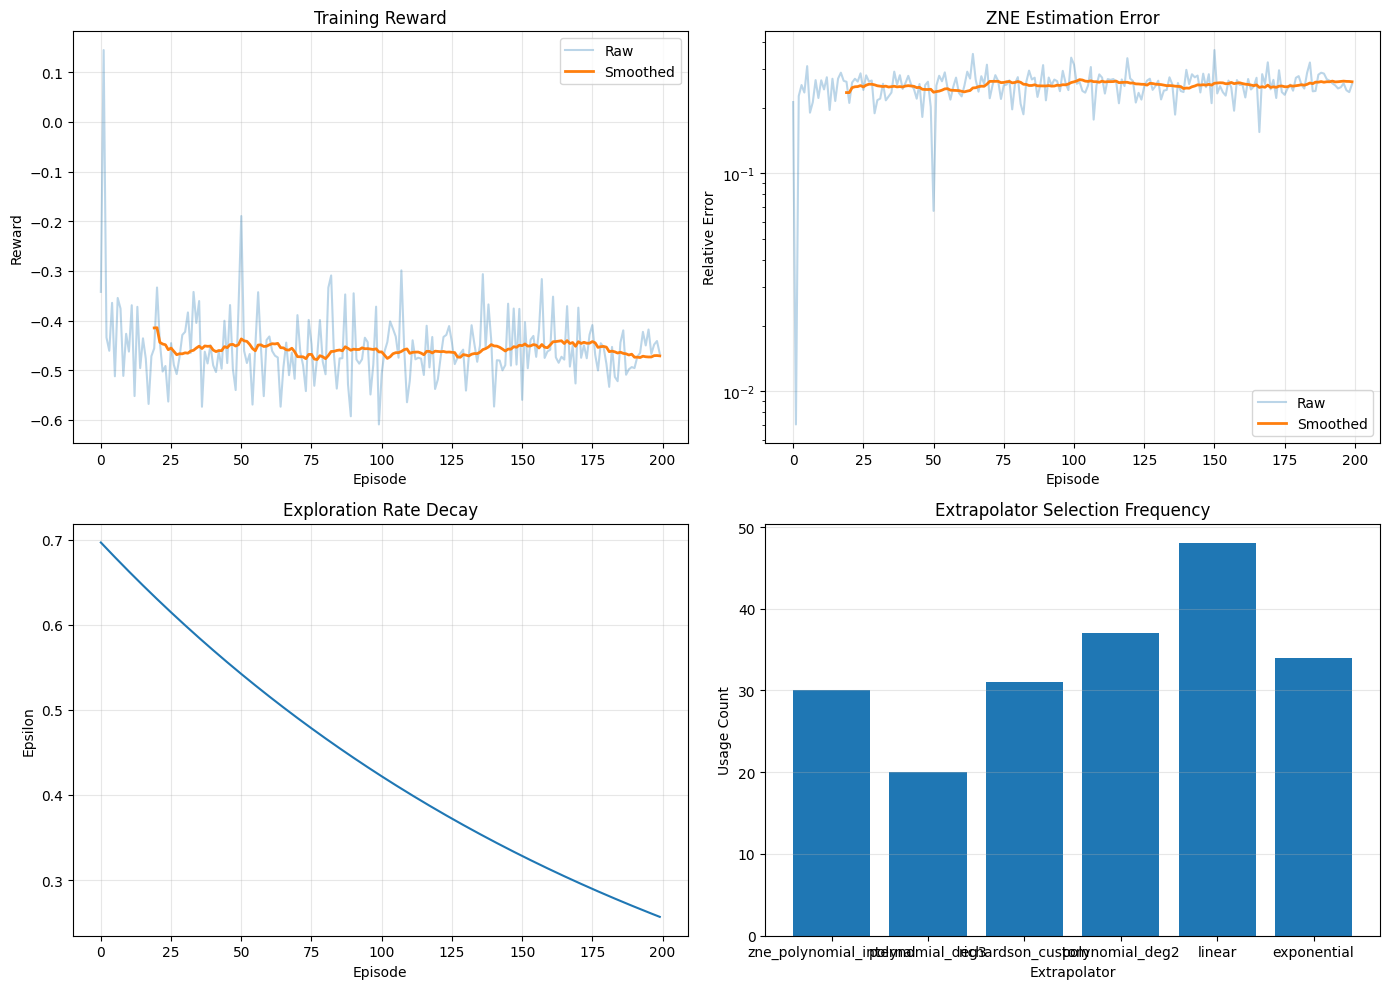

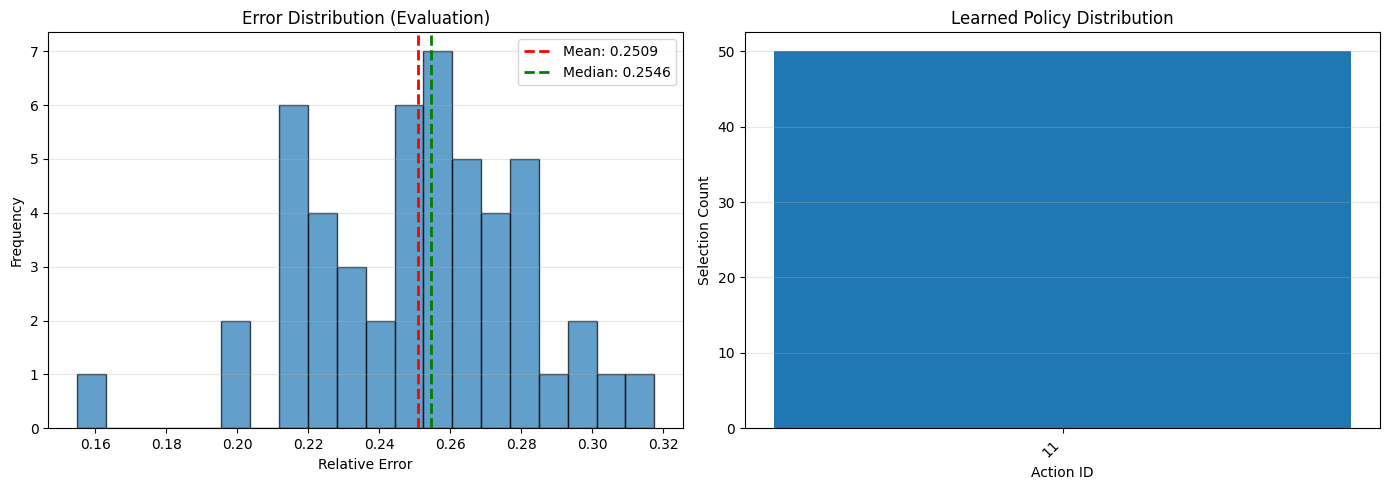

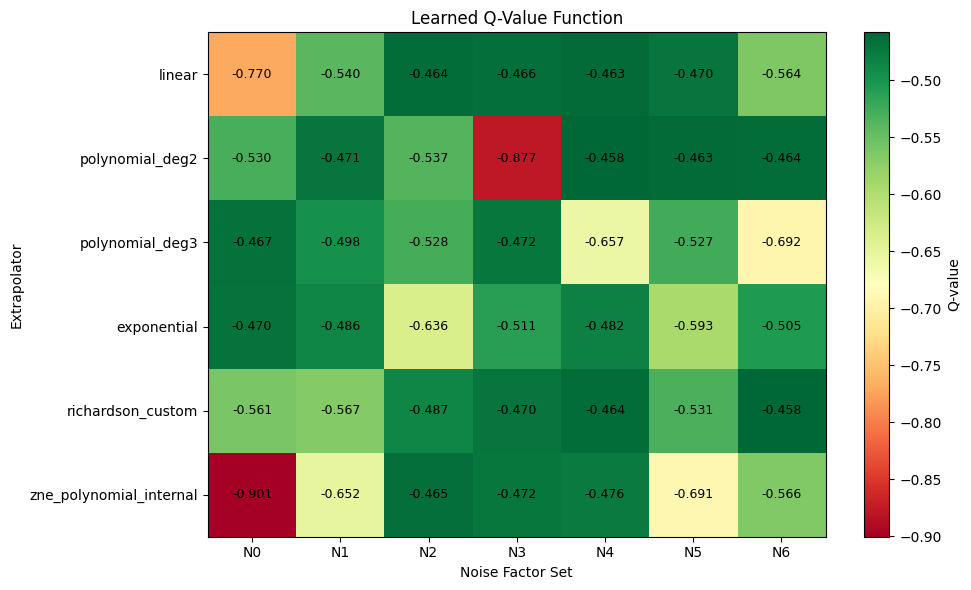

Evaluating: 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


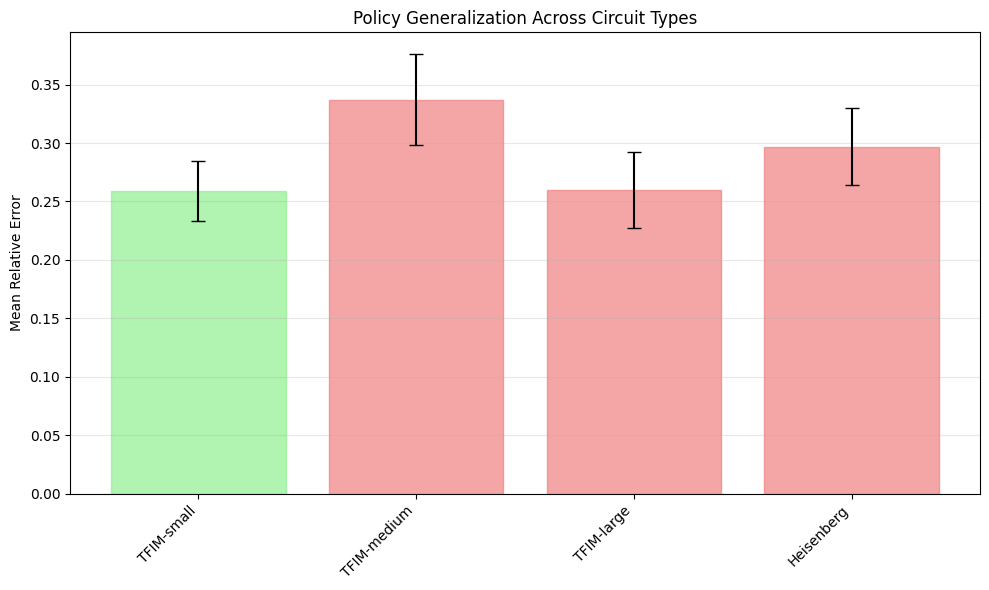

Improvement over random: 1.49%
Mann-Whitney p-value: 0.416732
Generalization results:
TFIM-small: mean=0.258960, std=0.025346
TFIM-medium: mean=0.337033, std=0.038862
TFIM-large: mean=0.259602, std=0.032541
Heisenberg: mean=0.296686, std=0.032916


In [6]:
import numpy as np
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from zne import zne, ZNEStrategy
from zne.extrapolation import LinearExtrapolator, PolynomialExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
import scipy.stats as stats

warnings.filterwarnings("ignore")

def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return float(values[0])
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[1])

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 3:
        return linear_extrapolate(lambdas, values)
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def poly3_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 4:
        return poly2_extrapolate(lambdas, values)
    A = np.vstack([np.array(lambdas)**3, np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[3])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    lambdas = np.array(lambdas)
    values = np.array(values)
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift
    if len(lambdas) == 1:
        return float(values[0] - shift)
    try:
        coefs = np.polyfit(lambdas, np.log(values), 1)
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

def richardson_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return float(values[0])
    lambdas = np.array(lambdas)
    values = np.array(values)
    if len(lambdas) == 2:
        l1, l2 = lambdas
        v1, v2 = values
        return float((l2 * v1 - l1 * v2) / (l2 - l1))
    return poly2_extrapolate(lambdas, values)

EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("polynomial_deg2", poly2_extrapolate),
    2: ("polynomial_deg3", poly3_extrapolate),
    3: ("exponential", exponential_extrapolate),
    4: ("richardson_custom", richardson_extrapolate),
    5: ("zne_polynomial_internal", None),
}

def generate_xyz_hamiltonian(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    terms, coeffs = [], []
    for i in range(n_qubits - 1):
        for pauli, coupling in [("X", Jx), ("Y", Jy), ("Z", Jz)]:
            if abs(coupling) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i + 1] = pauli
                terms.append("".join(p))
                coeffs.append(coupling)
    for i in range(n_qubits):
        for pauli, field in [("X", hx), ("Y", hy), ("Z", hz)]:
            if abs(field) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                terms.append("".join(p))
                coeffs.append(field)
    return SparsePauliOp.from_list(list(zip(terms, coeffs)))

def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
) -> QuantumCircuit:
    H = generate_xyz_hamiltonian(n_qubits, Jx, Jy, Jz, hx, hy, hz)
    evo_gate = PauliEvolutionGate(H, time=dt, synthesis=SuzukiTrotter(reps=1))
    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))
    return qc

def expand_observable(base: str, n_qubits: int) -> SparsePauliOp:
    if len(base) > n_qubits:
        raise ValueError(f"Observable {base} too large for {n_qubits} qubits")
    if len(base) == n_qubits:
        return SparsePauliOp(base)
    padding = "I" * (n_qubits - len(base))
    return SparsePauliOp(base + padding)

@dataclass
class ZNEEnvironment:
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"
    NOISE_FACTOR_SETS = [
        [1, 3],
        [1, 3, 5],
        [1, 2, 3, 4, 5],
        [1, 3, 5, 7],
        [1, 3, 5, 7, 9],
        [1, 2, 4, 6, 8],
        [1, 3, 5, 7, 9, 11],
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self) -> np.ndarray:
        self.circuit = self.circuit_generator()
        n_qubits = self.circuit.num_qubits
        self.observable = expand_observable(self.base_observable, n_qubits)
        self.backend = FakeNairobi()
        ZNEEstimator = zne(BackendEstimator)
        self.estimator = ZNEEstimator(backend=self.backend)
        self.ideal_value = Estimator().run(self.circuit, self.observable).result().values[0]
        return self._get_observation()

    def _get_observation(self) -> np.ndarray:
        features = [
            self.circuit.depth(),
            self.circuit.num_qubits,
            self.circuit.count_ops().get('cx', 0),
            self.circuit.size(),
        ]
        return np.array(features, dtype=np.float32)

    def step(self, action: Tuple[int, int]) -> Tuple[np.ndarray, float, bool, Dict]:
        extrap_id, noise_id = action
        extrap_name, extrap_fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]
        USE_ZNE_INTERNAL = (extrap_id == 5)
        if USE_ZNE_INTERNAL:
            internal_extrap = PolynomialExtrapolator(degree=1)
        else:
            internal_extrap = PolynomialExtrapolator(degree=1)
        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            extrapolator=internal_extrap
        )
        job = self.estimator.run(self.circuit, self.observable, zne_strategy=strategy)
        result = job.result()
        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])
        if USE_ZNE_INTERNAL:
            zne_estimate = result.values[0]
        else:
            try:
                zne_estimate = extrap_fn(lambdas, noisy_values)
            except Exception:
                zne_estimate = noisy_values[0]
        error = abs(zne_estimate - self.ideal_value)
        relative_error = error / (abs(self.ideal_value) + 1e-10)
        base_reward = -relative_error**0.5
        if len(noisy_values) > 1:
            diffs = np.diff(noisy_values)
            monotonic_score = np.mean(diffs <= 0)
            monotonic_bonus = 0.15 * monotonic_score
        else:
            monotonic_bonus = 0.0
        variance_penalty = -0.08 * np.mean(variances)
        efficiency_bonus = 0.01 * (7 - len(noise_factors)) / 6
        accuracy_bonus = 0.0
        if relative_error < 0.1:
            accuracy_bonus = 0.2 * (1 - relative_error / 0.1)
        total_reward = base_reward + monotonic_bonus + variance_penalty + efficiency_bonus + accuracy_bonus
        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": relative_error,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": extrap_name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base_reward,
            "monotonic_bonus": monotonic_bonus,
            "variance_penalty": variance_penalty,
            "efficiency_bonus": efficiency_bonus,
            "accuracy_bonus": accuracy_bonus,
        }
        return self._get_observation(), total_reward, True, info

class TDMCAgent:
    def __init__(
        self,
        n_extrapolators: int,
        n_noise_sets: int,
        learning_rate: float = 0.25,
        discount_factor: float = 0.95,
        epsilon: float = 0.7,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.05,
        trace_decay: float = 0.8,
    ):
        self.n_extrapolators = n_extrapolators
        self.n_noise_sets = n_noise_sets
        self.Q = np.random.randn(n_extrapolators, n_noise_sets) * 0.01
        self.E = np.zeros_like(self.Q)
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambda_trace = trace_decay
        self.action_counts = np.zeros_like(self.Q)
        self.total_steps = 0

    def select_action(self, exploration: bool = True) -> Tuple[int, int]:
        if exploration and np.random.rand() < self.epsilon:
            extrap_id = np.random.randint(self.Q.shape[0])
            noise_id = np.random.randint(self.Q.shape[1])
        else:
            extrap_id, noise_id = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        return extrap_id, noise_id

    def update(self, action: Tuple[int, int], reward: float, info: Dict[str, Any]):
        i, j = action
        self.action_counts[i, j] += 1
        self.total_steps += 1
        td_error = reward - self.Q[i, j]
        self.E[i, j] += 1.0
        self.Q += self.alpha * td_error * self.E
        self.E *= self.gamma * self.lambda_trace
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self) -> np.ndarray:
        policy = np.zeros_like(self.Q)
        best_action = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        policy[best_action] = 1.0
        return policy

    def get_value_function(self) -> np.ndarray:
        return self.Q.copy()

def train_agent(env: ZNEEnvironment, agent: TDMCAgent, n_episodes: int = 250, verbose: bool = True, detailed_log: bool = False) -> Dict[str, List]:
    history = {
        "rewards": [], "errors": [], "relative_errors": [],
        "estimates": [], "ideal_values": [], "extrapolators": [],
        "noise_sets": [], "actions": [], "n_noise_factors": [], "epsilons": [],
    }
    iterator = tqdm(range(n_episodes), desc="Training") if verbose else range(n_episodes)
    for episode in iterator:
        obs = env.reset()
        action = agent.select_action(exploration=True)
        next_obs, reward, done, info = env.step(action)
        agent.update(action, reward, info)
        combined_action_id = action[0] * agent.n_noise_sets + action[1]
        if detailed_log:
            print(f"Ep {episode}: ideal={info['ideal']:.6f}, est={info['estimate']:.6f}, lambdas={info['lambdas']}, vals={np.round(info['noisy_values'],6).tolist()}, act={combined_action_id}, R={reward:.6f}")
        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id)
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)
        if len(history["relative_errors"]) >= 20 and verbose:
            avg_rel_error = np.mean(history["relative_errors"][-20:])
            iterator.set_postfix({"RelErr": f"{avg_rel_error:.4f}", "ε": f"{agent.epsilon:.3f}"})
    return history

def evaluate_agent(env: ZNEEnvironment, agent: TDMCAgent, n_episodes: int = 50, detailed_log: bool = False) -> Dict[str, List]:
    results = {
        "errors": [], "relative_errors": [], "extrapolators": [],
        "noise_sets": [], "actions": [], "estimates": [], "ideal_values": [],
    }
    for ep in tqdm(range(n_episodes), desc="Evaluating"):
        obs = env.reset()
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)
        combined_action_id = action[0] * agent.n_noise_sets + action[1]
        if detailed_log:
            print(f"Eval {ep}: ideal={info['ideal']:.6f}, est={info['estimate']:.6f}, λ={info['lambdas']}, act={combined_action_id}")
        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id)
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])
    return results

def baseline_comparison(env: ZNEEnvironment, n_trials: int = 50):
    random_results = {"errors": [], "relative_errors": [], "estimates": [], "ideal_values": []}
    for _ in tqdm(range(n_trials), desc="Random baseline"):
        env.reset()
        extrap_id = np.random.randint(len(EXTRAPOLATORS))
        noise_id = np.random.randint(len(env.NOISE_FACTOR_SETS))
        action = (extrap_id, noise_id)
        _, reward, _, info = env.step(action)
        random_results["errors"].append(info["error"])
        random_results["relative_errors"].append(info["relative_error"])
        random_results["estimates"].append(info["estimate"])
        random_results["ideal_values"].append(info["ideal"])
    return random_results

def plot_training_results(history: Dict[str, List], save_path: str = None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    ax = axes[0, 0]
    rewards = history["rewards"]
    ax.plot(rewards, alpha=0.3, label="Raw")
    window = 20
    if len(rewards) > window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Training Reward")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax = axes[0, 1]
    rel_errors = history["relative_errors"]
    ax.plot(rel_errors, alpha=0.3, label="Raw")
    if len(rel_errors) > window:
        smoothed = np.convolve(rel_errors, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rel_errors)), smoothed, linewidth=2, label="Smoothed")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Relative Error")
    ax.set_title("ZNE Estimation Error")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    ax = axes[1, 0]
    ax.plot(history["epsilons"])
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.set_title("Exploration Rate Decay")
    ax.grid(True, alpha=0.3)
    ax = axes[1, 1]
    from collections import Counter
    extrap_counts = Counter(history["extrapolators"])
    ax.bar([EXTRAPOLATORS[i][0] for i in extrap_counts.keys()], extrap_counts.values())
    ax.set_xlabel("Extrapolator")
    ax.set_ylabel("Usage Count")
    ax.set_title("Extrapolator Selection Frequency")
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_evaluation_results(results: Dict[str, List], save_path: str = None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ax = axes[0]
    rel_errors = results["relative_errors"]
    ax.hist(rel_errors, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(rel_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(rel_errors):.4f}')
    ax.axvline(np.median(rel_errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(rel_errors):.4f}')
    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Frequency")
    ax.set_title("Error Distribution (Evaluation)")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax = axes[1]
    from collections import Counter
    action_counts = Counter(results["actions"])
    labels = [str(k) for k in action_counts.keys()]
    ax.bar(range(len(action_counts)), action_counts.values())
    ax.set_xticks(range(len(action_counts)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel("Action ID")
    ax.set_ylabel("Selection Count")
    ax.set_title("Learned Policy Distribution")
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_q_table(agent: TDMCAgent, save_path: str = None):
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(agent.Q, cmap='RdYlGn', aspect='auto')
    ax.set_xticks(range(agent.Q.shape[1]))
    ax.set_yticks(range(agent.Q.shape[0]))
    noise_labels = [f"N{i}" for i in range(agent.Q.shape[1])]
    extrap_labels = [EXTRAPOLATORS[i][0] for i in range(agent.Q.shape[0])]
    ax.set_xticklabels(noise_labels)
    ax.set_yticklabels(extrap_labels)
    for i in range(agent.Q.shape[0]):
        for j in range(agent.Q.shape[1]):
            ax.text(j, i, f'{agent.Q[i, j]:.3f}', ha="center", va="center", color="black", fontsize=9)
    ax.set_xlabel("Noise Factor Set")
    ax.set_ylabel("Extrapolator")
    ax.set_title("Learned Q-Value Function")
    plt.colorbar(im, ax=ax, label="Q-value")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def run_full_experiment():
    def circuit_gen():
        return xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.8)
    env = ZNEEnvironment(circuit_generator=circuit_gen, base_observable="ZZ")
    agent = TDMCAgent(n_extrapolators=len(EXTRAPOLATORS), n_noise_sets=len(env.NOISE_FACTOR_SETS), learning_rate=0.25, epsilon=0.7, epsilon_decay=0.995)
    history = train_agent(env, agent, n_episodes=200, verbose=True, detailed_log=False)
    rl_results = evaluate_agent(env, agent, n_episodes=50, detailed_log=True)
    baseline_results = baseline_comparison(env, n_trials=50)
    rl_mean = np.mean(rl_results['relative_errors'])
    baseline_mean = np.mean(baseline_results['relative_errors'])
    improvement = ((baseline_mean - rl_mean) / baseline_mean) * 100 if baseline_mean != 0 else 0.0
    statistic, p_value = stats.mannwhitneyu(baseline_results['relative_errors'], rl_results['relative_errors'], alternative='greater')
    plot_training_results(history, save_path="training_results.png")
    plot_evaluation_results(rl_results, save_path="evaluation_results.png")
    visualize_q_table(agent, save_path="q_table.png")
    plot_comparison = None
    return history, rl_results, agent, baseline_results, improvement, p_value

def test_generalization(agent: TDMCAgent):
    circuit_configs = [
        {"name": "TFIM-small", "generator": lambda: xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7)},
        {"name": "TFIM-medium", "generator": lambda: xyz_trotter_circuit(n_qubits=4, trotter_steps=3, dt=0.1, Jx=0.5, hz=0.8)},
        {"name": "TFIM-large", "generator": lambda: xyz_trotter_circuit(n_qubits=5, trotter_steps=2, dt=0.15, Jx=0.6, hz=0.9)},
        {"name": "Heisenberg", "generator": lambda: xyz_trotter_circuit(n_qubits=4, trotter_steps=2, dt=0.1, Jx=0.4, Jy=0.4, Jz=0.4)},
    ]
    results = {}
    for config in circuit_configs:
        test_env = ZNEEnvironment(circuit_generator=config["generator"], base_observable="ZZ")
        eval_results = evaluate_agent(test_env, agent, n_episodes=30, detailed_log=False)
        results[config["name"]] = {"mean_error": np.mean(eval_results["relative_errors"]), "std_error": np.std(eval_results["relative_errors"])}
    names = list(results.keys())
    means = [results[n]["mean_error"] for n in names]
    stds = [results[n]["std_error"] for n in names]
    x = np.arange(len(names))
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
    bars[0].set_color('lightgreen')
    for i in range(1, len(bars)):
        bars[i].set_color('lightcoral')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel("Mean Relative Error")
    ax.set_title("Policy Generalization Across Circuit Types")
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig("fig_generalization.png", dpi=300, bbox_inches='tight')
    plt.show()
    return results

if __name__ == "__main__":
    history, rl_results, agent, baseline_results, improvement, p_value = run_full_experiment()
    gen_results = test_generalization(agent)
    print(f"Improvement over random: {improvement:.2f}%")
    print(f"Mann-Whitney p-value: {p_value:.6f}")
    print("Generalization results:")
    for k, v in gen_results.items():
        print(f"{k}: mean={v['mean_error']:.6f}, std={v['std_error']:.6f}")
